# 1D CNN Segmentation - Insole(vGRF) to 3D-GRFM

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.6.0+cu126


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

2025-07-10 01:01:27.965686: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 01:01:28.493097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752098488.677742  112271 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752098488.758850  112271 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752098489.336453  112271 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Libraries

In [3]:
import os
import re
import h5py
import scipy
import random
import pickle
import json
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, root_mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
from scipy import stats, signal
sns.set_style('white')
from models import *
from models.unet_variants import *
from models.MLMRSNet import *
from scipy.signal import resample, medfilt, find_peaks
from scipy.signal import butter, lfilter, freqz
%matplotlib inline

# Global Configurations

In [4]:
task_num = 1
start_fold = 1
end_fold = 5
target_quantity = 'Mz'
body_side = 'RL'
movement_type = 'combined_insole_FP'
FP_Channel_Info = ['Fx','Fy','Fz','Mx','My','Mz','CoPx','CoPy','CoPz']
Insole_Channel_Info = ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15','p16','acc1','acc2','acc3','ang1','ang2','ang3','Fy','CoPx','CoPy']
weight_array = [75.2,65.1,56.0,80.8,61.5,81.0,61.6,62.4,69.0]
print(FP_Channel_Info)
print(weight_array)

['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'CoPx', 'CoPy', 'CoPz']
[75.2, 65.1, 56.0, 80.8, 61.5, 81.0, 61.6, 62.4, 69.0]


# Import and Prepare Data

Load File and Extract

In [5]:
# Import
fl_Data_Walk = h5py.File(os.path.join('Data_Preprocessed_Walk.mat'), 'r')
fl_Data_Run = h5py.File(os.path.join('Data_Preprocessed_Run.mat'), 'r')
print(fl_Data_Walk.keys())
# Import
fl_Data_Walk = h5py.File(os.path.join('Data_Preprocessed_Walk.mat'), 'r')
fl_Data_Run = h5py.File(os.path.join('Data_Preprocessed_Run.mat'), 'r')
print(fl_Data_Walk.keys())
# Left Leg (LL) Insole VGRF Data per sensor
X_Data_LL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_LL']),0,2)
X_Data_LL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_LL']),0,2)
X_Data_LL = np.concatenate((X_Data_LL_Walk, X_Data_LL_Run), axis=0)
X_Data_Labels = np.array(fl_Data_Walk['label_Insole'])
print(X_Data_LL.shape)
# Right Leg (RL) Insole VGRF Data per sensor
X_Data_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_RL']),0,2)
X_Data_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_RL']),0,2)
X_Data_RL = np.concatenate((X_Data_RL_Walk, X_Data_RL_Run), axis=0)
print(X_Data_RL.shape)
# Left Leg (LL) GRF Data
Y_Data_LL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Force_FP_LL']),0,2)
Y_Data_LL_Run = np.swapaxes(np.array(fl_Data_Run['data_Force_FP_LL']),0,2)
Y_Data_LL = np.concatenate((Y_Data_LL_Walk, Y_Data_LL_Run), axis=0)
print(Y_Data_LL.shape)
# Right Leg (RL) GRF Data
Y_Data_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Force_FP_RL']),0,2)
Y_Data_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Force_FP_RL']),0,2)
Y_Data_RL = np.concatenate((Y_Data_RL_Walk, Y_Data_RL_Run), axis=0)
print(Y_Data_RL.shape)
Y_Label_sub_Walk = np.swapaxes(np.array(fl_Data_Walk['subinfo']),0,1)
Y_Label_sub_Run = np.swapaxes(np.array(fl_Data_Run['subinfo']),0,1)
Y_Label_sub = np.concatenate((Y_Label_sub_Walk, Y_Label_sub_Run), axis=0)
print(Y_Label_sub.shape)
Y_Label_speed_Walk = np.swapaxes(np.array(fl_Data_Walk['speedinfo']),0,1)
Y_Label_speed_Run = np.swapaxes(np.array(fl_Data_Run['speedinfo']),0,1)
Y_Label_speed = np.concatenate((Y_Label_speed_Walk, Y_Label_speed_Run), axis=0)
print(Y_Label_speed)
Y_Label_LL_mode_Walk = np.zeros((Y_Data_LL_Walk.shape[0],1), dtype=int)
Y_Label_LL_mode_Run = np.ones((Y_Data_LL_Run.shape[0],1), dtype=int)
Y_Label_LL_mode = np.concatenate((Y_Label_LL_mode_Walk, Y_Label_LL_mode_Run), axis=0)
print(Y_Label_LL_mode.shape)
print(np.unique(Y_Label_LL_mode))
Y_Label_RL_mode_Walk = np.zeros((Y_Data_RL_Walk.shape[0],1), dtype=int)
Y_Label_RL_mode_Run = np.ones((Y_Data_RL_Run.shape[0],1), dtype=int)
Y_Label_RL_mode = np.concatenate((Y_Label_RL_mode_Walk, Y_Label_RL_mode_Run), axis=0)
print(Y_Label_RL_mode.shape)
print(np.unique(Y_Label_RL_mode))
# Check for NaNs and InFs
data = pd.Series(X_Data_LL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(X_Data_RL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data_LL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data_RL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
del fl_Data_Walk, fl_Data_Run, X_Data_LL_Walk, X_Data_LL_Run, X_Data_RL_Walk, X_Data_RL_Run, Y_Data_LL_Walk, Y_Data_LL_Run, Y_Data_RL_Walk, Y_Data_RL_Run
del Y_Label_sub_Walk, Y_Label_sub_Run, Y_Label_speed_Walk, Y_Label_speed_Run, Y_Label_LL_mode_Walk, Y_Label_LL_mode_Run, Y_Label_RL_mode_Walk, Y_Label_RL_mode_Run

<KeysViewHDF5 ['#refs#', '#subsystem#', 'data_CoM', 'data_EMG', 'data_Force_FP_LL', 'data_Force_FP_RL', 'data_IMU', 'data_Insole_LL', 'data_Insole_RL', 'label_EMG', 'label_FP', 'label_IMU', 'label_Insole', 'speedinfo', 'subinfo']>
<KeysViewHDF5 ['#refs#', '#subsystem#', 'data_CoM', 'data_EMG', 'data_Force_FP_LL', 'data_Force_FP_RL', 'data_IMU', 'data_Insole_LL', 'data_Insole_RL', 'label_EMG', 'label_FP', 'label_IMU', 'label_Insole', 'speedinfo', 'subinfo']>
(4737, 1024, 25)
(4737, 1024, 25)
(4737, 1024, 9)
(4737, 1024, 9)
(4737, 1)
[[ 9.]
 [ 9.]
 [ 9.]
 ...
 [99.]
 [99.]
 [99.]]
(4737, 1)
[0 1]
(4737, 1)
[0 1]
False
False
False
False
False
False
False
False


Select Task (Right or Left foot)

In [6]:
if body_side == 'RL':
    X_Data = X_Data_RL
    Y_Data = Y_Data_RL
    Y_Label_mode = Y_Label_RL_mode
elif body_side == 'LL':
    X_Data = X_Data_LL
    Y_Data = Y_Data_LL
    Y_Label_mode = Y_Label_LL_mode
y_channel_index = FP_Channel_Info.index(target_quantity)
Y_Data_insole = X_Data[:,:,22]
X_Data = X_Data[:,:,0:16]
Y_Data = np.expand_dims(Y_Data[:,:,y_channel_index], axis=2)
print(X_Data.shape)
print(Y_Data.shape)
print(Y_Data_insole.shape)
print(Y_Label_mode.shape)

(4737, 1024, 16)
(4737, 1024, 1)
(4737, 1024)
(4737, 1)


Select Channels (Optional)

In [8]:
# Remove Low Correlated Insole Channels
print(X_Data.shape)
sample_num = X_Data.shape[0]
segment_length = X_Data.shape[1]
num_channels = X_Data.shape[2]
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
Insole_Channels_Selected = []
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_pcc, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    data_current_channel_cos = np.dot(data_current_channel.ravel(),Y_Data.ravel())/(np.linalg.norm(data_current_channel.ravel())*np.linalg.norm(Y_Data.ravel()))
    data_current_channel_rr = r2_score(data_current_channel.ravel(), Y_Data.ravel())
    data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_var > 0):
        # if (data_current_channel_pcc > 0.05) and (data_current_channel_cos > 0.3):
        if (np.abs(data_current_channel_pcc) >= 0.001):
            X_Data_Pruned[:,:,counter] = data_current_channel
            Insole_Channels_Selected.append(Insole_Channel_Info[i])
            print(Insole_Channel_Info[i])
            print(data_current_channel_pcc)
            # print(data_current_channel_cos)
            # print(data_current_channel_rr)
            counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Shape)
print(Insole_Channels_Selected)

(4737, 1024, 16)
p1
0.11204601332949762
p2
0.1283469676178127
p3
-0.005790612774162273
p4
0.03364813250340649
p5
-0.19832174490084037
p6
-0.18206994054447223
p7
-0.2971284501819528
p8
-0.3113926308291707
p9
-0.37975194775018406
p10
-0.3880102650084821
p11
-0.4037307197008189
p12
-0.4139427410103635
p13
-0.4286068722201497
p14
-0.36040823453088905
p15
-0.38991646513094885
p16
-0.40646888743101567
(4737, 1024, 16)
['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16']


In [ ]:
## Remove highly intercorrelated channels
# Convert Arrays to Python Dictionaries
X_Data_Feature_List = Insole_Channels_Selected
X_Data_Array = np.reshape(X_Data_Pruned,(X_Data_Pruned.shape[0]*X_Data_Pruned.shape[1],X_Data_Pruned.shape[2]))
X_Data_Dict = pd.DataFrame(X_Data_Array,columns=X_Data_Feature_List)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_Data_Dict.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_Data_Dict.columns.values]
# Prune channels based on PCC
thresh = 0.9  # VIF = 10
vif_thresh = 10
cor_matrix = X_Data_Dict.corr().abs()
vif_matrix = 1/(1-cor_matrix)
vif_array = np.array(vif_matrix).flatten()
vif_array[~np.isfinite(vif_array)] = 0
upper_tri = vif_matrix.where(np.triu(np.ones(vif_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > vif_thresh)]
X_Data_Updated_Dict = X_Data_Dict.drop(to_drop, axis=1)
X_Data_Updated = np.reshape(X_Data_Updated_Dict, (X_Data_Pruned.shape[0],X_Data_Pruned.shape[1],X_Data_Updated_Dict.shape[1]))
print(X_Data_Updated.shape)
insole_sensors_Final = [x for x in X_Data_Dict.columns if x not in to_drop]
print(insole_sensors_Final)

# Plot Cross-correlation Heatmap
plt.subplots(figsize=(14, 12))
low_tri_matrix = np.triu(1/(1-X_Data_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Dict.corr()), vmin=0, vmax=np.max(vif_array), annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='YlOrBr', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
X_Data = X_Data_Updated
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(8, 6))
low_tri_matrix = np.triu(1/(1-X_Data_Updated_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Updated_Dict.corr()), vmin=0, vmax=vif_thresh, annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
# res.xaxis.tick_top()
X_Data = X_Data_Updated

In [ ]:
## Remove highly intercorrelated channels
# Convert Arrays to Python Dictionaries
X_Data_Feature_List = Insole_Channels_Selected
X_Data_Array = np.reshape(X_Data_Pruned,(X_Data_Pruned.shape[0]*X_Data_Pruned.shape[1],X_Data_Pruned.shape[2]))
X_Data_Dict = pd.DataFrame(X_Data_Array,columns=X_Data_Feature_List)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_Data_Dict.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_Data_Dict.columns.values]
# Prune channels based on PCC
thresh = 0.9  # VIF = 10
vif_thresh = 10
cor_matrix = X_Data_Dict.corr().abs()
vif_matrix = 1/(1-cor_matrix)
vif_array = np.array(vif_matrix).flatten()
vif_array[~np.isfinite(vif_array)] = 0
upper_tri = vif_matrix.where(np.triu(np.ones(vif_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > vif_thresh)]
X_Data_Updated_Dict = X_Data_Dict.drop(to_drop, axis=1)
X_Data_Updated = np.reshape(X_Data_Updated_Dict, (X_Data_Pruned.shape[0],X_Data_Pruned.shape[1],X_Data_Updated_Dict.shape[1]))
print(X_Data_Updated.shape)
insole_sensors_Final = [x for x in X_Data_Dict.columns if x not in to_drop]
print(insole_sensors_Final)
'''
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(14, 12))
low_tri_matrix = np.triu(1/(1-X_Data_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Dict.corr()), vmin=0, vmax=np.max(vif_array), annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
X_Data = X_Data_Updated
'''
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(8, 6))
low_tri_matrix = np.triu(1/(1-X_Data_Updated_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Updated_Dict.corr()), vmin=0, vmax=vif_thresh, annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
# res.xaxis.tick_top()
X_Data = X_Data_Updated

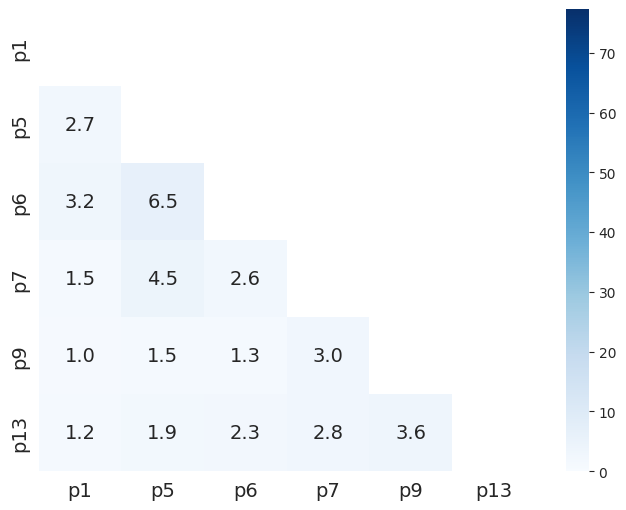

In [19]:
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(8, 6))
low_tri_matrix = np.triu(1/(1-X_Data_Updated_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Updated_Dict.corr()), vmin=0, vmax=77.267, annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
# res.xaxis.tick_top()
X_Data = X_Data_Updated

77.26703628786832


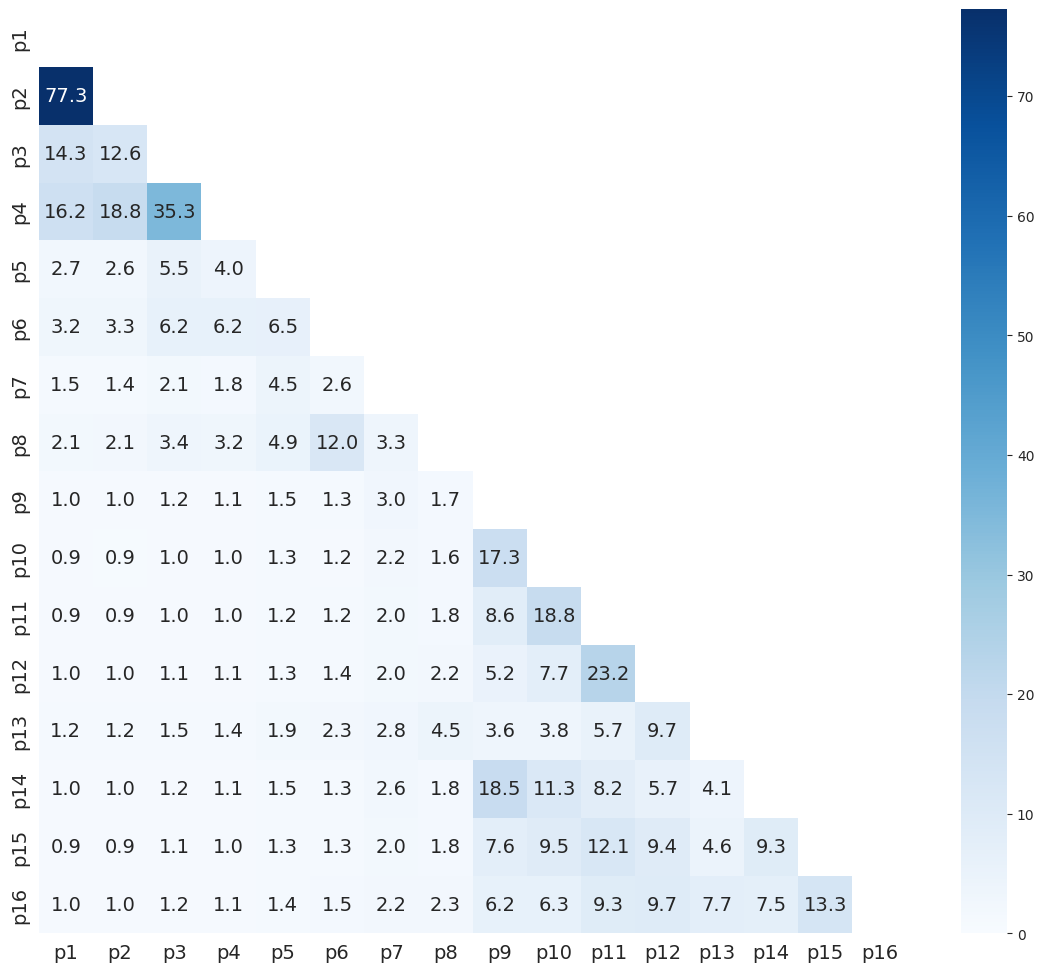

In [18]:
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(14, 12))
low_tri_matrix = np.triu(1/(1-X_Data_Dict.corr()))
print(np.max(vif_array))
res = sns.heatmap(1/(1-X_Data_Dict.corr()), vmin=0, vmax=np.max(vif_array), annot=True, annot_kws={"size": 14}, fmt='.1f', 
                  cmap=sns.color_palette("Blues", as_cmap=True), mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
X_Data = X_Data_Updated

## Visualizations

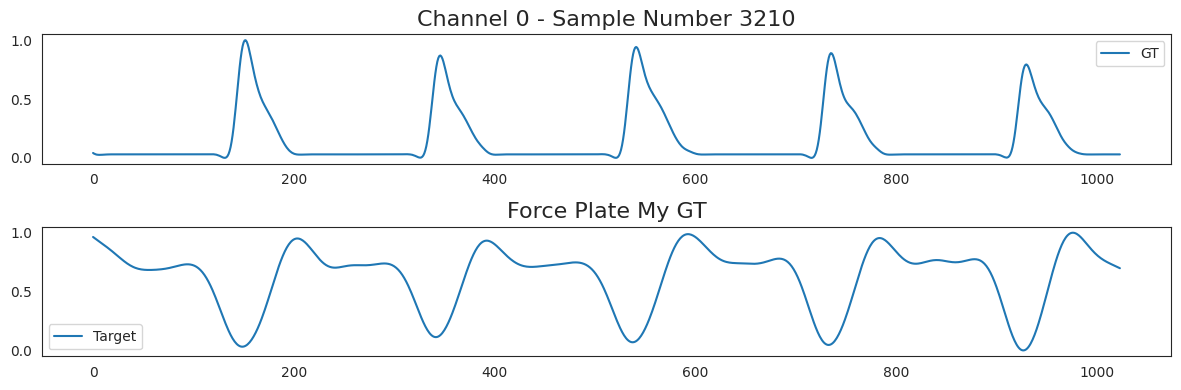

In [9]:
# Plot
data_shape = X_Data.shape
c = random.randint(0, data_shape[2]-1)
i = random.randint(0, data_shape[0]-1)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(X_Data[i,:,c], label='GT')
# plt.ylim(0,1)
plt.title(f"Channel {c} - Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Force Plate {target_quantity} GT", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

# MAIN

Experimenal Configurations

In [10]:
# Configurations
signal_length = X_Data.shape[1]  # Length of each Segment
model_name = 'IMUNet'  # UNet, UNetPP, etc.
model_depth = 5  # Number of Level in the CNN Model
model_width = 32  # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3  # Size of the Kernels/Filter
num_channel = X_Data.shape[2] # Number of Channels in the Model
D_S = 1  # Turn on Deep Supervision
A_E = 0  # Turn on AutoEncoder Mode for Feature Extraction
A_G = 0  # Turn on for Guided Attention
LSTM = 0  # Turn on BiConvLSTM Block
problem_type = 'Regression'
output_nums = Y_Data.shape[2]  # Number of Class for Classification Problems, always '1' for Regression Problems
is_transconv = True # True: Transposed Convolution, False: UpSampling
feature_number = 1024  # Number of Features to be Extracted, only required if the AutoEncoder Mode is turned on

## Model Specific Configurations
alpha = 1  # Model Width Expansion Parameter, for MultiResUNet only
pooling_type = 'mix' # pooling_type, only for EMARS
cardinality = 5  # Cardinality, only for EMARS
q = 3
t = 1

## Data Configurations
DS_Model_Type = 'UNet' # UNet or UNetPP
## Experimental Configurations8
load_weights = False
max_epoch_stop = 30
max_epoch_lr_change = 10
lr = 5e-4
lr_factor = 0.1
monitor_param = 'loss'  # 'loss' or 'acc' for monitoring

Helper Functions

In [11]:
def prepareTrainDict(batch_data, model_depth, model_name):
    def approximate(inp, w_len):
        ops = tf.keras.layers.AveragePooling1D(pool_size=w_len)(inp)
        return ops

    batch_data = np.array(batch_data)
    Y_Train_dict = {}
    Y_Train_dict['out'] = batch_data
    for i in range(1, (model_depth+1)):
        name = f'level{i}'
        if model_name == 'UNet':
            Y_Train_dict[name] = approximate(batch_data, 2**i)
        elif model_name == 'UNetPP':
            Y_Train_dict[name] = batch_data

    return Y_Train_dict

In [12]:
def overlap_data(X_Data, Y_Data, overlap_ratio, target_segment_length):
    # Input Array Shape
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    original_segment_length = X_Data_Shape[1]
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data, (X_Data_Shape[0]*X_Data_Shape[1], X_Data_Shape[2]))
    Y_Data_Reshaped = np.reshape(Y_Data, (X_Data_Shape[0]*X_Data_Shape[1], Y_Data_Shape[2]))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    # Overlap
    offset_amount = np.int_(original_segment_length*(1 - overlap_ratio))
    X_Data_New = np.zeros((30000,target_segment_length,X_Data_Reshaped_Shape[1]))
    Y_Data_New = np.zeros((30000,target_segment_length,Y_Data_Reshaped_Shape[1]))
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
    counter = 0
    for i in range(0,num_segments_approx):
        if (i*offset_amount+target_segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp)-np.min(X_Data_Temp))  # Range Normalization [0 1]
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        Y_Data_Temp = (Y_Data_Temp - np.min(Y_Data_Temp))/(np.max(Y_Data_Temp)-np.min(Y_Data_Temp))
        Y_Data_New[counter,:,:] = Y_Data_Temp
        counter = counter + 1
    X_Data_OVRL = X_Data_New[0:counter,:,:]
    Y_Data_OVRL = Y_Data_New[0:counter,:,:]
    
    return X_Data_OVRL, Y_Data_OVRL

Train Loop

In [ ]:
for fnum in range(start_fold,end_fold + 1):
    print(f'Fold {fnum}')
    print(f'Loading Data...')
    if fnum == 1:
        train_sub_IDs = [4,5,6,7,8,9,10]
        test_sub_IDs = [11,12]
    elif fnum == 2:
        train_sub_IDs = [4,5,6,7,8,11,12]
        test_sub_IDs = [9,10]
    elif fnum == 3:
        train_sub_IDs = [4,5,6,9,10,11,12]
        test_sub_IDs = [7,8]
    elif fnum == 4:
        train_sub_IDs = [4,7,8,9,10,11,12]
        test_sub_IDs = [5,6]
    elif fnum == 5:
        train_sub_IDs = [5,6,7,8,9,10,11,12]
        test_sub_IDs = [4]
    train_Indices = np.where(Y_Label_sub == train_sub_IDs)[0]
    X_Train = np.take(X_Data, train_Indices, axis=0)
    Y_Train = np.take(Y_Data, train_Indices, axis=0)
    test_Indices = np.where(Y_Label_sub == test_sub_IDs)[0]
    X_Test = np.take(X_Data, test_Indices, axis=0)
    Y_Test = np.take(Y_Data, test_Indices, axis=0)
    Y_Test_Sub_Labels = np.take(Y_Label_sub, test_Indices, axis=0)
    Y_Test_Speed_Labels = np.take(Y_Label_speed, test_Indices, axis=0)
    Y_Test_Mode_Labels = np.take(Y_Label_mode, test_Indices, axis=0)
    X_Val = X_Test
    Y_Val = Y_Test
    print(f'Dataset info: ')
    print(X_Train.shape)
    print(Y_Train.shape)
    print(X_Test.shape)
    print(Y_Test.shape)
    print(X_Val.shape)
    print(Y_Val.shape)
    print(Y_Test_Sub_Labels.shape)
    print(Y_Test_Speed_Labels.shape)
    print(Y_Test_Mode_Labels.shape)
    X_Train, Y_Train = overlap_data(X_Train, Y_Train, 0.5, 1024)
    print(X_Train.shape)
    print(Y_Train.shape)
    RawDataPath = 'Train_Set.h5'
    hf = h5py.File(RawDataPath, 'w')
    hf.create_dataset('X', data=X_Train)
    hf.create_dataset('Y', data=Y_Train)
    hf.close()
    RawDataPath = 'Val_Set.h5'
    hf = h5py.File(RawDataPath, 'w')
    hf.create_dataset('X', data=X_Val)
    hf.create_dataset('Y', data=Y_Val)
    hf.close()
    RawDataPath = 'Test_Set.h5'
    hf = h5py.File(RawDataPath, 'w')
    hf.create_dataset('X', data=X_Test)
    hf.create_dataset('Y', data=Y_Test)
    hf.create_dataset('ID', data=Y_Test_Sub_Labels)
    hf.create_dataset('SPD', data=Y_Test_Speed_Labels)
    hf.create_dataset('MD', data=Y_Test_Mode_Labels)
    hf.close()
    print(f'Building Model...')
    # Build model for PPG2ABP Segmentation - Deep UNet Architecture
    IMU2VGRF_Network = MLMRSNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', output_nums=output_nums,
                                ds=D_S, ae=A_E, cardinality=cardinality, pooling_type=pooling_type).IMUNet()
    # print(IMU2VGRF_Network.summary())
    print(f'Starting Training...')
    if D_S == 0:  # Deep Supervision OFF
        # Compile Built Model
        IMU2VGRF_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size', name='mean_absolute_error'), 
                                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                                metrics=[tf.keras.metrics.MeanSquaredError(name='mean_squared_error', dtype=None)])
        # Directory for Saving Trained Models
        save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.keras'
        # Load Pretrained Weights (if available)
        if (os.path.exists(save_directory) and load_weights == True):
            print('\nLoading Pretrained Weights...')
            # Load Previously Trained Weights for Transfer Learning
            IMU2VGRF_Network.load_weights(save_directory)
        # Declare Callbacks
        if monitor_param == 'loss':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=max_epoch_stop, 
                                                        mode='min'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='min'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_loss', 
                                                        save_best_only=True,
                                                        mode='min')]
        elif monitor_param == 'acc':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                        patience=max_epoch_stop, 
                                                        mode='max'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='max'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_acc', 
                                                        save_best_only=True, 
                                                        mode='max'),
                        tf.keras.callbacks.TerminateOnNaN()]
        # Train Model
        model_history = IMU2VGRF_Network.fit(X_Train, 
                                            Y_Train, 
                                            epochs=500, 
                                            batch_size=8, 
                                            verbose=1, 
                                            validation_data=(X_Val, Y_Val), 
                                            shuffle=True, 
                                            callbacks=callbacks)
        # Test and Evaluation
        print(f'Evaluating on the Test Set...')
        Y_Pred = IMU2VGRF_Network.predict(X_Test, verbose=0)
        # Save History
        '''print('\n')
        print('Save History')
        # Get the dictionary containing each metric and the loss for each epoch
        history_dict = model_history.history
        history_path = f'History/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}_History.h5'
        json.dump(history_dict.item(), open(history_path, 'w'))
        print('\n')'''
        # Save Outcomes
        print(f'Saving Results...')
        File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fnum}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
        File.create_dataset('X_Test', data=X_Test)
        File.create_dataset('Y_Test', data=Y_Test)
        File.create_dataset('Y_Pred', data=Y_Pred)
        File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
        File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
        File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
        File.close()
        print('\n')
    elif D_S == 1:  # Deep Supervision ON
        # Prepare Train and Test Sets for Deep Supervision
        Y_Train_dict = prepareTrainDict(Y_Train, model_depth, DS_Model_Type)
        Y_Val_dict = prepareTrainDict(Y_Val, model_depth, DS_Model_Type)
        # Generate Custom Loss Weights for Deep Supervision
        loss_weights = {}
        keys = Y_Train_dict.keys()
        k = 0
        for key in keys:
            loss_weights[key] = 1-(k*0.1)
            k = k + 1
        #
        metrics_dic = []
        for i in range(0, model_depth + 1):
            metrics_dic.append(tf.keras.metrics.MeanSquaredError(name='mean_squared_error'))
        #
        losses_dic = []
        for i in range(0, model_depth + 1):
            losses_dic.append(tf.keras.losses.Huber(delta=1.0, 
                                                    reduction='sum_over_batch_size', 
                                                    name='huber_loss'))
        # Compile Built Model
        IMU2VGRF_Network.compile(loss=losses_dic, 
                                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                                metrics=metrics_dic, 
                                loss_weights=loss_weights)
        # Directory for Saving Trained Models
        save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.keras'
        # Load Pretrained Weights (if available)
        if (os.path.exists(save_directory) and load_weights == True):
            print('Loading Pretrained Weights...')
            # Load Previously Trained Weights for Transfer Learning
            IMU2VGRF_Network.load_weights(save_directory)
        # Declare Callbacks
        if monitor_param == 'loss':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', 
                                                        patience=max_epoch_stop, 
                                                        mode='min'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_loss', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='min'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_out_loss', 
                                                        save_best_only=True, 
                                                        mode='min')]
        elif monitor_param == 'acc':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_acc', 
                                                        patience=max_epoch_stop, 
                                                        mode='max'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_acc', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='max'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_out_acc', 
                                                        save_best_only=True, 
                                                        mode='max'),
                        tf.keras.callbacks.TerminateOnNaN()]
        # Train Model
        model_history = IMU2VGRF_Network.fit(X_Train, 
                                            Y_Train_dict, 
                                            epochs=500, 
                                            batch_size=16, 
                                            verbose=1, 
                                            validation_data=(X_Val, Y_Val_dict), 
                                            shuffle=True, 
                                            callbacks=callbacks)
        # Test and Evaluation
        print(f'Evaluating on the Test Set...')
        Y_Pred = IMU2VGRF_Network.predict(X_Test, verbose=0)
        Y_Pred = Y_Pred[-1]
        # Save Outcomes
        print(f'Saving Results...')
        File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fnum}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
        File.create_dataset('X_Test', data=X_Test)
        File.create_dataset('Y_Test', data=Y_Test)
        File.create_dataset('Y_Pred', data=Y_Pred)
        File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
        File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
        File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
        File.close()
    print(f'Delecting Fold {fnum} Data...')
    del IMU2VGRF_Network, model_history, X_Train, Y_Train, X_Test, Y_Test, X_Val, Y_Val, train_Indices, test_Indices
    del Y_Test_Sub_Labels, Y_Test_Speed_Labels, Y_Test_Mode_Labels, Y_Pred, Y_Train_dict, Y_Val_dict, File, hf
    gc.collect()
    print('\n')

Evaluate outside the training loop (if not saved normally)

In [ ]:
fold_num = 1
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test)
File.create_dataset('Y_Test', data=Y_Test)
File.create_dataset('Y_Pred', data=Y_Pred)
File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
File.close()

In [ ]:
# Prepare Train and Test Sets for Deep Supervision
Y_Train_dict = prepareTrainDict(Y_Train, model_depth, DS_Model_Type)
Y_Val_dict = prepareTrainDict(Y_Val, model_depth, DS_Model_Type)
# Generate Custom Loss Weights for Deep Supervision
loss_weights = {}
keys = Y_Train_dict.keys()
k = 0
for key in keys:
    loss_weights[key] = 1-(k*0.1)
    k = k + 1
#
metrics_dic = []
for i in range(0, model_depth + 1):
    metrics_dic.append(tf.keras.metrics.MeanSquaredError(name='mean_squared_error'))
IMU2VGRF_Network = MLMRSNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', output_nums=output_nums,
                            ds=D_S, ae=A_E, cardinality=cardinality, pooling_type=pooling_type).IMUNet()
if D_S == 0:
    IMU2VGRF_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                             metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1: 
    IMU2VGRF_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                             metrics=metrics_dic, 
                             loss_weights= loss_weights)
# Load Model and Predict
save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.keras'
IMU2VGRF_Network.load_weights(save_directory)
# Load Test Set
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
print(Y_Test.shape)
# Predict
Y_Pred = IMU2VGRF_Network.predict(X_Test, verbose=0)
Y_Pred = Y_Pred[-1]
print(Y_Pred.shape)
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test)
File.create_dataset('Y_Test', data=Y_Test)
File.create_dataset('Y_Pred', data=Y_Pred)
File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
File.close()
print('\n')

In [ ]:
# Load Ground Truth and Results
fl_Data = h5py.File(os.path.join(f'Outcomes/IMUNet_5_32_Ch25_DS1_F1_combined_insole_FP_Fx_LL.h5'), 'r')
print(fl_Data.keys())
X_Test = np.array(fl_Data['X_Test'])
Y_Test = np.array(fl_Data['Y_Test'])
Y_Pred = np.array(fl_Data['Y_Pred'])
print(X_Test.shape)
print(Y_Test.shape)
print(Y_Pred.shape)

## Evaluate

Error and Correlation Functions

In [9]:
weight_array = {'4': 75.2, 
                '5': 65.1, 
                '6': 56.0, 
                '7': 80.8, 
                '8': 61.5, 
                '9': 81.0, 
                '10': 61.6, 
                '11': 62.4, 
                '12': 69.0}

In [10]:
def Calculate_JEOI(GRND, Pred):
    JEOI = []
    for i in range(GRND.shape[0]):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        JEOI_Temp = EO_Temp_TOT/(EO_Temp_TOT+EE_Temp_TOT+EM_Temp_TOT)
        JEOI.append(JEOI_Temp)
    JEOI_OVR = round(np.mean(JEOI), 5)
    return JEOI_OVR

In [11]:
def Calculate_DEOI(GRND, Pred):
    DEOI = []
    for i in range(GRND.shape[0]):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        DEOI_Temp = (2*EO_Temp_TOT)/((2*EO_Temp_TOT)+EE_Temp_TOT+EM_Temp_TOT)
        DEOI.append(DEOI_Temp)
    DEOI_OVR = round(np.mean(DEOI), 5)
    return DEOI_OVR

In [70]:
def Evaluation_Metrics(Grnd, Pred, Sub_Arr, Weight_Dict):
    mae_err = []
    mse_err = []
    rmse_err = []
    nrmse_err = []
    pcc = []
    r2c = []
    cs = []
    dsc_ = Calculate_DEOI(Grnd, Pred)
    iou_ = Calculate_JEOI(Grnd, Pred)
    if len(Sub_Arr.shape) == 2:
        Sub_Arr = Sub_Arr[:,0]
    for i in range(0,len(Grnd)):
        grnd_current_sample_norm = Grnd[i].ravel()
        pred_current_sample_norm = Pred[i].ravel()
        current_sample_sub_num = np.int_(np.array(Sub_Arr[i]))
        current_sub_weight = Weight_Dict[str(current_sample_sub_num)]
        grnd_current_sample_denorm = grnd_current_sample_norm * current_sub_weight
        pred_current_sample_denorm = pred_current_sample_norm * current_sub_weight
        MAE = np.mean(np.abs(pred_current_sample_denorm - grnd_current_sample_denorm))
        MSE = mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
        RMSE = root_mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
        NRMSE = root_mean_squared_error(pred_current_sample_norm, grnd_current_sample_norm)
        if ~(np.std(grnd_current_sample_norm) == 0 or np.std(pred_current_sample_norm) == 0):
            pcorr, _ = stats.pearsonr(pred_current_sample_norm, grnd_current_sample_norm)
            r2_scr = r2_score(pred_current_sample_norm, grnd_current_sample_norm)
            cs_scr = np.dot(pred_current_sample_norm,grnd_current_sample_norm)/(np.linalg.norm(pred_current_sample_norm)*np.linalg.norm(grnd_current_sample_norm))
        else:
            continue
        mae_err.append(MAE)
        mse_err.append(MSE)
        rmse_err.append(RMSE)
        nrmse_err.append(NRMSE)
        pcc.append(pcorr)
        r2c.append(r2_scr)
        cs.append(cs_scr)
    print(f'MAE Error: {round(np.mean(mae_err), 3)} +/- {round(np.std(mae_err), 3)}')
    print(f'MSE Error: {round(np.mean(mse_err), 3)} +/- {round(np.std(mse_err), 3)}')
    print(f'RMSE Error: {round(np.mean(rmse_err), 3)} +/- {round(np.std(rmse_err), 3)}')
    print(f'Normalized RMSE Error: {round(np.mean(nrmse_err), 3)} +/- {round(np.std(nrmse_err), 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')
    print(f'Pearson Correlation (PCC): {round(np.mean(pcc)*100, 3)}% +/- {round(np.std(pcc)*100, 3)}')
    print(f'Cosine Similarity: {round(np.mean(cs)*100, 3)}% +/- {round(np.std(cs)*100, 3)}')
    print(f'DSC or Dice Score: {round(np.mean(dsc_)*100, 4)}%')
    print(f'IoU or Jaccard Score: {round(np.mean(iou_)*100, 4)}%')
    
    return np.mean(mae_err), np.mean(mse_err), np.mean(rmse_err), round(np.mean(nrmse_err), 3), np.mean(r2c)*100, round(np.mean(pcc)*100, np.mean(cs)*100, 3), np.mean(dsc_)*100, np.mean(iou_)*100
    

In [ ]:
Evaluation_Metrics(Y_Test, Y_Pred, Y_Test_Sub_Labels, weight_array)

### Inspect and Combine 5-Fold CV Results

Combine and Save 5-Fold CV Results for Future Analysis and CycleGAN (Restorer Model - Step 2)

In [ ]:
num_channels = 16
fold_num = 5
count_samples = 0
X_Test_TOT = np.empty((5000,1024,num_channels))
Y_Test_TOT = np.empty((5000,1024,1))
Y_Pred_TOT = np.empty((5000,1024,1))
sub_labels_TOT = np.empty((5000,1))
speed_labels_TOT = np.empty((5000,1))
mode_labels_TOT = np.empty((5000,1))
for i in range(1, fold_num+1):
    # Load Ground Truth and Results
    print(f'Fold No.: {i}')
    fl_Data = h5py.File(os.path.join(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_F{i}_{movement_type}_{target_quantity}_{body_side}.h5'), 'r')
    # print(fl_Data.keys())
    X_Test_PF = np.array(fl_Data['X_Test'])
    Y_Test_PF = np.array(fl_Data['Y_Test'])
    Y_Pred_PF = np.array(fl_Data['Y_Pred'])
    sub_labels_PF = np.array(fl_Data['sub_labels'])
    speed_labels_PF = np.array(fl_Data['speed_labels'])
    mode_labels_PF = np.array(fl_Data['mode_labels'])
    Evaluation_Metrics(Y_Test_PF, Y_Pred_PF, sub_labels_PF, weight_array)
    num_samples_pf = Y_Test_PF.shape[0]
    print(num_samples_pf)
    X_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = X_Test_PF
    Y_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Test_PF
    Y_Pred_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Pred_PF
    sub_labels_TOT[count_samples:count_samples+num_samples_pf,:] = sub_labels_PF
    speed_labels_TOT[count_samples:count_samples+num_samples_pf,:] = speed_labels_PF
    mode_labels_TOT[count_samples:count_samples+num_samples_pf,:] = mode_labels_PF
    count_samples = count_samples + num_samples_pf
X_Test_TOT = np.array(X_Test_TOT[0:count_samples,:,:])
Y_Test_TOT = np.array(Y_Test_TOT[0:count_samples,:,:])
Y_Pred_TOT = np.array(Y_Pred_TOT[0:count_samples,:,:])
sub_labels_TOT = np.array(sub_labels_TOT[0:count_samples,:])
speed_labels_TOT = np.array(speed_labels_TOT[0:count_samples,:])
mode_labels_TOT = np.array(mode_labels_TOT[0:count_samples,:])
print(X_Test_TOT.shape)
print(Y_Test_TOT.shape)
print(Y_Pred_TOT.shape)
print(sub_labels_TOT.shape)
print(speed_labels_TOT.shape)
print(mode_labels_TOT.shape)
Evaluation_Metrics(Y_Test_TOT, Y_Pred_TOT, sub_labels_TOT, weight_array)
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test_TOT)
File.create_dataset('Y_Test', data=Y_Test_TOT)
File.create_dataset('Y_Pred', data=Y_Pred_TOT)
File.create_dataset('sub_labels', data=sub_labels_TOT)
File.create_dataset('speed_labels', data=speed_labels_TOT)
File.create_dataset('mode_labels', data=mode_labels_TOT)
File.close()
print('\n')

Generate Fy Outputs

In [17]:
print(X_Test.shape)
num_sensors = X_Test.shape[2]
Y_Pred = np.empty((X_Test.shape[0],X_Test.shape[1],1))
for i in range(0,X_Test.shape[0]):
    Y_Pred_Temp = np.zeros((X_Test.shape[1],1))
    for ii in range(0,num_sensors):
        Y_Pred_Temp = Y_Pred_Temp + np.expand_dims(X_Test[i,:,ii], axis=1)
    Y_Pred_Temp = (Y_Pred_Temp - np.min(Y_Pred_Temp))/(np.max(Y_Pred_Temp) - np.min(Y_Pred_Temp))
    Y_Pred[i,:,:] = Y_Pred_Temp
print(Y_Pred.shape)

(562, 1024, 25)
(562, 1024, 1)


Save Fy Outputs

In [18]:
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test)
File.create_dataset('Y_Test', data=Y_Test)
File.create_dataset('Y_Pred', data=Y_Pred)
File.create_dataset('sub_labels', data=sub_labels)
File.create_dataset('speed_labels', data=speed_labels)
File.create_dataset('mode_labels', data=mode_labels)
File.close()
print('\n')

Save Results




# Detailed Assessment

In [4]:
weight_array = {'4': 75.2, 
                '5': 65.1, 
                '6': 56.0, 
                '7': 80.8, 
                '8': 61.5, 
                '9': 81.0, 
                '10': 61.6, 
                '11': 62.4, 
                '12': 69.0}

In [5]:
def Calculate_JEOI(GRND, Pred):
    JEOI = []
    for i in range(GRND.shape[0]):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        JEOI_Temp = EO_Temp_TOT/(EO_Temp_TOT+EE_Temp_TOT+EM_Temp_TOT)
        JEOI.append(JEOI_Temp)
    JEOI_OVR = round(np.mean(JEOI), 5)
    return JEOI_OVR

In [6]:
def Calculate_DEOI(GRND, Pred):
    DEOI = []
    for i in range(GRND.shape[0]):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        DEOI_Temp = (2*EO_Temp_TOT)/((2*EO_Temp_TOT)+EE_Temp_TOT+EM_Temp_TOT)
        DEOI.append(DEOI_Temp)
    DEOI_OVR = round(np.mean(DEOI), 5)
    return DEOI_OVR

In [7]:
def Evaluation_Metrics(Grnd, Pred, Sub_Arr, Weight_Dict):
    mae_err = []
    mse_err = []
    rmse_err = []
    nrmse_err = []
    pcc = []
    r2c = []
    cs = []
    dsc_ = Calculate_DEOI(Grnd, Pred)
    iou_ = Calculate_JEOI(Grnd, Pred)
    if len(Sub_Arr.shape) == 2:
        Sub_Arr = Sub_Arr[:,0]
    for i in range(0,Grnd.shape[0]):
        grnd_current_sample_norm = Grnd[i].ravel()
        pred_current_sample_norm = Pred[i].ravel()
        current_sample_sub_num = np.int_(np.array(Sub_Arr[i]))
        current_sub_weight = Weight_Dict[str(current_sample_sub_num)]
        grnd_current_sample_denorm = grnd_current_sample_norm * current_sub_weight
        pred_current_sample_denorm = pred_current_sample_norm * current_sub_weight
        MAE = np.mean(np.abs(pred_current_sample_denorm - grnd_current_sample_denorm))
        MSE = mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
        RMSE = root_mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
        NRMSE = root_mean_squared_error(pred_current_sample_norm, grnd_current_sample_norm)
        if ~(np.std(grnd_current_sample_norm) == 0 or np.std(pred_current_sample_norm) == 0):
            pcorr, _ = stats.pearsonr(pred_current_sample_norm, grnd_current_sample_norm)
            r2_scr = r2_score(pred_current_sample_norm, grnd_current_sample_norm)
            cs_scr = np.dot(pred_current_sample_norm,grnd_current_sample_norm)/(np.linalg.norm(pred_current_sample_norm)*np.linalg.norm(grnd_current_sample_norm))
        else:
            continue
        mae_err.append(MAE)
        mse_err.append(MSE)
        rmse_err.append(RMSE)
        nrmse_err.append(NRMSE)
        pcc.append(pcorr)
        r2c.append(r2_scr)
        cs.append(cs_scr)
    print(f'MAE Error: {round(np.mean(mae_err), 3)} +/- {round(np.std(mae_err), 3)}')
    print(f'MSE Error: {round(np.mean(mse_err), 3)} +/- {round(np.std(mse_err), 3)}')
    print(f'RMSE Error: {round(np.mean(rmse_err), 3)} +/- {round(np.std(rmse_err), 3)}')
    print(f'Normalized RMSE Error: {round(np.mean(nrmse_err), 3)} +/- {round(np.std(nrmse_err), 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')
    print(f'Pearson Correlation (PCC): {round(np.mean(pcc)*100, 3)}% +/- {round(np.std(pcc)*100, 3)}')
    print(f'Cosine Similarity: {round(np.mean(cs)*100, 3)}% +/- {round(np.std(cs)*100, 3)}')
    print(f'DSC or Dice Score: {round(np.mean(dsc_)*100, 4)}%')
    print(f'IoU or Jaccard Score: {round(np.mean(iou_)*100, 4)}%')
    
    return np.mean(mae_err), np.mean(mse_err), np.mean(rmse_err), np.mean(nrmse_err), np.mean(r2c)*100, np.mean(pcc)*100, np.mean(cs)*100, np.mean(dsc_)*100

In [8]:
def Evaluation_Metrics_V2(Grnd, Pred, Sub_ID = None, Weight_Dict = None):
    mae_err = []
    mse_err = []
    rmse_err = []
    nrmse_err = []
    pcc = []
    r2c = []
    cs = []
    DSC = Calculate_DEOI(Grnd, Pred)
    IoU = Calculate_JEOI(Grnd, Pred)
    grnd_current_sample_norm = Grnd.ravel()
    pred_current_sample_norm = Pred.ravel()
    if Sub_ID != None:
        current_sample_sub_num = np.int_(np.array(Sub_ID))
        current_sub_weight = Weight_Dict[str(current_sample_sub_num)]
    else:
        current_sub_weight = 1
    grnd_current_sample_denorm = grnd_current_sample_norm * current_sub_weight
    pred_current_sample_denorm = pred_current_sample_norm * current_sub_weight
    MAE = np.mean(np.abs(pred_current_sample_denorm - grnd_current_sample_denorm))
    MSE = mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
    RMSE = root_mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
    NRMSE = root_mean_squared_error(pred_current_sample_norm, grnd_current_sample_norm)
    PCC, _ = stats.pearsonr(pred_current_sample_norm, grnd_current_sample_norm)
    R2C = r2_score(pred_current_sample_norm, grnd_current_sample_norm)
    CS = np.dot(pred_current_sample_norm,grnd_current_sample_norm)/(np.linalg.norm(pred_current_sample_norm)*np.linalg.norm(grnd_current_sample_norm))
    print(f'MAE Error: {round(MAE, 4)}')
    print(f'MSE Error: {round(MSE, 4)}')
    print(f'RMSE Error: {round(RMSE, 4)}')
    print(f'Normalized RMSE Error: {round(NRMSE, 4)}')
    print(f'R-squared (R²) Score: {round(R2C, 4)}')
    print(f'Pearson Correlation (PCC): {round(PCC, 4)}')
    print(f'Cosine Similarity: {round(CS, 4)}')
    print(f'DSC or Dice Score: {round(DSC*100, 4)}%')
    print(f'IoU or Jaccard Score: {round(IoU*100, 4)}%')
    
    return MAE, MSE, RMSE, NRMSE, R2C, PCC, CS, DSC, IoU

Load Configurations

In [9]:
target_quantity = 'Fx'
body_side = 'RL'
model = 'IMUNet'
num_channels = 6
channel_info = '10_90'
movement_type = 'combined_insole_FP_10_90'

Generate Ground Truth Insole vGRF

In [10]:
if target_quantity == 'Fy':
    # Import
    fl_Data_Walk = h5py.File(os.path.join('Data_Preprocessed_Walk.mat'), 'r')
    fl_Data_Run = h5py.File(os.path.join('Data_Preprocessed_Run.mat'), 'r')
    print(fl_Data_Walk.keys())
    # Import
    fl_Data_Walk = h5py.File(os.path.join('Data_Preprocessed_Walk.mat'), 'r')
    fl_Data_Run = h5py.File(os.path.join('Data_Preprocessed_Run.mat'), 'r')
    print(fl_Data_Walk.keys())
    # Right Leg (RL) Insole VGRF Data per sensor
    Y_Data_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_RL']),0,2)
    Y_Data_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_RL']),0,2)
    Y_Data_RL = np.concatenate((Y_Data_RL_Walk, Y_Data_RL_Run), axis=0)
    print(Y_Data_RL.shape)
    if body_side == 'RL':
        Y_Data_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_RL']),0,2)
        Y_Data_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_RL']),0,2)
        Y_Data = np.concatenate((Y_Data_RL_Walk, Y_Data_RL_Run), axis=0)
        print(Y_Data.shape)
    elif body_side == 'LL':
        Y_Data_LL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_LL']),0,2)
        Y_Data_LL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_LL']),0,2)
        Y_Data = np.concatenate((Y_Data_LL_Walk, Y_Data_LL_Run), axis=0)
        Y_Data_Labels = np.array(fl_Data_Walk['label_Insole'])
        print(Y_Data.shape)
    Y_Data_insole = Y_Data[:,:,22:23]
    print(Y_Data_insole.shape)
    #
    Y_Label_sub_Walk = np.swapaxes(np.array(fl_Data_Walk['subinfo']),0,1)
    Y_Label_sub_Run = np.swapaxes(np.array(fl_Data_Run['subinfo']),0,1)
    Y_Label_sub = np.concatenate((Y_Label_sub_Walk, Y_Label_sub_Run), axis=0)
    print(Y_Label_sub.shape)
    Y_Label_speed_Walk = np.swapaxes(np.array(fl_Data_Walk['speedinfo']),0,1)
    Y_Label_speed_Run = np.swapaxes(np.array(fl_Data_Run['speedinfo']),0,1)
    Y_Label_speed = np.concatenate((Y_Label_speed_Walk, Y_Label_speed_Run), axis=0)
    print(Y_Label_speed.shape)
    Y_Label_LL_mode_Walk = np.zeros((Y_Data_LL_Walk.shape[0],1), dtype=int)
    Y_Label_LL_mode_Run = np.ones((Y_Data_LL_Run.shape[0],1), dtype=int)
    Y_Label_LL_mode = np.concatenate((Y_Label_LL_mode_Walk, Y_Label_LL_mode_Run), axis=0)
    print(Y_Label_LL_mode.shape)
    print(np.unique(Y_Label_LL_mode))
    #
    test_sub_IDs_f1 = [11,12]
    test_sub_IDs_f2 = [9,10]
    test_sub_IDs_f3 = [7,8]
    test_sub_IDs_f4 = [5,6]
    test_sub_IDs_f5 = [4]
    test_Indices_f1 = np.where(Y_Label_sub == test_sub_IDs_f1)[0]
    test_Indices_f2 = np.where(Y_Label_sub == test_sub_IDs_f2)[0]
    test_Indices_f3 = np.where(Y_Label_sub == test_sub_IDs_f3)[0]
    test_Indices_f4 = np.where(Y_Label_sub == test_sub_IDs_f4)[0]
    test_Indices_f5 = np.where(Y_Label_sub == test_sub_IDs_f5)[0]
    Y_Test_insole_f1 = np.take(Y_Data_insole, test_Indices_f1, axis=0)
    Y_Test_insole_f2 = np.take(Y_Data_insole, test_Indices_f2, axis=0)
    Y_Test_insole_f3 = np.take(Y_Data_insole, test_Indices_f3, axis=0)
    Y_Test_insole_f4 = np.take(Y_Data_insole, test_Indices_f4, axis=0)
    Y_Test_insole_f5 = np.take(Y_Data_insole, test_Indices_f5, axis=0)
    Y_Test_insole = np.concatenate((Y_Test_insole_f1,Y_Test_insole_f2,Y_Test_insole_f3,Y_Test_insole_f4,Y_Test_insole_f5), axis=0)
    print(Y_Test_insole.shape)

Load Results

In [11]:
data = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/{body_side}/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_{body_side}.h5'), 'r')
X_Test = data['X_Test']
Y_Test = data['Y_Test']
Y_Pred = data['Y_Pred']
sub_labels = data['sub_labels']
speed_labels = data['speed_labels']
mode_labels = data['mode_labels']
data_Fx = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/{body_side}/All/IMUNet_5_32_Ch16_DS1_combined_insole_FP_Fx_{body_side}.h5'), 'r')
X_Test_Fx = data_Fx['X_Test']
Y_Test_Fx = data_Fx['Y_Test']
Y_Pred_Fx = data_Fx['Y_Pred']
sub_labels_Fx = data_Fx['sub_labels']
speed_labels_Fx = data_Fx['speed_labels']
mode_labels_Fx = data_Fx['mode_labels']
print(X_Test.shape)
print(Y_Test.shape)
print(Y_Pred.shape)
print(sub_labels.shape)
print(speed_labels.shape)
print(mode_labels.shape)
print(X_Test_Fx.shape)
print(Y_Test_Fx.shape)
print(Y_Pred_Fx.shape)
print(sub_labels_Fx.shape)
print(speed_labels_Fx.shape)
print(mode_labels_Fx.shape)

(4737, 1024, 6)
(4737, 1024, 1)
(4737, 1024, 1)
(4737, 1)
(4737, 1)
(4737, 1)
(4737, 1024, 16)
(4737, 1024, 1)
(4737, 1024, 1)
(4737, 1)
(4737, 1)
(4737, 1)


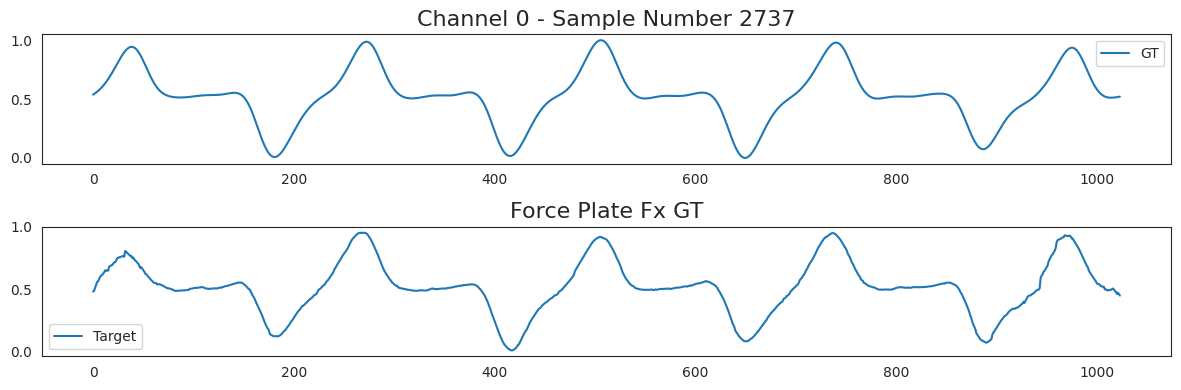

In [12]:
# Plot
data_shape = Y_Test.shape
c = random.randint(0, data_shape[2]-1)
i = random.randint(0, data_shape[0]-1)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(Y_Test[i,:,c], label='GT')
# plt.ylim(0,1)
plt.title(f"Channel {c} - Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_Pred[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Force Plate {target_quantity} GT", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Normal Evaluation

Overall outcome

In [ ]:
Evaluation_Metrics(Y_Test, Y_Pred, sub_labels, weight_array)
# Evaluation_Metrics(Y_Test, Y_Test_insole, sub_labels, weight_array)

Modewise Result (Walk or Run)

In [ ]:
mode_IDs = np.int_(np.unique(mode_labels))
for i in range(0,len(mode_IDs)):
    current_mode_ID = mode_IDs[i]
    current_mode_indices = np.where(mode_labels == current_mode_ID)[0]
    current_mode_X_Test = np.take(X_Test, current_mode_indices, axis=0)
    current_mode_Y_Test = np.take(Y_Test, current_mode_indices, axis=0)
    current_mode_Y_Pred = np.take(Y_Pred, current_mode_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_mode_indices, axis=0))
    print(f'Mode ID: {current_mode_ID}')
    Evaluation_Metrics(current_mode_Y_Test, current_mode_Y_Pred, current_mode_sub_labels, weight_array)
    print('')

Subjectwise Result

In [ ]:
sub_IDs = np.int_(np.unique(sub_labels))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels == current_sub_ID)[0]
    current_sub_X_Test = np.take(X_Test, current_sub_indices, axis=0)
    current_sub_Y_Test = np.take(Y_Test, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    Evaluation_Metrics(current_sub_Y_Test, current_sub_Y_Pred, current_mode_sub_labels, weight_array)
    print('')

Speedwise Results

In [ ]:
speed_IDs = np.int_(np.unique(speed_labels))
for i in range(0,len(speed_IDs)):
    current_speed_ID = speed_IDs[i]
    current_speed_indices = np.where(speed_labels == current_speed_ID)[0]
    current_speed_X_Test = np.take(X_Test, current_speed_indices, axis=0)
    current_speed_Y_Test = np.take(Y_Test, current_speed_indices, axis=0)
    current_speed_Y_Pred = np.take(Y_Pred, current_speed_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_speed_indices, axis=0))[:,0]
    print(f'Speed ID: {current_speed_ID}')
    Evaluation_Metrics(current_speed_Y_Test, current_speed_Y_Pred, current_mode_sub_labels, weight_array)
    print('')

### Create Gait Cycles and Measure

Subject-wise + Overall

In [ ]:
MAE_as = []
MSE_as = [] 
RMSE_as = [] 
NRMSE_as = []
R2C_as = []
PCC_as = [] 
CS_as = []
DSC_as = []
IoU_as = []
sub_IDs = np.int_(np.unique(sub_labels))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels == current_sub_ID)[0]
    current_sub_Y_Test = np.take(Y_Test, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred, current_sub_indices, axis=0)
    current_sub_Y_Test_Fx = np.take(Y_Test_Fx, current_sub_indices, axis=0)
    current_sub_Y_Pred_Fx = np.take(Y_Pred_Fx, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    offset = 100
    GT_data_current_FindPeaks = current_sub_Y_Test_Fx
    PD_data_current_FindPeaks = current_sub_Y_Pred_Fx
    GT_data_current = current_sub_Y_Test
    PD_data_current = current_sub_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    sub_label_Templates = []
    for i in range(0,data_shape[0]):
        current_sub_label = sub_labels[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                sub_label_Templates.append(current_sub_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd, current_sub_ID, weight_array)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
    print('')
print(f'MAE Error: {round(np.mean(MAE_as), 3)} +/- {round(np.std(MAE_as), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as), 3)} +/- {round(np.std(MSE_as), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as), 3)} +/- {round(np.std(RMSE_as), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as), 3)} +/- {round(np.std(NRMSE_as), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as)*100, 3)}% +/- {round(np.std(R2C_as)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as)*100, 3)}% +/- {round(np.std(PCC_as)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as)*100, 3)}% +/- {round(np.std(CS_as)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as)*100, 4)}%')

### Left and Right Foot Combined

In [ ]:
target_quantity = 'Fx'
model = 'IMUNet'
num_channels = 16
channel_info = 'All'
movement_type = 'combined_insole_FP'

In [43]:
# Left Leg/Foot
data_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_LL.h5'), 'r')
X_Test_LL = data_LL['X_Test']
Y_Test_LL = data_LL['Y_Test']
Y_Pred_LL = data_LL['Y_Pred']
sub_labels_LL = data_LL['sub_labels']
speed_labels_LL = data_LL['speed_labels']
mode_labels_LL = data_LL['mode_labels']
data_Fx_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/All/IMUNet_5_32_Ch16_DS1_combined_insole_FP_Fx_LL.h5'), 'r')
X_Test_Fx_LL = data_Fx_LL['X_Test']
Y_Test_Fx_LL = data_Fx_LL['Y_Test']
Y_Pred_Fx_LL = data_Fx_LL['Y_Pred']
sub_labels_Fx_LL = data_Fx_LL['sub_labels']
speed_labels_Fx_LL = data_Fx_LL['speed_labels']
mode_labels_Fx_LL = data_Fx_LL['mode_labels']
# Right Leg/Foot
data_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_RL.h5'), 'r')
X_Test_RL = data_RL['X_Test']
Y_Test_RL = data_RL['Y_Test']
Y_Pred_RL = data_RL['Y_Pred']
sub_labels_RL = data_RL['sub_labels']
speed_labels_RL = data_RL['speed_labels']
mode_labels_RL = data_RL['mode_labels']
data_Fx_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/All/IMUNet_5_32_Ch16_DS1_combined_insole_FP_Fx_RL.h5'), 'r')
X_Test_Fx_RL = data_Fx_RL['X_Test']
Y_Test_Fx_RL = data_Fx_RL['Y_Test']
Y_Pred_Fx_RL = data_Fx_RL['Y_Pred']
sub_labels_Fx_RL = data_Fx_RL['sub_labels']
speed_labels_Fx_RL = data_Fx_RL['speed_labels']
mode_labels_Fx_RL = data_Fx_RL['mode_labels']

Subject-wise + Overall

In [ ]:
# LL
MAE_as = []
MSE_as = [] 
RMSE_as = [] 
NRMSE_as = []
R2C_as = []
PCC_as = [] 
CS_as = []
DSC_as = []
IoU_as = []
print('LL')
MAE_as_LL = []
MSE_as_LL = [] 
RMSE_as_LL = [] 
NRMSE_as_LL = []
R2C_as_LL = []
PCC_as_LL = [] 
CS_as_LL = []
DSC_as_LL = []
IoU_as_LL = []
sub_IDs = np.int_(np.unique(sub_labels_LL))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels_LL == current_sub_ID)[0]
    current_sub_Y_Test = np.take(Y_Test_LL, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred_LL, current_sub_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_LL, current_sub_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_LL, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels_LL, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    offset = 100
    GT_data_current = current_sub_Y_Test
    PD_data_current = current_sub_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    sub_label_Templates = []
    for i in range(0,data_shape[0]):
        current_sub_label = sub_labels_LL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                sub_label_Templates.append(current_sub_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd, current_sub_ID, weight_array)
    MAE_as_LL.append(MAE_cs)
    MSE_as_LL.append(MSE_cs)
    RMSE_as_LL.append(RMSE_cs)
    NRMSE_as_LL.append(NRMSE_cs)
    R2C_as_LL.append(R2C_cs)
    PCC_as_LL.append(PCC_cs) 
    CS_as_LL.append(CS_cs)
    DSC_as_LL.append(DSC_cs)
    IoU_as_LL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_LL), 3)} +/- {round(np.std(MAE_as_LL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_LL), 3)} +/- {round(np.std(MSE_as_LL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_LL), 3)} +/- {round(np.std(RMSE_as_LL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_LL), 3)} +/- {round(np.std(NRMSE_as_LL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_LL)*100, 3)}% +/- {round(np.std(R2C_as_LL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_LL)*100, 3)}% +/- {round(np.std(PCC_as_LL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_LL)*100, 3)}% +/- {round(np.std(CS_as_LL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_LL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_LL)*100, 4)}%')
# RL
print('RL')
MAE_as_RL = []
MSE_as_RL = [] 
RMSE_as_RL = [] 
NRMSE_as_RL = []
R2C_as_RL = []
PCC_as_RL = [] 
CS_as_RL = []
DSC_as_RL = []
IoU_as_RL = []
sub_IDs = np.int_(np.unique(sub_labels_RL))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels_RL == current_sub_ID)[0]
    current_sub_Y_Test = np.take(Y_Test_RL, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred_RL, current_sub_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_RL, current_sub_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_RL, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels_RL, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    offset = 100
    GT_data_current = current_sub_Y_Test
    PD_data_current = current_sub_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    sub_label_Templates = []
    for i in range(0,data_shape[0]):
        current_sub_label = sub_labels_RL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                sub_label_Templates.append(current_sub_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd, current_sub_ID, weight_array)
    MAE_as_RL.append(MAE_cs)
    MSE_as_RL.append(MSE_cs)
    RMSE_as_RL.append(RMSE_cs)
    NRMSE_as_RL.append(NRMSE_cs)
    R2C_as_RL.append(R2C_cs)
    PCC_as_RL.append(PCC_cs) 
    CS_as_RL.append(CS_cs)
    DSC_as_RL.append(DSC_cs)
    IoU_as_RL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_RL), 3)} +/- {round(np.std(MAE_as_RL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_RL), 3)} +/- {round(np.std(MSE_as_RL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_RL), 3)} +/- {round(np.std(RMSE_as_RL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_RL), 3)} +/- {round(np.std(NRMSE_as_RL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_RL)*100, 3)}% +/- {round(np.std(R2C_as_RL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_RL)*100, 3)}% +/- {round(np.std(PCC_as_RL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_RL)*100, 3)}% +/- {round(np.std(CS_as_RL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_RL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_RL)*100, 4)}%')
#
print('Overall')
print(f'MAE Error: {round(np.mean(MAE_as), 3)} +/- {round(np.std(MAE_as), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as), 3)} +/- {round(np.std(MSE_as), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as), 3)} +/- {round(np.std(RMSE_as), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as), 3)} +/- {round(np.std(NRMSE_as), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as)*100, 3)}% +/- {round(np.std(R2C_as)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as)*100, 3)}% +/- {round(np.std(PCC_as)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as)*100, 3)}% +/- {round(np.std(CS_as)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as)*100, 4)}%')


Speed-wise - Overall

In [ ]:
# LL
MAE_as = []
MSE_as = [] 
RMSE_as = [] 
NRMSE_as = []
R2C_as = []
PCC_as = [] 
CS_as = []
DSC_as = []
IoU_as = []
print('LL')
MAE_as_LL = []
MSE_as_LL = [] 
RMSE_as_LL = [] 
NRMSE_as_LL = []
R2C_as_LL = []
PCC_as_LL = [] 
CS_as_LL = []
DSC_as_LL = []
IoU_as_LL = []
speed_IDs = np.unique(speed_labels_LL)
for i in range(0,len(speed_IDs)):
    current_speed_ID = speed_IDs[i]
    current_speed_indices = np.where(speed_labels_LL == current_speed_ID)[0]
    # print(current_speed_indices.shape)
    current_speed_Y_Test = np.take(Y_Test_LL, current_speed_indices, axis=0)
    current_speed_Y_Pred = np.take(Y_Pred_LL, current_speed_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_LL, current_speed_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_LL, current_speed_indices, axis=0)
    current_mode_speed_labels = np.take(speed_labels_LL, current_speed_indices, axis=0)[:,0]
    print(f'Speed ID: {current_speed_ID}')
    offset = 100
    GT_data_current = current_speed_Y_Test
    PD_data_current = current_speed_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    speed_label_Templates = []
    for i in range(0,data_shape[0]):
        current_speed_label = speed_labels_LL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                speed_label_Templates.append(current_speed_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd)
    MAE_as_LL.append(MAE_cs)
    MSE_as_LL.append(MSE_cs)
    RMSE_as_LL.append(RMSE_cs)
    NRMSE_as_LL.append(NRMSE_cs)
    R2C_as_LL.append(R2C_cs)
    PCC_as_LL.append(PCC_cs) 
    CS_as_LL.append(CS_cs)
    DSC_as_LL.append(DSC_cs)
    IoU_as_LL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_LL), 3)} +/- {round(np.std(MAE_as_LL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_LL), 3)} +/- {round(np.std(MSE_as_LL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_LL), 3)} +/- {round(np.std(RMSE_as_LL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_LL), 3)} +/- {round(np.std(NRMSE_as_LL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_LL)*100, 3)}% +/- {round(np.std(R2C_as_LL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_LL)*100, 3)}% +/- {round(np.std(PCC_as_LL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_LL)*100, 3)}% +/- {round(np.std(CS_as_LL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_LL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_LL)*100, 4)}%')
# RL
print(' ')
print('RL')
MAE_as_RL = []
MSE_as_RL = [] 
RMSE_as_RL = [] 
NRMSE_as_RL = []
R2C_as_RL = []
PCC_as_RL = [] 
CS_as_RL = []
DSC_as_RL = []
IoU_as_RL = []
speed_IDs = np.unique(speed_labels_RL)
for i in range(0,len(speed_IDs)):
    current_speed_ID = speed_IDs[i]
    current_speed_indices = np.where(speed_labels_RL == current_speed_ID)[0]
    current_speed_Y_Test = np.take(Y_Test_RL, current_speed_indices, axis=0)
    current_speed_Y_Pred = np.take(Y_Pred_RL, current_speed_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_RL, current_speed_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_RL, current_speed_indices, axis=0)
    current_sub_labels = np.take(sub_labels_RL, current_speed_indices, axis=0)[:,0]
    print(f'Speed ID: {current_speed_ID}')
    offset = 100
    GT_data_current = current_speed_Y_Test
    PD_data_current = current_speed_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    speed_label_Templates = []
    for i in range(0,data_shape[0]):
        current_speed_label = speed_labels_RL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                speed_label_Templates.append(current_speed_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd)
    MAE_as_RL.append(MAE_cs)
    MSE_as_RL.append(MSE_cs)
    RMSE_as_RL.append(RMSE_cs)
    NRMSE_as_RL.append(NRMSE_cs)
    R2C_as_RL.append(R2C_cs)
    PCC_as_RL.append(PCC_cs) 
    CS_as_RL.append(CS_cs)
    DSC_as_RL.append(DSC_cs)
    IoU_as_RL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_RL), 3)} +/- {round(np.std(MAE_as_RL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_RL), 3)} +/- {round(np.std(MSE_as_RL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_RL), 3)} +/- {round(np.std(RMSE_as_RL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_RL), 3)} +/- {round(np.std(NRMSE_as_RL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_RL)*100, 3)}% +/- {round(np.std(R2C_as_RL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_RL)*100, 3)}% +/- {round(np.std(PCC_as_RL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_RL)*100, 3)}% +/- {round(np.std(CS_as_RL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_RL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_RL)*100, 4)}%')
#
print(' ')
print('Overall')
print(f'MAE Error: {round(np.mean(MAE_as), 3)} +/- {round(np.std(MAE_as), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as), 3)} +/- {round(np.std(MSE_as), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as), 3)} +/- {round(np.std(RMSE_as), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as), 3)} +/- {round(np.std(NRMSE_as), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as)*100, 3)}% +/- {round(np.std(R2C_as)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as)*100, 3)}% +/- {round(np.std(PCC_as)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as)*100, 3)}% +/- {round(np.std(CS_as)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as)*100, 4)}%')

### Right and Left Feet Combined - Optimized Layout

In [30]:
target_quantity = 'CoPz'
model = 'IMUNet'
num_channels_LL = 6
num_channels_RL = 6
channel_info = '10_90'
movement_type = 'combined_insole_FP_10_90'

In [31]:
# Left Leg/Foot
data_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels_LL}_DS1_{movement_type}_{target_quantity}_LL.h5'), 'r')
X_Test_LL = data_LL['X_Test']
Y_Test_LL = data_LL['Y_Test']
Y_Pred_LL = data_LL['Y_Pred']
sub_labels_LL = data_LL['sub_labels']
speed_labels_LL = data_LL['speed_labels']
mode_labels_LL = data_LL['mode_labels']
data_Fx_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch6_DS1_{movement_type}_Fx_LL.h5'), 'r')
X_Test_Fx_LL = data_Fx_LL['X_Test']
Y_Test_Fx_LL = data_Fx_LL['Y_Test']
Y_Pred_Fx_LL = data_Fx_LL['Y_Pred']
sub_labels_Fx_LL = data_Fx_LL['sub_labels']
speed_labels_Fx_LL = data_Fx_LL['speed_labels']
mode_labels_Fx_LL = data_Fx_LL['mode_labels']
# Right Leg/Foot
data_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels_RL}_DS1_{movement_type}_{target_quantity}_RL.h5'), 'r')
X_Test_RL = data_RL['X_Test']
Y_Test_RL = data_RL['Y_Test']
Y_Pred_RL = data_RL['Y_Pred']
sub_labels_RL = data_RL['sub_labels']
speed_labels_RL = data_RL['speed_labels']
mode_labels_RL = data_RL['mode_labels']
data_Fx_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch6_DS1_{movement_type}_Fx_RL.h5'), 'r')
X_Test_Fx_RL = data_Fx_RL['X_Test']
Y_Test_Fx_RL = data_Fx_RL['Y_Test']
Y_Pred_Fx_RL = data_Fx_RL['Y_Pred']
sub_labels_Fx_RL = data_Fx_RL['sub_labels']
speed_labels_Fx_RL = data_Fx_RL['speed_labels']
mode_labels_Fx_RL = data_Fx_RL['mode_labels']

Subject wise - Overall

In [ ]:
# LL
MAE_as = []
MSE_as = [] 
RMSE_as = [] 
NRMSE_as = []
R2C_as = []
PCC_as = [] 
CS_as = []
DSC_as = []
IoU_as = []
print('LL')
MAE_as_LL = []
MSE_as_LL = [] 
RMSE_as_LL = [] 
NRMSE_as_LL = []
R2C_as_LL = []
PCC_as_LL = [] 
CS_as_LL = []
DSC_as_LL = []
IoU_as_LL = []
sub_IDs = np.int_(np.unique(sub_labels_LL))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels_LL == current_sub_ID)[0]
    current_sub_Y_Test = np.take(Y_Test_LL, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred_LL, current_sub_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_LL, current_sub_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_LL, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels_LL, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    offset = 100
    GT_data_current = current_sub_Y_Test
    PD_data_current = current_sub_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    sub_label_Templates = []
    for i in range(0,data_shape[0]):
        current_sub_label = sub_labels_LL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                sub_label_Templates.append(current_sub_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd, current_sub_ID, weight_array)
    MAE_as_LL.append(MAE_cs)
    MSE_as_LL.append(MSE_cs)
    RMSE_as_LL.append(RMSE_cs)
    NRMSE_as_LL.append(NRMSE_cs)
    R2C_as_LL.append(R2C_cs)
    PCC_as_LL.append(PCC_cs) 
    CS_as_LL.append(CS_cs)
    DSC_as_LL.append(DSC_cs)
    IoU_as_LL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_LL), 3)} +/- {round(np.std(MAE_as_LL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_LL), 3)} +/- {round(np.std(MSE_as_LL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_LL), 3)} +/- {round(np.std(RMSE_as_LL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_LL), 3)} +/- {round(np.std(NRMSE_as_LL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_LL)*100, 3)}% +/- {round(np.std(R2C_as_LL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_LL)*100, 3)}% +/- {round(np.std(PCC_as_LL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_LL)*100, 3)}% +/- {round(np.std(CS_as_LL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_LL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_LL)*100, 4)}%')
# RL
print('RL')
MAE_as_RL = []
MSE_as_RL = [] 
RMSE_as_RL = [] 
NRMSE_as_RL = []
R2C_as_RL = []
PCC_as_RL = [] 
CS_as_RL = []
DSC_as_RL = []
IoU_as_RL = []
sub_IDs = np.int_(np.unique(sub_labels_RL))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels_RL == current_sub_ID)[0]
    current_sub_Y_Test = np.take(Y_Test_RL, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred_RL, current_sub_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_RL, current_sub_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_RL, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels_RL, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    offset = 100
    GT_data_current = current_sub_Y_Test
    PD_data_current = current_sub_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    sub_label_Templates = []
    for i in range(0,data_shape[0]):
        current_sub_label = sub_labels_RL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                sub_label_Templates.append(current_sub_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd, current_sub_ID, weight_array)
    MAE_as_RL.append(MAE_cs)
    MSE_as_RL.append(MSE_cs)
    RMSE_as_RL.append(RMSE_cs)
    NRMSE_as_RL.append(NRMSE_cs)
    R2C_as_RL.append(R2C_cs)
    PCC_as_RL.append(PCC_cs) 
    CS_as_RL.append(CS_cs)
    DSC_as_RL.append(DSC_cs)
    IoU_as_RL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_RL), 3)} +/- {round(np.std(MAE_as_RL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_RL), 3)} +/- {round(np.std(MSE_as_RL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_RL), 3)} +/- {round(np.std(RMSE_as_RL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_RL), 3)} +/- {round(np.std(NRMSE_as_RL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_RL)*100, 3)}% +/- {round(np.std(R2C_as_RL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_RL)*100, 3)}% +/- {round(np.std(PCC_as_RL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_RL)*100, 3)}% +/- {round(np.std(CS_as_RL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_RL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_RL)*100, 4)}%')
#
print('Overall')
print(f'MAE Error: {round(np.mean(MAE_as), 3)} +/- {round(np.std(MAE_as), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as), 3)} +/- {round(np.std(MSE_as), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as), 3)} +/- {round(np.std(RMSE_as), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as), 3)} +/- {round(np.std(NRMSE_as), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as)*100, 3)}% +/- {round(np.std(R2C_as)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as)*100, 3)}% +/- {round(np.std(PCC_as)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as)*100, 3)}% +/- {round(np.std(CS_as)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as)*100, 4)}%')


Speed wise - Overall

In [32]:
# LL
MAE_as = []
MSE_as = [] 
RMSE_as = [] 
NRMSE_as = []
R2C_as = []
PCC_as = [] 
CS_as = []
DSC_as = []
IoU_as = []
print('LL')
MAE_as_LL = []
MSE_as_LL = [] 
RMSE_as_LL = [] 
NRMSE_as_LL = []
R2C_as_LL = []
PCC_as_LL = [] 
CS_as_LL = []
DSC_as_LL = []
IoU_as_LL = []
speed_IDs = np.unique(speed_labels_LL)
for i in range(0,len(speed_IDs)):
    current_speed_ID = speed_IDs[i]
    current_speed_indices = np.where(speed_labels_LL == current_speed_ID)[0]
    # print(current_speed_indices.shape)
    current_speed_Y_Test = np.take(Y_Test_LL, current_speed_indices, axis=0)
    current_speed_Y_Pred = np.take(Y_Pred_LL, current_speed_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_LL, current_speed_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_LL, current_speed_indices, axis=0)
    current_mode_speed_labels = np.take(speed_labels_LL, current_speed_indices, axis=0)[:,0]
    print(f'Speed ID: {current_speed_ID}')
    offset = 100
    GT_data_current = current_speed_Y_Test
    PD_data_current = current_speed_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    speed_label_Templates = []
    for i in range(0,data_shape[0]):
        current_speed_label = speed_labels_LL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                speed_label_Templates.append(current_speed_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd)
    MAE_as_LL.append(MAE_cs)
    MSE_as_LL.append(MSE_cs)
    RMSE_as_LL.append(RMSE_cs)
    NRMSE_as_LL.append(NRMSE_cs)
    R2C_as_LL.append(R2C_cs)
    PCC_as_LL.append(PCC_cs) 
    CS_as_LL.append(CS_cs)
    DSC_as_LL.append(DSC_cs)
    IoU_as_LL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_LL), 3)} +/- {round(np.std(MAE_as_LL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_LL), 3)} +/- {round(np.std(MSE_as_LL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_LL), 3)} +/- {round(np.std(RMSE_as_LL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_LL), 3)} +/- {round(np.std(NRMSE_as_LL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_LL)*100, 3)}% +/- {round(np.std(R2C_as_LL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_LL)*100, 3)}% +/- {round(np.std(PCC_as_LL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_LL)*100, 3)}% +/- {round(np.std(CS_as_LL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_LL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_LL)*100, 4)}%')
# RL
print(' ')
print('RL')
MAE_as_RL = []
MSE_as_RL = [] 
RMSE_as_RL = [] 
NRMSE_as_RL = []
R2C_as_RL = []
PCC_as_RL = [] 
CS_as_RL = []
DSC_as_RL = []
IoU_as_RL = []
speed_IDs = np.unique(speed_labels_RL)
for i in range(0,len(speed_IDs)):
    current_speed_ID = speed_IDs[i]
    current_speed_indices = np.where(speed_labels_RL == current_speed_ID)[0]
    current_speed_Y_Test = np.take(Y_Test_RL, current_speed_indices, axis=0)
    current_speed_Y_Pred = np.take(Y_Pred_RL, current_speed_indices, axis=0)
    GT_data_current_FindPeaks = np.take(Y_Test_Fx_RL, current_speed_indices, axis=0)
    PD_data_current_FindPeaks = np.take(Y_Pred_Fx_RL, current_speed_indices, axis=0)
    current_sub_labels = np.take(sub_labels_RL, current_speed_indices, axis=0)[:,0]
    print(f'Speed ID: {current_speed_ID}')
    offset = 100
    GT_data_current = current_speed_Y_Test
    PD_data_current = current_speed_Y_Pred
    data_shape = GT_data_current.shape
    GT_data_current_Templates = []
    PD_data_current_Templates = []
    speed_label_Templates = []
    for i in range(0,data_shape[0]):
        current_speed_label = speed_labels_RL[i,0]
        GT_data_current_temp = GT_data_current[i,:,0]
        PD_data_current_temp = PD_data_current[i,:,0]
        GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
        PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
        peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
        peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
        for ii in range(0,len(peaks_gt)-1):
            try:
                GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
                GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
                GT_data_current_Templates.append(GT_data_current_Template_Temp)
                PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
                PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
                PD_data_current_Templates.append(PD_data_current_Template_Temp)
                speed_label_Templates.append(current_speed_label)
            except:
                continue
    Y_Test_Templates = np.array(GT_data_current_Templates)
    mean_gt = np.mean(Y_Test_Templates, axis=0)
    std_gt = np.std(Y_Test_Templates, axis=0)
    Y_Pred_Templates = np.array(PD_data_current_Templates)
    mean_pd = np.mean(Y_Pred_Templates, axis=0)
    std_pd = np.std(Y_Pred_Templates, axis=0)
    pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
    MAE_cs, MSE_cs, RMSE_cs, NRMSE_cs, R2C_cs, PCC_cs, CS_cs, DSC_cs, IoU_cs = Evaluation_Metrics_V2(mean_gt, mean_pd)
    MAE_as_RL.append(MAE_cs)
    MSE_as_RL.append(MSE_cs)
    RMSE_as_RL.append(RMSE_cs)
    NRMSE_as_RL.append(NRMSE_cs)
    R2C_as_RL.append(R2C_cs)
    PCC_as_RL.append(PCC_cs) 
    CS_as_RL.append(CS_cs)
    DSC_as_RL.append(DSC_cs)
    IoU_as_RL.append(IoU_cs)
    MAE_as.append(MAE_cs)
    MSE_as.append(MSE_cs)
    RMSE_as.append(RMSE_cs)
    NRMSE_as.append(NRMSE_cs)
    R2C_as.append(R2C_cs)
    PCC_as.append(PCC_cs) 
    CS_as.append(CS_cs)
    DSC_as.append(DSC_cs)
    IoU_as.append(IoU_cs)
print(f'MAE Error: {round(np.mean(MAE_as_RL), 3)} +/- {round(np.std(MAE_as_RL), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as_RL), 3)} +/- {round(np.std(MSE_as_RL), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as_RL), 3)} +/- {round(np.std(RMSE_as_RL), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as_RL), 3)} +/- {round(np.std(NRMSE_as_RL), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as_RL)*100, 3)}% +/- {round(np.std(R2C_as_RL)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as_RL)*100, 3)}% +/- {round(np.std(PCC_as_RL)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as_RL)*100, 3)}% +/- {round(np.std(CS_as_RL)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as_RL)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as_RL)*100, 4)}%')
#
print(' ')
print('Overall')
print(f'MAE Error: {round(np.mean(MAE_as), 3)} +/- {round(np.std(MAE_as), 3)}')
print(f'MSE Error: {round(np.mean(MSE_as), 3)} +/- {round(np.std(MSE_as), 3)}')
print(f'RMSE Error: {round(np.mean(RMSE_as), 3)} +/- {round(np.std(RMSE_as), 3)}')
print(f'Normalized RMSE Error: {round(np.mean(NRMSE_as), 3)} +/- {round(np.std(NRMSE_as), 3)}')
print(f'R-squared (R²) Score: {round(np.mean(R2C_as)*100, 3)}% +/- {round(np.std(R2C_as)*100, 3)}')
print(f'Pearson Correlation (PCC): {round(np.mean(PCC_as)*100, 3)}% +/- {round(np.std(PCC_as)*100, 3)}')
print(f'Cosine Similarity: {round(np.mean(CS_as)*100, 3)}% +/- {round(np.std(CS_as)*100, 3)}')
print(f'DSC or Dice Score: {round(np.mean(DSC_as)*100, 4)}%')
print(f'IoU or Jaccard Score: {round(np.mean(IoU_as)*100, 4)}%')

LL
Speed ID: 9.0
MAE Error: 0.0331
MSE Error: 0.0015
RMSE Error: 0.0393
Normalized RMSE Error: 0.0393
R-squared (R²) Score: 0.6159
Pearson Correlation (PCC): 0.8171
Cosine Similarity: 0.9975
DSC or Dice Score: 96.672%
IoU or Jaccard Score: 93.641%
Speed ID: 18.0
MAE Error: 0.0184
MSE Error: 0.0007
RMSE Error: 0.0263
Normalized RMSE Error: 0.0263
R-squared (R²) Score: 0.961
Pearson Correlation (PCC): 0.9833
Cosine Similarity: 0.9988
DSC or Dice Score: 98.189%
IoU or Jaccard Score: 96.495%
Speed ID: 27.0
MAE Error: 0.0143
MSE Error: 0.0004
RMSE Error: 0.0209
Normalized RMSE Error: 0.0209
R-squared (R²) Score: 0.9817
Pearson Correlation (PCC): 0.9923
Cosine Similarity: 0.9994
DSC or Dice Score: 98.593%
IoU or Jaccard Score: 97.265%
Speed ID: 36.0
MAE Error: 0.0183
MSE Error: 0.0005
RMSE Error: 0.0226
Normalized RMSE Error: 0.0226
R-squared (R²) Score: 0.9816
Pearson Correlation (PCC): 0.9966
Cosine Similarity: 0.9997
DSC or Dice Score: 98.313%
IoU or Jaccard Score: 96.71%
Speed ID: 45.0
M

## Save Outcomes as CSV

In [ ]:
target_quantity = 'Fy'
model = 'IMUNet'
num_channels = 16
channel_info = 'All'
movement_type = 'combined_insole_FP'

In [82]:
# Left Leg/Foot
data_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_LL.h5'), 'r')
X_Test_LL = data_LL['X_Test']
Y_Test_LL = data_LL['Y_Test']
Y_Pred_LL = data_LL['Y_Pred']
sub_labels_LL = data_LL['sub_labels']
speed_labels_LL = data_LL['speed_labels']
mode_labels_LL = data_LL['mode_labels']
# Right Leg/Foot
data_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_RL.h5'), 'r')
X_Test_RL = data_RL['X_Test']
Y_Test_RL = data_RL['Y_Test']
Y_Pred_RL = data_RL['Y_Pred']
sub_labels_RL = data_RL['sub_labels']
speed_labels_RL = data_RL['speed_labels']
mode_labels_RL = data_RL['mode_labels']
# Combine
X_Test = np.concatenate((X_Test_LL,X_Test_RL), axis=0)
Y_Test = np.concatenate((Y_Test_LL,Y_Test_RL), axis=0)
Y_Pred = np.concatenate((Y_Pred_LL,Y_Pred_RL), axis=0)
sub_labels = np.concatenate((sub_labels_LL,sub_labels_RL), axis=0)
speed_labels = np.concatenate((speed_labels_LL,speed_labels_RL), axis=0)
mode_labels = np.concatenate((mode_labels_LL,mode_labels_RL), axis=0)
foot_label_LL = np.zeros((Y_Test_LL.shape[0],1), dtype=int)
foot_label_RL = np.ones((Y_Test_RL.shape[0],1), dtype=int)
foot_label = np.concatenate((foot_label_LL, foot_label_RL), axis=0)
print(X_Test.shape)
print(Y_Test.shape)
print(Y_Pred.shape)
print(sub_labels.shape)
print(speed_labels.shape)
print(mode_labels.shape)
print(foot_label.shape)
print(np.unique(foot_label))

(9474, 1024, 16)
(9474, 1024, 1)
(9474, 1024, 1)
(9474, 1)
(9474, 1)
(9474, 1)
(9474, 1)
[0 1]


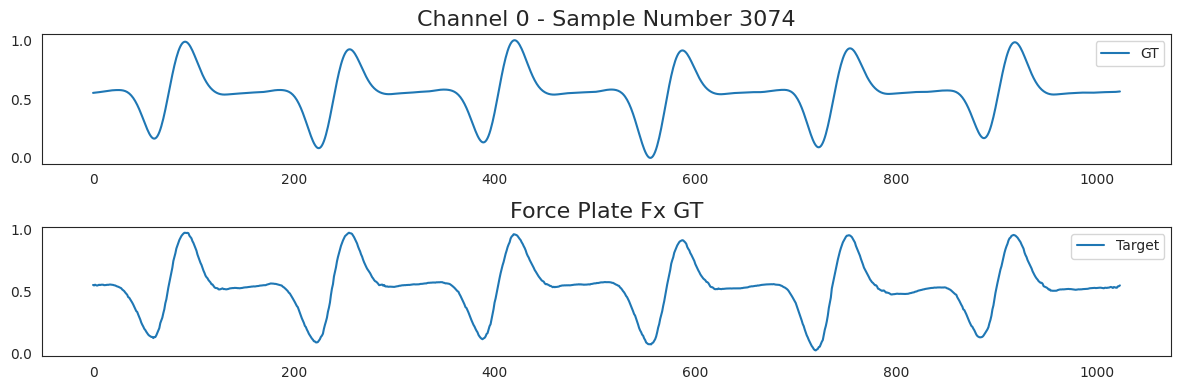

In [83]:
# Plot
data_shape = Y_Test.shape
c = random.randint(0, data_shape[2]-1)
i = random.randint(0, data_shape[0]-1)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(Y_Test[i,:,c], label='GT')
# plt.ylim(0,1)
plt.title(f"Channel {c} - Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_Pred[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Force Plate {target_quantity} GT", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

In [84]:
# Evaluate
MAE_ALL = []
MSE_ALL = []
RMSE_ALL = []
NRMSE_ALL = []
R2C_ALL = []
PCC_ALL = []
CS_ALL = []
DSC_ALL = []
for i in range(0,Y_Test.shape[0]):
    # print(i)
    temp_GT = np.expand_dims(Y_Test[i,:,:], axis=0)
    temp_pred = np.expand_dims(Y_Pred[i,:,:], axis=0)
    temp_sub_label = np.expand_dims(sub_labels[i,:], axis=0)
    MAE_, MSE_, RMSE_, NRMSE_, R2C_, PCC_, CS_, DSC_ = Evaluation_Metrics(temp_GT, temp_pred, temp_sub_label, weight_array)
    MAE_ALL.append(np.round(MAE_,3))
    MSE_ALL.append(np.round(MSE_,3))
    RMSE_ALL.append(np.round(RMSE_,3))
    NRMSE_ALL.append(np.round(NRMSE_,3))
    R2C_ALL.append(np.round(R2C_,3))
    PCC_ALL.append(np.round(PCC_,3))
    CS_ALL.append(np.round(CS_,3))
    DSC_ALL.append(np.round(DSC_,3))
    #
MAE_ALL = np.array(MAE_ALL)
MSE_ALL = np.array(MSE_ALL)
RMSE_ALL = np.array(RMSE_ALL)
NRMSE_ALL = np.array(NRMSE_ALL)
R2C_ALL = np.array(R2C_ALL)
PCC_ALL = np.array(PCC_ALL)
CS_ALL = np.array(CS_ALL)
DSC_ALL = np.array(DSC_ALL)
print(MAE_ALL.shape)

(9474,)


In [85]:
COLUMN_NAMES=['Sub_ID','Foot','Mode','Speed','MAE','RMSE','NRMSE','PCC','CS','DSC']
blank_df = pd.DataFrame(columns=COLUMN_NAMES)
blank_df['Sub_ID'] = sub_labels[:,0]
blank_df['Foot'] = foot_label[:,0]
blank_df['Mode'] = mode_labels[:,0]
blank_df['Speed'] = speed_labels[:,0]/10
blank_df['MAE'] = MAE_ALL
blank_df['RMSE'] = RMSE_ALL
blank_df['NRMSE'] = NRMSE_ALL
blank_df['PCC'] = PCC_ALL
blank_df['CS'] = CS_ALL
blank_df['DSC'] = DSC_ALL
#
filepath = Path(f'Insole_to_3DGRFMCoP_Results_{target_quantity}.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
blank_df.to_csv(filepath, index=False)
# Print/Show the DataFrame
print(blank_df.shape)
blank_df.head(10)

(9474, 10)


Sub_ID  Foot  Mode  Speed     MAE    RMSE  NRMSE     PCC      CS     DSC
0    11.0     0   0.0    0.9   6.244   8.646  0.139  88.771  96.901  88.817
1    11.0     0   0.0    0.9   6.060   8.251  0.132  85.183  97.055  89.478
2    11.0     0   0.0    0.9   6.833   9.492  0.152  81.833  96.886  88.794
3    11.0     0   0.0    0.9   7.844  10.029  0.161  81.395  96.457  86.784
4    11.0     0   0.0    0.9   8.237  10.904  0.175  72.761  94.344  85.161
5    11.0     0   0.0    0.9   8.198  11.236  0.180  70.404  94.537  86.253
6    11.0     0   0.0    0.9  10.673  13.730  0.220  57.530  91.376  81.438
7    11.0     0   0.0    0.9   9.965  12.884  0.206  60.444  92.051  81.262
8    11.0     0   0.0    0.9   9.305  11.880  0.190  73.945  94.350  83.936
9    11.0     0   0.0    0.9  10.045  12.244  0.196  79.733  93.647  80.603

In [86]:
# scatter plot with scatter() function
# transparency with "alpha"
# bubble size with "s"
df = pd.read_csv(f'Insole_to_3DGRFMCoP_Results_{target_quantity}.csv', index_col=None)
Sub_ID_ = np.array(df['Sub_ID'])
Foot_ = np.array(df['Foot'])
Mode_ = np.array(df['Mode'])
Speed_ = np.array(df['Speed'])
MAE_ = np.array(df['MAE'])
RMSE_ = np.array(df['RMSE'])
NRMSE_ = np.array(df['NRMSE'])
PCC_ = np.array(df['PCC'])
CS_ = np.array(df['CS'])
DSC_ = np.array(df['DSC'])
speed_list = np.unique(Speed_)
Indices_09_LL = np.where((Speed_ == 0.9) & (Foot_ == 0))[0]
Indices_18_LL = np.where((Speed_ == 1.8) & (Foot_ == 0))[0]
Indices_27_LL = np.where((Speed_ == 2.7) & (Foot_ == 0))[0]
Indices_36_LL = np.where((Speed_ == 3.6) & (Foot_ == 0))[0]
Indices_45_LL = np.where((Speed_ == 4.5) & (Foot_ == 0))[0]
Indices_54_LL = np.where((Speed_ == 5.4) & (Foot_ == 0))[0]
Indices_63_LL = np.where((Speed_ == 6.3) & (Foot_ == 0))[0]
Indices_81_LL = np.where((Speed_ == 8.1) & (Foot_ == 0))[0]
Indices_99_LL = np.where((Speed_ == 9.9) & (Foot_ == 0))[0]
#
Indices_09_RL = np.where((Speed_ == 0.9) & (Foot_ == 1))[0]
Indices_18_RL = np.where((Speed_ == 1.8) & (Foot_ == 1))[0]
Indices_27_RL = np.where((Speed_ == 2.7) & (Foot_ == 1))[0]
Indices_36_RL = np.where((Speed_ == 3.6) & (Foot_ == 1))[0]
Indices_45_RL = np.where((Speed_ == 4.5) & (Foot_ == 1))[0]
Indices_54_RL = np.where((Speed_ == 5.4) & (Foot_ == 1))[0]
Indices_63_RL = np.where((Speed_ == 6.3) & (Foot_ == 1))[0]
Indices_81_RL = np.where((Speed_ == 8.1) & (Foot_ == 1))[0]
Indices_99_RL = np.where((Speed_ == 9.9) & (Foot_ == 1))[0]
#
PCC_09_LL = np.mean(np.take(PCC_, Indices_09_LL, axis=0))
PCC_09_RL = np.mean(np.take(PCC_, Indices_09_RL, axis=0))
PCC_18_LL = np.mean(np.take(PCC_, Indices_18_LL, axis=0))
PCC_18_RL = np.mean(np.take(PCC_, Indices_18_RL, axis=0))
PCC_27_LL = np.mean(np.take(PCC_, Indices_27_LL, axis=0))
PCC_27_RL = np.mean(np.take(PCC_, Indices_27_RL, axis=0))
PCC_36_LL = np.mean(np.take(PCC_, Indices_36_LL, axis=0))
PCC_36_RL = np.mean(np.take(PCC_, Indices_36_RL, axis=0))
PCC_45_LL = np.mean(np.take(PCC_, Indices_45_LL, axis=0))
PCC_45_RL = np.mean(np.take(PCC_, Indices_45_RL, axis=0))
PCC_54_LL = np.mean(np.take(PCC_, Indices_54_LL, axis=0))
PCC_54_RL = np.mean(np.take(PCC_, Indices_54_RL, axis=0))
PCC_63_LL = np.mean(np.take(PCC_, Indices_63_LL, axis=0))
PCC_63_RL = np.mean(np.take(PCC_, Indices_63_RL, axis=0))
PCC_81_LL = np.mean(np.take(PCC_, Indices_81_LL, axis=0))
PCC_81_RL = np.mean(np.take(PCC_, Indices_81_RL, axis=0))
PCC_99_LL = np.mean(np.take(PCC_, Indices_99_LL, axis=0))
PCC_99_RL = np.mean(np.take(PCC_, Indices_99_RL, axis=0))

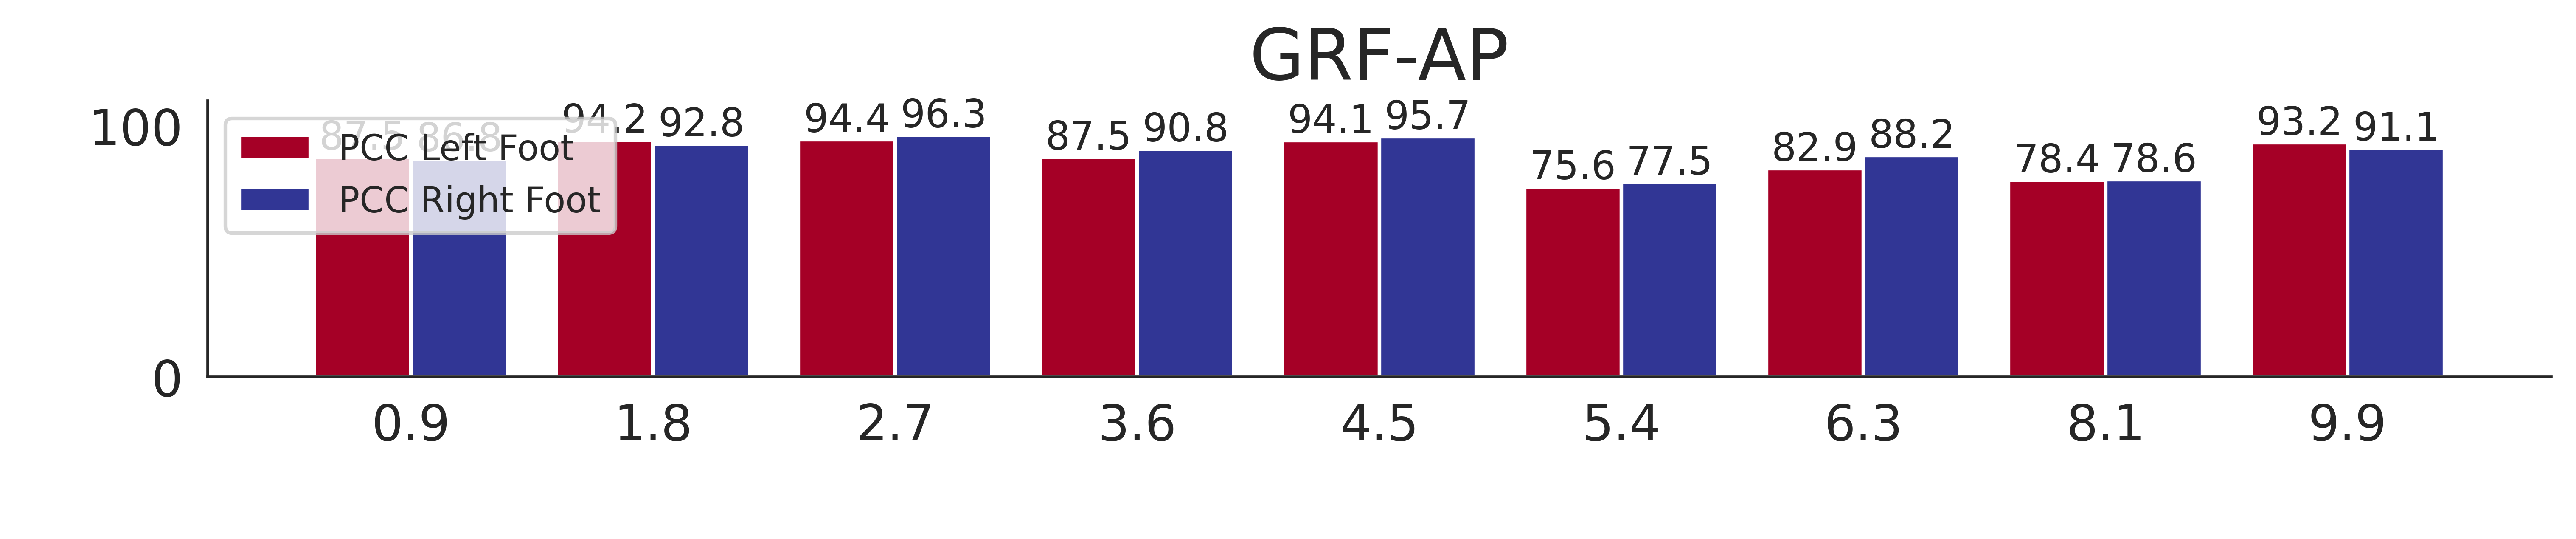

In [ ]:
# Bar Chart
speeds_ = ("0.9", "1.8", "2.7", "3.6", "4.5", "5.4", "6.3", "8.1", "9.9")
results = {
    'PCC Left Foot': (PCC_09_LL,PCC_18_LL,PCC_27_LL,PCC_36_LL,PCC_45_LL,PCC_54_LL,PCC_63_LL,PCC_81_LL,PCC_99_LL),
    'PCC Right Foot': (PCC_09_RL,PCC_18_RL,PCC_27_RL,PCC_36_RL,PCC_45_RL,PCC_54_RL,PCC_63_RL,PCC_81_RL,PCC_99_RL),
}
x = np.arange(len(speeds_))*0.5  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
palette = ["#a50026","#313695","#a50026","#313695","#a50026","#313695","#a50026","#313695","#a50026","#313695","#a50026","#313695",
           "#a50026","#313695","#a50026","#313695","#a50026","#313695",]

fig, ax = plt.subplots(figsize=(10,2), dpi=600, layout='constrained')

for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 1), width, label=attribute, color=palette)
    ax.bar_label(rects, padding=0, fontsize = 11)
    multiplier += 1
    
for bars, colors in zip(ax.containers, (palette[0::2], palette[1::2])):
     for bar, color in zip(bars, colors):
          bar.set_facecolor(color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(' ', fontsize = 14)
ax.set_ylabel(' ', fontsize = 14)
ax.set_title('GRF-AP', fontsize = 20)
ax.set_xticks(x + (width/2), speeds_)
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.legend(loc='upper left', ncols=1, fontsize = 10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_ylim(0, 110)
plt.show()

 # Plot GRF Plots for Article

In [4]:
model = 'IMUNet'
num_channels = 16
channel_info = 'All'
movement_type = 'combined_insole_FP'

In [5]:
# Left Leg/Foot Fx
data_Fx_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Fx_LL.h5'), 'r')
X_Test_LL = data_Fx_LL['X_Test']
Y_Test_Fx_LL = data_Fx_LL['Y_Test']
Y_Pred_Fx_LL = data_Fx_LL['Y_Pred']
sub_labels_LL = np.array(data_Fx_LL['sub_labels'])
speed_labels_LL = np.array(data_Fx_LL['speed_labels'])/10
mode_labels_LL = np.array(data_Fx_LL['mode_labels'])
# Right Leg/Foot Fx
data_Fx_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Fx_RL.h5'), 'r')
X_Test_RL = data_Fx_RL['X_Test']
Y_Test_Fx_RL = data_Fx_RL['Y_Test']
Y_Pred_Fx_RL = data_Fx_RL['Y_Pred']
sub_labels_RL = np.array(data_Fx_RL['sub_labels'])
speed_labels_RL = np.array(data_Fx_RL['speed_labels'])/10
mode_labels_RL = np.array(data_Fx_RL['mode_labels'])
# Left Leg/Foot Fy
data_Fy_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Fy_LL.h5'), 'r')
Y_Test_Fy_LL = data_Fy_LL['Y_Test']
Y_Pred_Fy_LL = data_Fy_LL['Y_Pred']
# Right Leg/Foot Fy
data_Fy_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Fy_RL.h5'), 'r')
Y_Test_Fy_RL = data_Fy_RL['Y_Test']
Y_Pred_Fy_RL = data_Fy_RL['Y_Pred']
# Left Leg/Foot Fz
data_Fz_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Fz_LL.h5'), 'r')
Y_Test_Fz_LL = data_Fz_LL['Y_Test']
Y_Pred_Fz_LL = data_Fz_LL['Y_Pred']
# Right Leg/Foot Fz
data_Fz_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Fz_RL.h5'), 'r')
Y_Test_Fz_RL = data_Fz_RL['Y_Test']
Y_Pred_Fz_RL = data_Fz_RL['Y_Pred']
# Left Leg/Foot Mx
data_Mx_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Mx_LL.h5'), 'r')
Y_Test_Mx_LL = data_Mx_LL['Y_Test']
Y_Pred_Mx_LL = data_Mx_LL['Y_Pred']
# Right Leg/Foot Mx
data_Mx_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Mx_RL.h5'), 'r')
Y_Test_Mx_RL = data_Mx_RL['Y_Test']
Y_Pred_Mx_RL = data_Mx_RL['Y_Pred']
# Left Leg/Foot My
data_My_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_My_LL.h5'), 'r')
Y_Test_My_LL = data_My_LL['Y_Test']
Y_Pred_My_LL = data_My_LL['Y_Pred']
# Right Leg/Foot My
data_My_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_My_RL.h5'), 'r')
Y_Test_My_RL = data_My_RL['Y_Test']
Y_Pred_My_RL = data_My_RL['Y_Pred']
# Left Leg/Foot Mz
data_Mz_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Mz_LL.h5'), 'r')
Y_Test_Mz_LL = data_Mz_LL['Y_Test']
Y_Pred_Mz_LL = data_Mz_LL['Y_Pred']
# Right Leg/Foot Mz
data_Mz_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_Mz_RL.h5'), 'r')
Y_Test_Mz_RL = data_Mz_RL['Y_Test']
Y_Pred_Mz_RL = data_Mz_RL['Y_Pred']
# Left Leg/Foot CoPx
data_CoPx_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_CoPx_LL.h5'), 'r')
Y_Test_CoPx_LL = data_CoPx_LL['Y_Test']
Y_Pred_CoPx_LL = data_CoPx_LL['Y_Pred']
# Right Leg/Foot CoPx
data_CoPx_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_CoPx_RL.h5'), 'r')
Y_Test_CoPx_RL = data_CoPx_RL['Y_Test']
Y_Pred_CoPx_RL = data_CoPx_RL['Y_Pred']
# Left Leg/Foot CoPz
data_CoPz_LL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/LL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_CoPz_LL.h5'), 'r')
Y_Test_CoPz_LL = data_CoPz_LL['Y_Test']
Y_Pred_CoPz_LL = data_CoPz_LL['Y_Pred']
# Right Leg/Foot CoPz
data_CoPz_RL = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/RL/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_CoPz_RL.h5'), 'r')
Y_Test_CoPz_RL = data_CoPz_RL['Y_Test']
Y_Pred_CoPz_RL = data_CoPz_RL['Y_Pred']

/tmp/ipykernel_2124977/4110286733.py:39: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


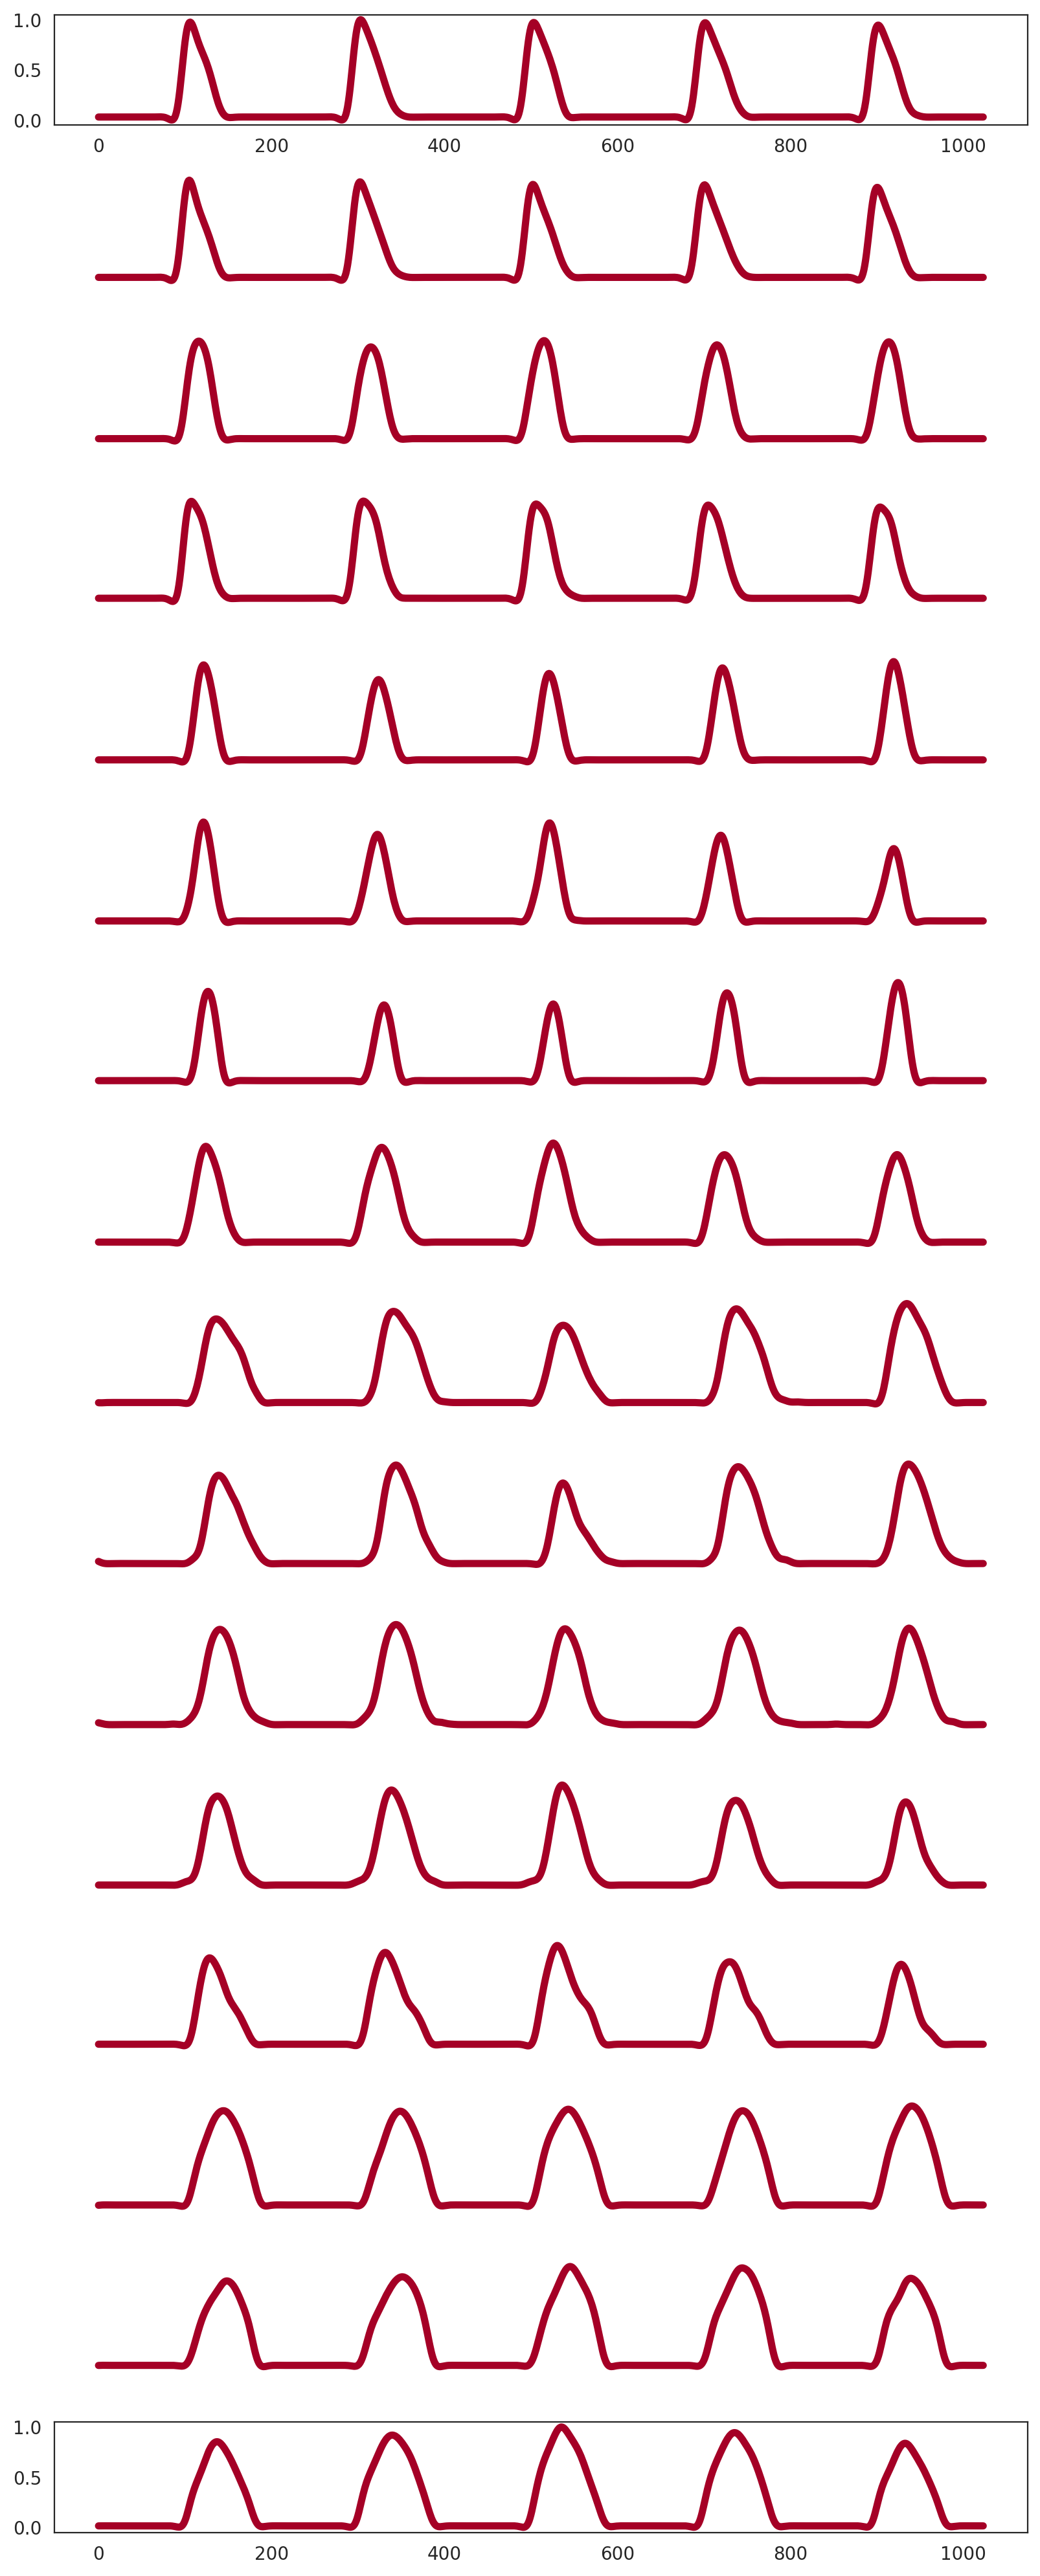

In [48]:
# Plot
X_Data = X_Test_LL
data_shape = X_Data.shape
i = random.randint(0, data_shape[0]-1)
fig, ax = plt.subplots(16, figsize=(8,20), dpi=200, layout='constrained', facecolor='white')
fig.patch.set_alpha(0)
ax[0].plot(X_Data[i,:,0], label='sensor 1', color='#a50026', linewidth=4)
# ax[0].axis('off')
ax[1].plot(X_Data[i,:,1], label='sensor 2', color='#a50026', linewidth=4)
ax[1].axis('off')
ax[2].plot(X_Data[i,:,2], label='sensor 3', color='#a50026', linewidth=4)
ax[2].axis('off')
ax[3].plot(X_Data[i,:,3], label='sensor 4', color='#a50026', linewidth=4)
ax[3].axis('off')
ax[4].plot(X_Data[i,:,4], label='sensor 5', color='#a50026', linewidth=4)
ax[4].axis('off')
ax[5].plot(X_Data[i,:,5], label='sensor 6', color='#a50026', linewidth=4)
ax[5].axis('off')
ax[6].plot(X_Data[i,:,6], label='sensor 7', color='#a50026', linewidth=4)
ax[6].axis('off')
ax[7].plot(X_Data[i,:,7], label='sensor 8', color='#a50026', linewidth=4)
ax[7].axis('off')
ax[8].plot(X_Data[i,:,8], label='sensor 9', color='#a50026', linewidth=4)
ax[8].axis('off')
ax[9].plot(X_Data[i,:,9], label='sensor 10', color='#a50026', linewidth=4)
ax[9].axis('off')
ax[10].plot(X_Data[i,:,10], label='sensor 11', color='#a50026', linewidth=4)
ax[10].axis('off')
ax[11].plot(X_Data[i,:,11], label='sensor 12', color='#a50026', linewidth=4)
ax[11].axis('off')
ax[12].plot(X_Data[i,:,12], label='sensor 13', color='#a50026', linewidth=4)
ax[12].axis('off')
ax[13].plot(X_Data[i,:,13], label='sensor 14', color='#a50026', linewidth=4)
ax[13].axis('off')
ax[14].plot(X_Data[i,:,14], label='sensor 15', color='#a50026', linewidth=4)
ax[14].axis('off')
ax[15].plot(X_Data[i,:,15], label='sensor 16', color='#a50026', linewidth=4)
# ax[15].axis('off')
fig.tight_layout()
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

## Subject-wise plots

### Fx

In [6]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_Fx_04_LL_WK = np.take(Y_Test_Fx_LL, Indices_04_LL_WK, axis=0)
Y_Pred_Fx_04_LL_WK = np.take(Y_Pred_Fx_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_Fx_04_LL_WK.shape)
print(Y_Pred_Fx_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_Fx_04_LL_RN = np.take(Y_Test_Fx_LL, Indices_04_LL_RN, axis=0)
Y_Pred_Fx_04_LL_RN = np.take(Y_Pred_Fx_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_Fx_04_LL_RN.shape)
print(Y_Pred_Fx_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_Fx_04_RL_WK = np.take(Y_Test_Fx_RL, Indices_04_RL_WK, axis=0)
Y_Pred_Fx_04_RL_WK = np.take(Y_Pred_Fx_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_Fx_04_RL_WK.shape)
print(Y_Pred_Fx_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_Fx_04_RL_RN = np.take(Y_Test_Fx_RL, Indices_04_RL_RN, axis=0)
Y_Pred_Fx_04_RL_RN = np.take(Y_Pred_Fx_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_Fx_04_RL_RN.shape)
print(Y_Pred_Fx_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_Fx_05_LL_WK = np.take(Y_Test_Fx_LL, Indices_05_LL_WK, axis=0)
Y_Pred_Fx_05_LL_WK = np.take(Y_Pred_Fx_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_Fx_05_LL_WK.shape)
print(Y_Pred_Fx_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_Fx_05_LL_RN = np.take(Y_Test_Fx_LL, Indices_05_LL_RN, axis=0)
Y_Pred_Fx_05_LL_RN = np.take(Y_Pred_Fx_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_Fx_05_LL_RN.shape)
print(Y_Pred_Fx_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_Fx_05_RL_WK = np.take(Y_Test_Fx_RL, Indices_05_RL_WK, axis=0)
Y_Pred_Fx_05_RL_WK = np.take(Y_Pred_Fx_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_Fx_05_RL_WK.shape)
print(Y_Pred_Fx_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_Fx_05_RL_RN = np.take(Y_Test_Fx_RL, Indices_05_RL_RN, axis=0)
Y_Pred_Fx_05_RL_RN = np.take(Y_Pred_Fx_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_Fx_05_RL_RN.shape)
print(Y_Pred_Fx_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_Fx_06_LL_WK = np.take(Y_Test_Fx_LL, Indices_06_LL_WK, axis=0)
Y_Pred_Fx_06_LL_WK = np.take(Y_Pred_Fx_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_Fx_06_LL_WK.shape)
print(Y_Pred_Fx_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_Fx_06_LL_RN = np.take(Y_Test_Fx_LL, Indices_06_LL_RN, axis=0)
Y_Pred_Fx_06_LL_RN = np.take(Y_Pred_Fx_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_Fx_06_LL_RN.shape)
print(Y_Pred_Fx_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_Fx_06_RL_WK = np.take(Y_Test_Fx_RL, Indices_06_RL_WK, axis=0)
Y_Pred_Fx_06_RL_WK = np.take(Y_Pred_Fx_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_Fx_06_RL_WK.shape)
print(Y_Pred_Fx_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_Fx_06_RL_RN = np.take(Y_Test_Fx_RL, Indices_06_RL_RN, axis=0)
Y_Pred_Fx_06_RL_RN = np.take(Y_Pred_Fx_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_Fx_06_RL_RN.shape)
print(Y_Pred_Fx_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_Fx_07_LL_WK = np.take(Y_Test_Fx_LL, Indices_07_LL_WK, axis=0)
Y_Pred_Fx_07_LL_WK = np.take(Y_Pred_Fx_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_Fx_07_LL_WK.shape)
print(Y_Pred_Fx_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_Fx_07_LL_RN = np.take(Y_Test_Fx_LL, Indices_07_LL_RN, axis=0)
Y_Pred_Fx_07_LL_RN = np.take(Y_Pred_Fx_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_Fx_07_LL_RN.shape)
print(Y_Pred_Fx_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_Fx_07_RL_WK = np.take(Y_Test_Fx_RL, Indices_07_RL_WK, axis=0)
Y_Pred_Fx_07_RL_WK = np.take(Y_Pred_Fx_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_Fx_07_RL_WK.shape)
print(Y_Pred_Fx_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_Fx_07_RL_RN = np.take(Y_Test_Fx_RL, Indices_07_RL_RN, axis=0)
Y_Pred_Fx_07_RL_RN = np.take(Y_Pred_Fx_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_Fx_07_RL_RN.shape)
print(Y_Pred_Fx_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_Fx_08_LL_WK = np.take(Y_Test_Fx_LL, Indices_08_LL_WK, axis=0)
Y_Pred_Fx_08_LL_WK = np.take(Y_Pred_Fx_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_Fx_08_LL_WK.shape)
print(Y_Pred_Fx_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_Fx_08_LL_RN = np.take(Y_Test_Fx_LL, Indices_08_LL_RN, axis=0)
Y_Pred_Fx_08_LL_RN = np.take(Y_Pred_Fx_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_Fx_08_LL_RN.shape)
print(Y_Pred_Fx_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_Fx_08_RL_WK = np.take(Y_Test_Fx_RL, Indices_08_RL_WK, axis=0)
Y_Pred_Fx_08_RL_WK = np.take(Y_Pred_Fx_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_Fx_08_RL_WK.shape)
print(Y_Pred_Fx_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_Fx_08_RL_RN = np.take(Y_Test_Fx_RL, Indices_08_RL_RN, axis=0)
Y_Pred_Fx_08_RL_RN = np.take(Y_Pred_Fx_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_Fx_08_RL_RN.shape)
print(Y_Pred_Fx_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_Fx_09_LL_WK = np.take(Y_Test_Fx_LL, Indices_09_LL_WK, axis=0)
Y_Pred_Fx_09_LL_WK = np.take(Y_Pred_Fx_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_Fx_09_LL_WK.shape)
print(Y_Pred_Fx_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_Fx_09_LL_RN = np.take(Y_Test_Fx_LL, Indices_09_LL_RN, axis=0)
Y_Pred_Fx_09_LL_RN = np.take(Y_Pred_Fx_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_Fx_09_LL_RN.shape)
print(Y_Pred_Fx_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_Fx_09_RL_WK = np.take(Y_Test_Fx_RL, Indices_09_RL_WK, axis=0)
Y_Pred_Fx_09_RL_WK = np.take(Y_Pred_Fx_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_Fx_09_RL_WK.shape)
print(Y_Pred_Fx_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_Fx_09_RL_RN = np.take(Y_Test_Fx_RL, Indices_09_RL_RN, axis=0)
Y_Pred_Fx_09_RL_RN = np.take(Y_Pred_Fx_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_Fx_09_RL_RN.shape)
print(Y_Pred_Fx_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_Fx_10_LL_WK = np.take(Y_Test_Fx_LL, Indices_10_LL_WK, axis=0)
Y_Pred_Fx_10_LL_WK = np.take(Y_Pred_Fx_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_Fx_10_LL_WK.shape)
print(Y_Pred_Fx_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_Fx_10_LL_RN = np.take(Y_Test_Fx_LL, Indices_10_LL_RN, axis=0)
Y_Pred_Fx_10_LL_RN = np.take(Y_Pred_Fx_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_Fx_10_LL_RN.shape)
print(Y_Pred_Fx_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_Fx_10_RL_WK = np.take(Y_Test_Fx_RL, Indices_10_RL_WK, axis=0)
Y_Pred_Fx_10_RL_WK = np.take(Y_Pred_Fx_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_Fx_10_RL_WK.shape)
print(Y_Pred_Fx_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_Fx_10_RL_RN = np.take(Y_Test_Fx_RL, Indices_10_RL_RN, axis=0)
Y_Pred_Fx_10_RL_RN = np.take(Y_Pred_Fx_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_Fx_10_RL_RN.shape)
print(Y_Pred_Fx_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_Fx_11_LL_WK = np.take(Y_Test_Fx_LL, Indices_11_LL_WK, axis=0)
Y_Pred_Fx_11_LL_WK = np.take(Y_Pred_Fx_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_Fx_11_LL_WK.shape)
print(Y_Pred_Fx_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_Fx_11_LL_RN = np.take(Y_Test_Fx_LL, Indices_11_LL_RN, axis=0)
Y_Pred_Fx_11_LL_RN = np.take(Y_Pred_Fx_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_Fx_11_LL_RN.shape)
print(Y_Pred_Fx_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_Fx_11_RL_WK = np.take(Y_Test_Fx_RL, Indices_11_RL_WK, axis=0)
Y_Pred_Fx_11_RL_WK = np.take(Y_Pred_Fx_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_Fx_11_RL_WK.shape)
print(Y_Pred_Fx_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_Fx_11_RL_RN = np.take(Y_Test_Fx_RL, Indices_11_RL_RN, axis=0)
Y_Pred_Fx_11_RL_RN = np.take(Y_Pred_Fx_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_Fx_11_RL_RN.shape)
print(Y_Pred_Fx_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_Fx_12_LL_WK = np.take(Y_Test_Fx_LL, Indices_12_LL_WK, axis=0)
Y_Pred_Fx_12_LL_WK = np.take(Y_Pred_Fx_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_Fx_12_LL_WK.shape)
print(Y_Pred_Fx_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_Fx_12_LL_RN = np.take(Y_Test_Fx_LL, Indices_12_LL_RN, axis=0)
Y_Pred_Fx_12_LL_RN = np.take(Y_Pred_Fx_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_Fx_12_LL_RN.shape)
print(Y_Pred_Fx_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_Fx_12_RL_WK = np.take(Y_Test_Fx_RL, Indices_12_RL_WK, axis=0)
Y_Pred_Fx_12_RL_WK = np.take(Y_Pred_Fx_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_Fx_12_RL_WK.shape)
print(Y_Pred_Fx_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_Fx_12_RL_RN = np.take(Y_Test_Fx_RL, Indices_12_RL_RN, axis=0)
Y_Pred_Fx_12_RL_RN = np.take(Y_Pred_Fx_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_Fx_12_RL_RN.shape)
print(Y_Pred_Fx_12_RL_RN.shape)

Sub 04
(375, 1024, 1)
(375, 1024, 1)
(187, 1024, 1)
(187, 1024, 1)
(375, 1024, 1)
(375, 1024, 1)
(187, 1024, 1)
(187, 1024, 1)
Sub 05
(382, 1024, 1)
(382, 1024, 1)
(173, 1024, 1)
(173, 1024, 1)
(382, 1024, 1)
(382, 1024, 1)
(173, 1024, 1)
(173, 1024, 1)
Sub 06
(362, 1024, 1)
(362, 1024, 1)
(169, 1024, 1)
(169, 1024, 1)
(362, 1024, 1)
(362, 1024, 1)
(169, 1024, 1)
(169, 1024, 1)
Sub 07
(348, 1024, 1)
(348, 1024, 1)
(172, 1024, 1)
(172, 1024, 1)
(348, 1024, 1)
(348, 1024, 1)
(172, 1024, 1)
(172, 1024, 1)
Sub 08
(344, 1024, 1)
(344, 1024, 1)
(171, 1024, 1)
(171, 1024, 1)
(344, 1024, 1)
(344, 1024, 1)
(171, 1024, 1)
(171, 1024, 1)
Sub 09
(340, 1024, 1)
(340, 1024, 1)
(170, 1024, 1)
(170, 1024, 1)
(340, 1024, 1)
(340, 1024, 1)
(170, 1024, 1)
(170, 1024, 1)
Sub 10
(340, 1024, 1)
(340, 1024, 1)
(169, 1024, 1)
(169, 1024, 1)
(340, 1024, 1)
(340, 1024, 1)
(169, 1024, 1)
(169, 1024, 1)
Sub 11
(342, 1024, 1)
(342, 1024, 1)
(171, 1024, 1)
(171, 1024, 1)
(342, 1024, 1)
(342, 1024, 1)
(171, 1024, 1)

### Fy

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_Fy_04_LL_WK = np.take(Y_Test_Fy_LL, Indices_04_LL_WK, axis=0)
Y_Pred_Fy_04_LL_WK = np.take(Y_Pred_Fy_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_Fy_04_LL_WK.shape)
print(Y_Pred_Fy_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_Fy_04_LL_RN = np.take(Y_Test_Fy_LL, Indices_04_LL_RN, axis=0)
Y_Pred_Fy_04_LL_RN = np.take(Y_Pred_Fy_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_Fy_04_LL_RN.shape)
print(Y_Pred_Fy_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_Fy_04_RL_WK = np.take(Y_Test_Fy_RL, Indices_04_RL_WK, axis=0)
Y_Pred_Fy_04_RL_WK = np.take(Y_Pred_Fy_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_Fy_04_RL_WK.shape)
print(Y_Pred_Fy_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_Fy_04_RL_RN = np.take(Y_Test_Fy_RL, Indices_04_RL_RN, axis=0)
Y_Pred_Fy_04_RL_RN = np.take(Y_Pred_Fy_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_Fy_04_RL_RN.shape)
print(Y_Pred_Fy_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_Fy_05_LL_WK = np.take(Y_Test_Fy_LL, Indices_05_LL_WK, axis=0)
Y_Pred_Fy_05_LL_WK = np.take(Y_Pred_Fy_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_Fy_05_LL_WK.shape)
print(Y_Pred_Fy_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_Fy_05_LL_RN = np.take(Y_Test_Fy_LL, Indices_05_LL_RN, axis=0)
Y_Pred_Fy_05_LL_RN = np.take(Y_Pred_Fy_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_Fy_05_LL_RN.shape)
print(Y_Pred_Fy_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_Fy_05_RL_WK = np.take(Y_Test_Fy_RL, Indices_05_RL_WK, axis=0)
Y_Pred_Fy_05_RL_WK = np.take(Y_Pred_Fy_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_Fy_05_RL_WK.shape)
print(Y_Pred_Fy_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_Fy_05_RL_RN = np.take(Y_Test_Fy_RL, Indices_05_RL_RN, axis=0)
Y_Pred_Fy_05_RL_RN = np.take(Y_Pred_Fy_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_Fy_05_RL_RN.shape)
print(Y_Pred_Fy_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_Fy_06_LL_WK = np.take(Y_Test_Fy_LL, Indices_06_LL_WK, axis=0)
Y_Pred_Fy_06_LL_WK = np.take(Y_Pred_Fy_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_Fy_06_LL_WK.shape)
print(Y_Pred_Fy_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_Fy_06_LL_RN = np.take(Y_Test_Fy_LL, Indices_06_LL_RN, axis=0)
Y_Pred_Fy_06_LL_RN = np.take(Y_Pred_Fy_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_Fy_06_LL_RN.shape)
print(Y_Pred_Fy_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_Fy_06_RL_WK = np.take(Y_Test_Fy_RL, Indices_06_RL_WK, axis=0)
Y_Pred_Fy_06_RL_WK = np.take(Y_Pred_Fy_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_Fy_06_RL_WK.shape)
print(Y_Pred_Fy_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_Fy_06_RL_RN = np.take(Y_Test_Fy_RL, Indices_06_RL_RN, axis=0)
Y_Pred_Fy_06_RL_RN = np.take(Y_Pred_Fy_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_Fy_06_RL_RN.shape)
print(Y_Pred_Fy_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_Fy_07_LL_WK = np.take(Y_Test_Fy_LL, Indices_07_LL_WK, axis=0)
Y_Pred_Fy_07_LL_WK = np.take(Y_Pred_Fy_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_Fy_07_LL_WK.shape)
print(Y_Pred_Fy_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_Fy_07_LL_RN = np.take(Y_Test_Fy_LL, Indices_07_LL_RN, axis=0)
Y_Pred_Fy_07_LL_RN = np.take(Y_Pred_Fy_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_Fy_07_LL_RN.shape)
print(Y_Pred_Fy_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_Fy_07_RL_WK = np.take(Y_Test_Fy_RL, Indices_07_RL_WK, axis=0)
Y_Pred_Fy_07_RL_WK = np.take(Y_Pred_Fy_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_Fy_07_RL_WK.shape)
print(Y_Pred_Fy_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_Fy_07_RL_RN = np.take(Y_Test_Fy_RL, Indices_07_RL_RN, axis=0)
Y_Pred_Fy_07_RL_RN = np.take(Y_Pred_Fy_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_Fy_07_RL_RN.shape)
print(Y_Pred_Fy_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_Fy_08_LL_WK = np.take(Y_Test_Fy_LL, Indices_08_LL_WK, axis=0)
Y_Pred_Fy_08_LL_WK = np.take(Y_Pred_Fy_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_Fy_08_LL_WK.shape)
print(Y_Pred_Fy_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_Fy_08_LL_RN = np.take(Y_Test_Fy_LL, Indices_08_LL_RN, axis=0)
Y_Pred_Fy_08_LL_RN = np.take(Y_Pred_Fy_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_Fy_08_LL_RN.shape)
print(Y_Pred_Fy_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_Fy_08_RL_WK = np.take(Y_Test_Fy_RL, Indices_08_RL_WK, axis=0)
Y_Pred_Fy_08_RL_WK = np.take(Y_Pred_Fy_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_Fy_08_RL_WK.shape)
print(Y_Pred_Fy_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_Fy_08_RL_RN = np.take(Y_Test_Fy_RL, Indices_08_RL_RN, axis=0)
Y_Pred_Fy_08_RL_RN = np.take(Y_Pred_Fy_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_Fy_08_RL_RN.shape)
print(Y_Pred_Fy_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_Fy_09_LL_WK = np.take(Y_Test_Fy_LL, Indices_09_LL_WK, axis=0)
Y_Pred_Fy_09_LL_WK = np.take(Y_Pred_Fy_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_Fy_09_LL_WK.shape)
print(Y_Pred_Fy_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_Fy_09_LL_RN = np.take(Y_Test_Fy_LL, Indices_09_LL_RN, axis=0)
Y_Pred_Fy_09_LL_RN = np.take(Y_Pred_Fy_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_Fy_09_LL_RN.shape)
print(Y_Pred_Fy_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_Fy_09_RL_WK = np.take(Y_Test_Fy_RL, Indices_09_RL_WK, axis=0)
Y_Pred_Fy_09_RL_WK = np.take(Y_Pred_Fy_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_Fy_09_RL_WK.shape)
print(Y_Pred_Fy_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_Fy_09_RL_RN = np.take(Y_Test_Fy_RL, Indices_09_RL_RN, axis=0)
Y_Pred_Fy_09_RL_RN = np.take(Y_Pred_Fy_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_Fy_09_RL_RN.shape)
print(Y_Pred_Fy_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_Fy_10_LL_WK = np.take(Y_Test_Fy_LL, Indices_10_LL_WK, axis=0)
Y_Pred_Fy_10_LL_WK = np.take(Y_Pred_Fy_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_Fy_10_LL_WK.shape)
print(Y_Pred_Fy_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_Fy_10_LL_RN = np.take(Y_Test_Fy_LL, Indices_10_LL_RN, axis=0)
Y_Pred_Fy_10_LL_RN = np.take(Y_Pred_Fy_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_Fy_10_LL_RN.shape)
print(Y_Pred_Fy_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_Fy_10_RL_WK = np.take(Y_Test_Fy_RL, Indices_10_RL_WK, axis=0)
Y_Pred_Fy_10_RL_WK = np.take(Y_Pred_Fy_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_Fy_10_RL_WK.shape)
print(Y_Pred_Fy_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_Fy_10_RL_RN = np.take(Y_Test_Fy_RL, Indices_10_RL_RN, axis=0)
Y_Pred_Fy_10_RL_RN = np.take(Y_Pred_Fy_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_Fy_10_RL_RN.shape)
print(Y_Pred_Fy_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_Fy_11_LL_WK = np.take(Y_Test_Fy_LL, Indices_11_LL_WK, axis=0)
Y_Pred_Fy_11_LL_WK = np.take(Y_Pred_Fy_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_Fy_11_LL_WK.shape)
print(Y_Pred_Fy_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_Fy_11_LL_RN = np.take(Y_Test_Fy_LL, Indices_11_LL_RN, axis=0)
Y_Pred_Fy_11_LL_RN = np.take(Y_Pred_Fy_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_Fy_11_LL_RN.shape)
print(Y_Pred_Fy_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_Fy_11_RL_WK = np.take(Y_Test_Fy_RL, Indices_11_RL_WK, axis=0)
Y_Pred_Fy_11_RL_WK = np.take(Y_Pred_Fy_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_Fy_11_RL_WK.shape)
print(Y_Pred_Fy_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_Fy_11_RL_RN = np.take(Y_Test_Fy_RL, Indices_11_RL_RN, axis=0)
Y_Pred_Fy_11_RL_RN = np.take(Y_Pred_Fy_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_Fy_11_RL_RN.shape)
print(Y_Pred_Fy_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_Fy_12_LL_WK = np.take(Y_Test_Fy_LL, Indices_12_LL_WK, axis=0)
Y_Pred_Fy_12_LL_WK = np.take(Y_Pred_Fy_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_Fy_12_LL_WK.shape)
print(Y_Pred_Fy_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_Fy_12_LL_RN = np.take(Y_Test_Fy_LL, Indices_12_LL_RN, axis=0)
Y_Pred_Fy_12_LL_RN = np.take(Y_Pred_Fy_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_Fy_12_LL_RN.shape)
print(Y_Pred_Fy_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_Fy_12_RL_WK = np.take(Y_Test_Fy_RL, Indices_12_RL_WK, axis=0)
Y_Pred_Fy_12_RL_WK = np.take(Y_Pred_Fy_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_Fy_12_RL_WK.shape)
print(Y_Pred_Fy_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_Fy_12_RL_RN = np.take(Y_Test_Fy_RL, Indices_12_RL_RN, axis=0)
Y_Pred_Fy_12_RL_RN = np.take(Y_Pred_Fy_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_Fy_12_RL_RN.shape)
print(Y_Pred_Fy_12_RL_RN.shape)

### Fy - Insole

In [8]:
# Import
fl_Data_Walk = h5py.File(os.path.join('Data_Preprocessed_Walk.mat'), 'r')
fl_Data_Run = h5py.File(os.path.join('Data_Preprocessed_Run.mat'), 'r')
print(fl_Data_Walk.keys())
Y_Data_Labels = np.array(fl_Data_Walk['label_Insole'])
# Left Leg (LL) Insole VGRF Data per sensor
Y_Data_insole_LL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_LL']),0,2)
Y_Data_insole_LL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_LL']),0,2)
Y_Data_insole_LL = np.concatenate((Y_Data_insole_LL_Walk, Y_Data_insole_LL_Run), axis=0)
Y_Data_insole_LL = Y_Data_insole_LL[:,:,22:23]
print(Y_Data_insole_LL.shape)
# Right Leg (RL) Insole VGRF Data per sensor
Y_Data_insole_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_RL']),0,2)
Y_Data_insole_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_RL']),0,2)
Y_Data_insole_RL = np.concatenate((Y_Data_insole_RL_Walk, Y_Data_insole_RL_Run), axis=0)
Y_Data_insole_RL = Y_Data_insole_RL[:,:,22:23]
print(Y_Data_insole_RL.shape)
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_Fy_04_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_Fy_04_LL_WK_insole.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_Fy_04_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_Fy_04_LL_RN_insole.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_Fy_04_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_Fy_04_RL_WK_insole.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_Fy_04_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_Fy_04_RL_RN_insole.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_Fy_05_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_Fy_05_LL_WK_insole.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_Fy_05_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_Fy_05_LL_RN_insole.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_Fy_05_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_Fy_05_RL_WK_insole.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_Fy_05_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_Fy_05_RL_RN_insole.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_Fy_06_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_Fy_06_LL_WK_insole.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_Fy_06_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_Fy_06_LL_RN_insole.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_Fy_06_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_Fy_06_RL_WK_insole.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_Fy_06_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_Fy_06_RL_RN_insole.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_Fy_07_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_Fy_07_LL_WK_insole.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_Fy_07_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_Fy_07_LL_RN_insole.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_Fy_07_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_Fy_07_RL_WK_insole.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_Fy_07_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_Fy_07_RL_RN_insole.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_Fy_08_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_Fy_08_LL_WK_insole.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_Fy_08_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_Fy_08_LL_RN_insole.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_Fy_08_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_Fy_08_RL_WK_insole.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_Fy_08_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_Fy_08_RL_RN_insole.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_Fy_09_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_Fy_09_LL_WK_insole.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_Fy_09_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_Fy_09_LL_RN_insole.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_Fy_09_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_Fy_09_RL_WK_insole.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_Fy_09_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_Fy_09_RL_RN_insole.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_Fy_10_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_Fy_10_LL_WK_insole.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_Fy_10_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_Fy_10_LL_RN_insole.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_Fy_10_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_Fy_10_RL_WK_insole.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_Fy_10_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_Fy_10_RL_RN_insole.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_Fy_11_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_Fy_11_LL_WK_insole.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_Fy_11_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_Fy_11_LL_RN_insole.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_Fy_11_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_Fy_11_RL_WK_insole.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_Fy_11_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_Fy_11_RL_RN_insole.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_Fy_12_LL_WK_insole = np.take(Y_Data_insole_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_Fy_12_LL_WK_insole.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_Fy_12_LL_RN_insole = np.take(Y_Data_insole_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_Fy_12_LL_RN_insole.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_Fy_12_RL_WK_insole = np.take(Y_Data_insole_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_Fy_12_RL_WK_insole.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_Fy_12_RL_RN_insole = np.take(Y_Data_insole_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_Fy_12_RL_RN_insole.shape)

<KeysViewHDF5 ['#refs#', '#subsystem#', 'data_CoM', 'data_EMG', 'data_Force_FP_LL', 'data_Force_FP_RL', 'data_IMU', 'data_Insole_LL', 'data_Insole_RL', 'label_EMG', 'label_FP', 'label_IMU', 'label_Insole', 'speedinfo', 'subinfo']>
(4737, 1024, 1)
(4737, 1024, 1)
Sub 04
(375, 1024, 1)
(187, 1024, 1)
(375, 1024, 1)
(187, 1024, 1)
Sub 05
(382, 1024, 1)
(173, 1024, 1)
(382, 1024, 1)
(173, 1024, 1)
Sub 06
(362, 1024, 1)
(169, 1024, 1)
(362, 1024, 1)
(169, 1024, 1)
Sub 07
(348, 1024, 1)
(172, 1024, 1)
(348, 1024, 1)
(172, 1024, 1)
Sub 08
(344, 1024, 1)
(171, 1024, 1)
(344, 1024, 1)
(171, 1024, 1)
Sub 09
(340, 1024, 1)
(170, 1024, 1)
(340, 1024, 1)
(170, 1024, 1)
Sub 10
(340, 1024, 1)
(169, 1024, 1)
(340, 1024, 1)
(169, 1024, 1)
Sub 11
(342, 1024, 1)
(171, 1024, 1)
(342, 1024, 1)
(171, 1024, 1)
Sub 12
(350, 1024, 1)
(172, 1024, 1)
(350, 1024, 1)
(172, 1024, 1)


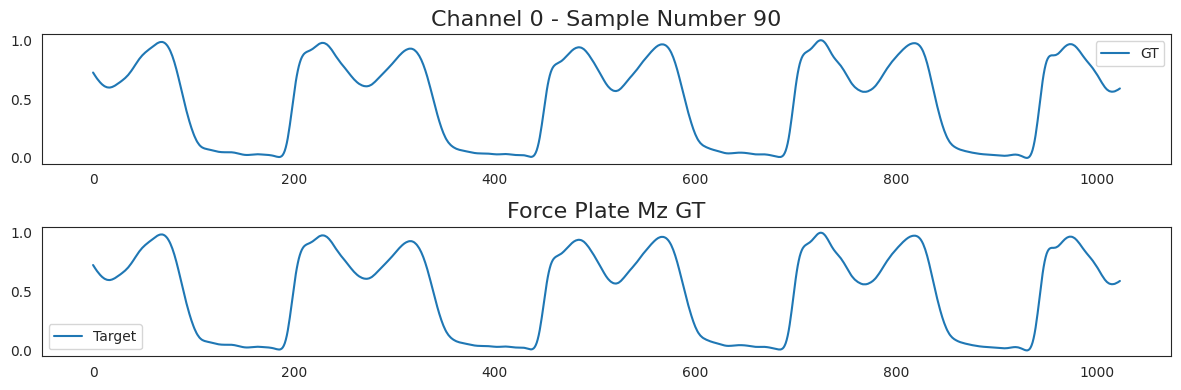

In [26]:
# Plot
data_shape = Y_Test_Fy_10_LL_WK_insole.shape
i = random.randint(0, data_shape[0]-1)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(Y_Test_Fy_10_LL_WK_insole[i,:,0], label='GT')
# plt.ylim(0,1)
plt.title(f"Channel 0 - Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_Test_Fy_10_LL_WK_insole[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Force Plate {target_quantity} GT", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Fz

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_Fz_04_LL_WK = np.take(Y_Test_Fz_LL, Indices_04_LL_WK, axis=0)
Y_Pred_Fz_04_LL_WK = np.take(Y_Pred_Fz_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_Fz_04_LL_WK.shape)
print(Y_Pred_Fz_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_Fz_04_LL_RN = np.take(Y_Test_Fz_LL, Indices_04_LL_RN, axis=0)
Y_Pred_Fz_04_LL_RN = np.take(Y_Pred_Fz_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_Fz_04_LL_RN.shape)
print(Y_Pred_Fz_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_Fz_04_RL_WK = np.take(Y_Test_Fz_RL, Indices_04_RL_WK, axis=0)
Y_Pred_Fz_04_RL_WK = np.take(Y_Pred_Fz_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_Fz_04_RL_WK.shape)
print(Y_Pred_Fz_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_Fz_04_RL_RN = np.take(Y_Test_Fz_RL, Indices_04_RL_RN, axis=0)
Y_Pred_Fz_04_RL_RN = np.take(Y_Pred_Fz_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_Fz_04_RL_RN.shape)
print(Y_Pred_Fz_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_Fz_05_LL_WK = np.take(Y_Test_Fz_LL, Indices_05_LL_WK, axis=0)
Y_Pred_Fz_05_LL_WK = np.take(Y_Pred_Fz_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_Fz_05_LL_WK.shape)
print(Y_Pred_Fz_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_Fz_05_LL_RN = np.take(Y_Test_Fz_LL, Indices_05_LL_RN, axis=0)
Y_Pred_Fz_05_LL_RN = np.take(Y_Pred_Fz_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_Fz_05_LL_RN.shape)
print(Y_Pred_Fz_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_Fz_05_RL_WK = np.take(Y_Test_Fz_RL, Indices_05_RL_WK, axis=0)
Y_Pred_Fz_05_RL_WK = np.take(Y_Pred_Fz_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_Fz_05_RL_WK.shape)
print(Y_Pred_Fz_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_Fz_05_RL_RN = np.take(Y_Test_Fz_RL, Indices_05_RL_RN, axis=0)
Y_Pred_Fz_05_RL_RN = np.take(Y_Pred_Fz_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_Fz_05_RL_RN.shape)
print(Y_Pred_Fz_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_Fz_06_LL_WK = np.take(Y_Test_Fz_LL, Indices_06_LL_WK, axis=0)
Y_Pred_Fz_06_LL_WK = np.take(Y_Pred_Fz_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_Fz_06_LL_WK.shape)
print(Y_Pred_Fz_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_Fz_06_LL_RN = np.take(Y_Test_Fz_LL, Indices_06_LL_RN, axis=0)
Y_Pred_Fz_06_LL_RN = np.take(Y_Pred_Fz_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_Fz_06_LL_RN.shape)
print(Y_Pred_Fz_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_Fz_06_RL_WK = np.take(Y_Test_Fz_RL, Indices_06_RL_WK, axis=0)
Y_Pred_Fz_06_RL_WK = np.take(Y_Pred_Fz_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_Fz_06_RL_WK.shape)
print(Y_Pred_Fz_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_Fz_06_RL_RN = np.take(Y_Test_Fz_RL, Indices_06_RL_RN, axis=0)
Y_Pred_Fz_06_RL_RN = np.take(Y_Pred_Fz_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_Fz_06_RL_RN.shape)
print(Y_Pred_Fz_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_Fz_07_LL_WK = np.take(Y_Test_Fz_LL, Indices_07_LL_WK, axis=0)
Y_Pred_Fz_07_LL_WK = np.take(Y_Pred_Fz_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_Fz_07_LL_WK.shape)
print(Y_Pred_Fz_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_Fz_07_LL_RN = np.take(Y_Test_Fz_LL, Indices_07_LL_RN, axis=0)
Y_Pred_Fz_07_LL_RN = np.take(Y_Pred_Fz_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_Fz_07_LL_RN.shape)
print(Y_Pred_Fz_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_Fz_07_RL_WK = np.take(Y_Test_Fz_RL, Indices_07_RL_WK, axis=0)
Y_Pred_Fz_07_RL_WK = np.take(Y_Pred_Fz_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_Fz_07_RL_WK.shape)
print(Y_Pred_Fz_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_Fz_07_RL_RN = np.take(Y_Test_Fz_RL, Indices_07_RL_RN, axis=0)
Y_Pred_Fz_07_RL_RN = np.take(Y_Pred_Fz_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_Fz_07_RL_RN.shape)
print(Y_Pred_Fz_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_Fz_08_LL_WK = np.take(Y_Test_Fz_LL, Indices_08_LL_WK, axis=0)
Y_Pred_Fz_08_LL_WK = np.take(Y_Pred_Fz_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_Fz_08_LL_WK.shape)
print(Y_Pred_Fz_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_Fz_08_LL_RN = np.take(Y_Test_Fz_LL, Indices_08_LL_RN, axis=0)
Y_Pred_Fz_08_LL_RN = np.take(Y_Pred_Fz_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_Fz_08_LL_RN.shape)
print(Y_Pred_Fz_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_Fz_08_RL_WK = np.take(Y_Test_Fz_RL, Indices_08_RL_WK, axis=0)
Y_Pred_Fz_08_RL_WK = np.take(Y_Pred_Fz_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_Fz_08_RL_WK.shape)
print(Y_Pred_Fz_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_Fz_08_RL_RN = np.take(Y_Test_Fz_RL, Indices_08_RL_RN, axis=0)
Y_Pred_Fz_08_RL_RN = np.take(Y_Pred_Fz_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_Fz_08_RL_RN.shape)
print(Y_Pred_Fz_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_Fz_09_LL_WK = np.take(Y_Test_Fz_LL, Indices_09_LL_WK, axis=0)
Y_Pred_Fz_09_LL_WK = np.take(Y_Pred_Fz_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_Fz_09_LL_WK.shape)
print(Y_Pred_Fz_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_Fz_09_LL_RN = np.take(Y_Test_Fz_LL, Indices_09_LL_RN, axis=0)
Y_Pred_Fz_09_LL_RN = np.take(Y_Pred_Fz_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_Fz_09_LL_RN.shape)
print(Y_Pred_Fz_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_Fz_09_RL_WK = np.take(Y_Test_Fz_RL, Indices_09_RL_WK, axis=0)
Y_Pred_Fz_09_RL_WK = np.take(Y_Pred_Fz_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_Fz_09_RL_WK.shape)
print(Y_Pred_Fz_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_Fz_09_RL_RN = np.take(Y_Test_Fz_RL, Indices_09_RL_RN, axis=0)
Y_Pred_Fz_09_RL_RN = np.take(Y_Pred_Fz_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_Fz_09_RL_RN.shape)
print(Y_Pred_Fz_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_Fz_10_LL_WK = np.take(Y_Test_Fz_LL, Indices_10_LL_WK, axis=0)
Y_Pred_Fz_10_LL_WK = np.take(Y_Pred_Fz_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_Fz_10_LL_WK.shape)
print(Y_Pred_Fz_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_Fz_10_LL_RN = np.take(Y_Test_Fz_LL, Indices_10_LL_RN, axis=0)
Y_Pred_Fz_10_LL_RN = np.take(Y_Pred_Fz_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_Fz_10_LL_RN.shape)
print(Y_Pred_Fz_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_Fz_10_RL_WK = np.take(Y_Test_Fz_RL, Indices_10_RL_WK, axis=0)
Y_Pred_Fz_10_RL_WK = np.take(Y_Pred_Fz_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_Fz_10_RL_WK.shape)
print(Y_Pred_Fz_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_Fz_10_RL_RN = np.take(Y_Test_Fz_RL, Indices_10_RL_RN, axis=0)
Y_Pred_Fz_10_RL_RN = np.take(Y_Pred_Fz_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_Fz_10_RL_RN.shape)
print(Y_Pred_Fz_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_Fz_11_LL_WK = np.take(Y_Test_Fz_LL, Indices_11_LL_WK, axis=0)
Y_Pred_Fz_11_LL_WK = np.take(Y_Pred_Fz_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_Fz_11_LL_WK.shape)
print(Y_Pred_Fz_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_Fz_11_LL_RN = np.take(Y_Test_Fz_LL, Indices_11_LL_RN, axis=0)
Y_Pred_Fz_11_LL_RN = np.take(Y_Pred_Fz_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_Fz_11_LL_RN.shape)
print(Y_Pred_Fz_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_Fz_11_RL_WK = np.take(Y_Test_Fz_RL, Indices_11_RL_WK, axis=0)
Y_Pred_Fz_11_RL_WK = np.take(Y_Pred_Fz_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_Fz_11_RL_WK.shape)
print(Y_Pred_Fz_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_Fz_11_RL_RN = np.take(Y_Test_Fz_RL, Indices_11_RL_RN, axis=0)
Y_Pred_Fz_11_RL_RN = np.take(Y_Pred_Fz_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_Fz_11_RL_RN.shape)
print(Y_Pred_Fz_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_Fz_12_LL_WK = np.take(Y_Test_Fz_LL, Indices_12_LL_WK, axis=0)
Y_Pred_Fz_12_LL_WK = np.take(Y_Pred_Fz_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_Fz_12_LL_WK.shape)
print(Y_Pred_Fz_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_Fz_12_LL_RN = np.take(Y_Test_Fz_LL, Indices_12_LL_RN, axis=0)
Y_Pred_Fz_12_LL_RN = np.take(Y_Pred_Fz_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_Fz_12_LL_RN.shape)
print(Y_Pred_Fz_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_Fz_12_RL_WK = np.take(Y_Test_Fz_RL, Indices_12_RL_WK, axis=0)
Y_Pred_Fz_12_RL_WK = np.take(Y_Pred_Fz_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_Fz_12_RL_WK.shape)
print(Y_Pred_Fz_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_Fz_12_RL_RN = np.take(Y_Test_Fz_RL, Indices_12_RL_RN, axis=0)
Y_Pred_Fz_12_RL_RN = np.take(Y_Pred_Fz_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_Fz_12_RL_RN.shape)
print(Y_Pred_Fz_12_RL_RN.shape)

### Mx

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_Mx_04_LL_WK = np.take(Y_Test_Mx_LL, Indices_04_LL_WK, axis=0)
Y_Pred_Mx_04_LL_WK = np.take(Y_Pred_Mx_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_Mx_04_LL_WK.shape)
print(Y_Pred_Mx_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_Mx_04_LL_RN = np.take(Y_Test_Mx_LL, Indices_04_LL_RN, axis=0)
Y_Pred_Mx_04_LL_RN = np.take(Y_Pred_Mx_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_Mx_04_LL_RN.shape)
print(Y_Pred_Mx_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_Mx_04_RL_WK = np.take(Y_Test_Mx_RL, Indices_04_RL_WK, axis=0)
Y_Pred_Mx_04_RL_WK = np.take(Y_Pred_Mx_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_Mx_04_RL_WK.shape)
print(Y_Pred_Mx_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_Mx_04_RL_RN = np.take(Y_Test_Mx_RL, Indices_04_RL_RN, axis=0)
Y_Pred_Mx_04_RL_RN = np.take(Y_Pred_Mx_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_Mx_04_RL_RN.shape)
print(Y_Pred_Mx_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_Mx_05_LL_WK = np.take(Y_Test_Mx_LL, Indices_05_LL_WK, axis=0)
Y_Pred_Mx_05_LL_WK = np.take(Y_Pred_Mx_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_Mx_05_LL_WK.shape)
print(Y_Pred_Mx_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_Mx_05_LL_RN = np.take(Y_Test_Mx_LL, Indices_05_LL_RN, axis=0)
Y_Pred_Mx_05_LL_RN = np.take(Y_Pred_Mx_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_Mx_05_LL_RN.shape)
print(Y_Pred_Mx_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_Mx_05_RL_WK = np.take(Y_Test_Mx_RL, Indices_05_RL_WK, axis=0)
Y_Pred_Mx_05_RL_WK = np.take(Y_Pred_Mx_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_Mx_05_RL_WK.shape)
print(Y_Pred_Mx_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_Mx_05_RL_RN = np.take(Y_Test_Mx_RL, Indices_05_RL_RN, axis=0)
Y_Pred_Mx_05_RL_RN = np.take(Y_Pred_Mx_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_Mx_05_RL_RN.shape)
print(Y_Pred_Mx_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_Mx_06_LL_WK = np.take(Y_Test_Mx_LL, Indices_06_LL_WK, axis=0)
Y_Pred_Mx_06_LL_WK = np.take(Y_Pred_Mx_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_Mx_06_LL_WK.shape)
print(Y_Pred_Mx_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_Mx_06_LL_RN = np.take(Y_Test_Mx_LL, Indices_06_LL_RN, axis=0)
Y_Pred_Mx_06_LL_RN = np.take(Y_Pred_Mx_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_Mx_06_LL_RN.shape)
print(Y_Pred_Mx_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_Mx_06_RL_WK = np.take(Y_Test_Mx_RL, Indices_06_RL_WK, axis=0)
Y_Pred_Mx_06_RL_WK = np.take(Y_Pred_Mx_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_Mx_06_RL_WK.shape)
print(Y_Pred_Mx_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_Mx_06_RL_RN = np.take(Y_Test_Mx_RL, Indices_06_RL_RN, axis=0)
Y_Pred_Mx_06_RL_RN = np.take(Y_Pred_Mx_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_Mx_06_RL_RN.shape)
print(Y_Pred_Mx_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_Mx_07_LL_WK = np.take(Y_Test_Mx_LL, Indices_07_LL_WK, axis=0)
Y_Pred_Mx_07_LL_WK = np.take(Y_Pred_Mx_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_Mx_07_LL_WK.shape)
print(Y_Pred_Mx_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_Mx_07_LL_RN = np.take(Y_Test_Mx_LL, Indices_07_LL_RN, axis=0)
Y_Pred_Mx_07_LL_RN = np.take(Y_Pred_Mx_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_Mx_07_LL_RN.shape)
print(Y_Pred_Mx_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_Mx_07_RL_WK = np.take(Y_Test_Mx_RL, Indices_07_RL_WK, axis=0)
Y_Pred_Mx_07_RL_WK = np.take(Y_Pred_Mx_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_Mx_07_RL_WK.shape)
print(Y_Pred_Mx_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_Mx_07_RL_RN = np.take(Y_Test_Mx_RL, Indices_07_RL_RN, axis=0)
Y_Pred_Mx_07_RL_RN = np.take(Y_Pred_Mx_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_Mx_07_RL_RN.shape)
print(Y_Pred_Mx_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_Mx_08_LL_WK = np.take(Y_Test_Mx_LL, Indices_08_LL_WK, axis=0)
Y_Pred_Mx_08_LL_WK = np.take(Y_Pred_Mx_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_Mx_08_LL_WK.shape)
print(Y_Pred_Mx_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_Mx_08_LL_RN = np.take(Y_Test_Mx_LL, Indices_08_LL_RN, axis=0)
Y_Pred_Mx_08_LL_RN = np.take(Y_Pred_Mx_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_Mx_08_LL_RN.shape)
print(Y_Pred_Mx_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_Mx_08_RL_WK = np.take(Y_Test_Mx_RL, Indices_08_RL_WK, axis=0)
Y_Pred_Mx_08_RL_WK = np.take(Y_Pred_Mx_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_Mx_08_RL_WK.shape)
print(Y_Pred_Mx_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_Mx_08_RL_RN = np.take(Y_Test_Mx_RL, Indices_08_RL_RN, axis=0)
Y_Pred_Mx_08_RL_RN = np.take(Y_Pred_Mx_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_Mx_08_RL_RN.shape)
print(Y_Pred_Mx_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_Mx_09_LL_WK = np.take(Y_Test_Mx_LL, Indices_09_LL_WK, axis=0)
Y_Pred_Mx_09_LL_WK = np.take(Y_Pred_Mx_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_Mx_09_LL_WK.shape)
print(Y_Pred_Mx_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_Mx_09_LL_RN = np.take(Y_Test_Mx_LL, Indices_09_LL_RN, axis=0)
Y_Pred_Mx_09_LL_RN = np.take(Y_Pred_Mx_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_Mx_09_LL_RN.shape)
print(Y_Pred_Mx_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_Mx_09_RL_WK = np.take(Y_Test_Mx_RL, Indices_09_RL_WK, axis=0)
Y_Pred_Mx_09_RL_WK = np.take(Y_Pred_Mx_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_Mx_09_RL_WK.shape)
print(Y_Pred_Mx_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_Mx_09_RL_RN = np.take(Y_Test_Mx_RL, Indices_09_RL_RN, axis=0)
Y_Pred_Mx_09_RL_RN = np.take(Y_Pred_Mx_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_Mx_09_RL_RN.shape)
print(Y_Pred_Mx_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_Mx_10_LL_WK = np.take(Y_Test_Mx_LL, Indices_10_LL_WK, axis=0)
Y_Pred_Mx_10_LL_WK = np.take(Y_Pred_Mx_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_Mx_10_LL_WK.shape)
print(Y_Pred_Mx_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_Mx_10_LL_RN = np.take(Y_Test_Mx_LL, Indices_10_LL_RN, axis=0)
Y_Pred_Mx_10_LL_RN = np.take(Y_Pred_Mx_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_Mx_10_LL_RN.shape)
print(Y_Pred_Mx_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_Mx_10_RL_WK = np.take(Y_Test_Mx_RL, Indices_10_RL_WK, axis=0)
Y_Pred_Mx_10_RL_WK = np.take(Y_Pred_Mx_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_Mx_10_RL_WK.shape)
print(Y_Pred_Mx_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_Mx_10_RL_RN = np.take(Y_Test_Mx_RL, Indices_10_RL_RN, axis=0)
Y_Pred_Mx_10_RL_RN = np.take(Y_Pred_Mx_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_Mx_10_RL_RN.shape)
print(Y_Pred_Mx_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_Mx_11_LL_WK = np.take(Y_Test_Mx_LL, Indices_11_LL_WK, axis=0)
Y_Pred_Mx_11_LL_WK = np.take(Y_Pred_Mx_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_Mx_11_LL_WK.shape)
print(Y_Pred_Mx_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_Mx_11_LL_RN = np.take(Y_Test_Mx_LL, Indices_11_LL_RN, axis=0)
Y_Pred_Mx_11_LL_RN = np.take(Y_Pred_Mx_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_Mx_11_LL_RN.shape)
print(Y_Pred_Mx_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_Mx_11_RL_WK = np.take(Y_Test_Mx_RL, Indices_11_RL_WK, axis=0)
Y_Pred_Mx_11_RL_WK = np.take(Y_Pred_Mx_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_Mx_11_RL_WK.shape)
print(Y_Pred_Mx_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_Mx_11_RL_RN = np.take(Y_Test_Mx_RL, Indices_11_RL_RN, axis=0)
Y_Pred_Mx_11_RL_RN = np.take(Y_Pred_Mx_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_Mx_11_RL_RN.shape)
print(Y_Pred_Mx_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_Mx_12_LL_WK = np.take(Y_Test_Mx_LL, Indices_12_LL_WK, axis=0)
Y_Pred_Mx_12_LL_WK = np.take(Y_Pred_Mx_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_Mx_12_LL_WK.shape)
print(Y_Pred_Mx_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_Mx_12_LL_RN = np.take(Y_Test_Mx_LL, Indices_12_LL_RN, axis=0)
Y_Pred_Mx_12_LL_RN = np.take(Y_Pred_Mx_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_Mx_12_LL_RN.shape)
print(Y_Pred_Mx_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_Mx_12_RL_WK = np.take(Y_Test_Mx_RL, Indices_12_RL_WK, axis=0)
Y_Pred_Mx_12_RL_WK = np.take(Y_Pred_Mx_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_Mx_12_RL_WK.shape)
print(Y_Pred_Mx_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_Mx_12_RL_RN = np.take(Y_Test_Mx_RL, Indices_12_RL_RN, axis=0)
Y_Pred_Mx_12_RL_RN = np.take(Y_Pred_Mx_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_Mx_12_RL_RN.shape)
print(Y_Pred_Mx_12_RL_RN.shape)

### My

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_My_04_LL_WK = np.take(Y_Test_My_LL, Indices_04_LL_WK, axis=0)
Y_Pred_My_04_LL_WK = np.take(Y_Pred_My_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_My_04_LL_WK.shape)
print(Y_Pred_My_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_My_04_LL_RN = np.take(Y_Test_My_LL, Indices_04_LL_RN, axis=0)
Y_Pred_My_04_LL_RN = np.take(Y_Pred_My_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_My_04_LL_RN.shape)
print(Y_Pred_My_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_My_04_RL_WK = np.take(Y_Test_My_RL, Indices_04_RL_WK, axis=0)
Y_Pred_My_04_RL_WK = np.take(Y_Pred_My_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_My_04_RL_WK.shape)
print(Y_Pred_My_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_My_04_RL_RN = np.take(Y_Test_My_RL, Indices_04_RL_RN, axis=0)
Y_Pred_My_04_RL_RN = np.take(Y_Pred_My_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_My_04_RL_RN.shape)
print(Y_Pred_My_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_My_05_LL_WK = np.take(Y_Test_My_LL, Indices_05_LL_WK, axis=0)
Y_Pred_My_05_LL_WK = np.take(Y_Pred_My_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_My_05_LL_WK.shape)
print(Y_Pred_My_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_My_05_LL_RN = np.take(Y_Test_My_LL, Indices_05_LL_RN, axis=0)
Y_Pred_My_05_LL_RN = np.take(Y_Pred_My_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_My_05_LL_RN.shape)
print(Y_Pred_My_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_My_05_RL_WK = np.take(Y_Test_My_RL, Indices_05_RL_WK, axis=0)
Y_Pred_My_05_RL_WK = np.take(Y_Pred_My_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_My_05_RL_WK.shape)
print(Y_Pred_My_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_My_05_RL_RN = np.take(Y_Test_My_RL, Indices_05_RL_RN, axis=0)
Y_Pred_My_05_RL_RN = np.take(Y_Pred_My_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_My_05_RL_RN.shape)
print(Y_Pred_My_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_My_06_LL_WK = np.take(Y_Test_My_LL, Indices_06_LL_WK, axis=0)
Y_Pred_My_06_LL_WK = np.take(Y_Pred_My_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_My_06_LL_WK.shape)
print(Y_Pred_My_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_My_06_LL_RN = np.take(Y_Test_My_LL, Indices_06_LL_RN, axis=0)
Y_Pred_My_06_LL_RN = np.take(Y_Pred_My_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_My_06_LL_RN.shape)
print(Y_Pred_My_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_My_06_RL_WK = np.take(Y_Test_My_RL, Indices_06_RL_WK, axis=0)
Y_Pred_My_06_RL_WK = np.take(Y_Pred_My_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_My_06_RL_WK.shape)
print(Y_Pred_My_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_My_06_RL_RN = np.take(Y_Test_My_RL, Indices_06_RL_RN, axis=0)
Y_Pred_My_06_RL_RN = np.take(Y_Pred_My_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_My_06_RL_RN.shape)
print(Y_Pred_My_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_My_07_LL_WK = np.take(Y_Test_My_LL, Indices_07_LL_WK, axis=0)
Y_Pred_My_07_LL_WK = np.take(Y_Pred_My_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_My_07_LL_WK.shape)
print(Y_Pred_My_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_My_07_LL_RN = np.take(Y_Test_My_LL, Indices_07_LL_RN, axis=0)
Y_Pred_My_07_LL_RN = np.take(Y_Pred_My_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_My_07_LL_RN.shape)
print(Y_Pred_My_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_My_07_RL_WK = np.take(Y_Test_My_RL, Indices_07_RL_WK, axis=0)
Y_Pred_My_07_RL_WK = np.take(Y_Pred_My_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_My_07_RL_WK.shape)
print(Y_Pred_My_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_My_07_RL_RN = np.take(Y_Test_My_RL, Indices_07_RL_RN, axis=0)
Y_Pred_My_07_RL_RN = np.take(Y_Pred_My_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_My_07_RL_RN.shape)
print(Y_Pred_My_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_My_08_LL_WK = np.take(Y_Test_My_LL, Indices_08_LL_WK, axis=0)
Y_Pred_My_08_LL_WK = np.take(Y_Pred_My_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_My_08_LL_WK.shape)
print(Y_Pred_My_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_My_08_LL_RN = np.take(Y_Test_My_LL, Indices_08_LL_RN, axis=0)
Y_Pred_My_08_LL_RN = np.take(Y_Pred_My_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_My_08_LL_RN.shape)
print(Y_Pred_My_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_My_08_RL_WK = np.take(Y_Test_My_RL, Indices_08_RL_WK, axis=0)
Y_Pred_My_08_RL_WK = np.take(Y_Pred_My_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_My_08_RL_WK.shape)
print(Y_Pred_My_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_My_08_RL_RN = np.take(Y_Test_My_RL, Indices_08_RL_RN, axis=0)
Y_Pred_My_08_RL_RN = np.take(Y_Pred_My_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_My_08_RL_RN.shape)
print(Y_Pred_My_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_My_09_LL_WK = np.take(Y_Test_My_LL, Indices_09_LL_WK, axis=0)
Y_Pred_My_09_LL_WK = np.take(Y_Pred_My_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_My_09_LL_WK.shape)
print(Y_Pred_My_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_My_09_LL_RN = np.take(Y_Test_My_LL, Indices_09_LL_RN, axis=0)
Y_Pred_My_09_LL_RN = np.take(Y_Pred_My_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_My_09_LL_RN.shape)
print(Y_Pred_My_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_My_09_RL_WK = np.take(Y_Test_My_RL, Indices_09_RL_WK, axis=0)
Y_Pred_My_09_RL_WK = np.take(Y_Pred_My_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_My_09_RL_WK.shape)
print(Y_Pred_My_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_My_09_RL_RN = np.take(Y_Test_My_RL, Indices_09_RL_RN, axis=0)
Y_Pred_My_09_RL_RN = np.take(Y_Pred_My_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_My_09_RL_RN.shape)
print(Y_Pred_My_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_My_10_LL_WK = np.take(Y_Test_My_LL, Indices_10_LL_WK, axis=0)
Y_Pred_My_10_LL_WK = np.take(Y_Pred_My_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_My_10_LL_WK.shape)
print(Y_Pred_My_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_My_10_LL_RN = np.take(Y_Test_My_LL, Indices_10_LL_RN, axis=0)
Y_Pred_My_10_LL_RN = np.take(Y_Pred_My_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_My_10_LL_RN.shape)
print(Y_Pred_My_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_My_10_RL_WK = np.take(Y_Test_My_RL, Indices_10_RL_WK, axis=0)
Y_Pred_My_10_RL_WK = np.take(Y_Pred_My_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_My_10_RL_WK.shape)
print(Y_Pred_My_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_My_10_RL_RN = np.take(Y_Test_My_RL, Indices_10_RL_RN, axis=0)
Y_Pred_My_10_RL_RN = np.take(Y_Pred_My_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_My_10_RL_RN.shape)
print(Y_Pred_My_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_My_11_LL_WK = np.take(Y_Test_My_LL, Indices_11_LL_WK, axis=0)
Y_Pred_My_11_LL_WK = np.take(Y_Pred_My_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_My_11_LL_WK.shape)
print(Y_Pred_My_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_My_11_LL_RN = np.take(Y_Test_My_LL, Indices_11_LL_RN, axis=0)
Y_Pred_My_11_LL_RN = np.take(Y_Pred_My_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_My_11_LL_RN.shape)
print(Y_Pred_My_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_My_11_RL_WK = np.take(Y_Test_My_RL, Indices_11_RL_WK, axis=0)
Y_Pred_My_11_RL_WK = np.take(Y_Pred_My_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_My_11_RL_WK.shape)
print(Y_Pred_My_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_My_11_RL_RN = np.take(Y_Test_My_RL, Indices_11_RL_RN, axis=0)
Y_Pred_My_11_RL_RN = np.take(Y_Pred_My_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_My_11_RL_RN.shape)
print(Y_Pred_My_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_My_12_LL_WK = np.take(Y_Test_My_LL, Indices_12_LL_WK, axis=0)
Y_Pred_My_12_LL_WK = np.take(Y_Pred_My_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_My_12_LL_WK.shape)
print(Y_Pred_My_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_My_12_LL_RN = np.take(Y_Test_My_LL, Indices_12_LL_RN, axis=0)
Y_Pred_My_12_LL_RN = np.take(Y_Pred_My_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_My_12_LL_RN.shape)
print(Y_Pred_My_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_My_12_RL_WK = np.take(Y_Test_My_RL, Indices_12_RL_WK, axis=0)
Y_Pred_My_12_RL_WK = np.take(Y_Pred_My_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_My_12_RL_WK.shape)
print(Y_Pred_My_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_My_12_RL_RN = np.take(Y_Test_My_RL, Indices_12_RL_RN, axis=0)
Y_Pred_My_12_RL_RN = np.take(Y_Pred_My_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_My_12_RL_RN.shape)
print(Y_Pred_My_12_RL_RN.shape)

### Mz

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_Mz_04_LL_WK = np.take(Y_Test_Mz_LL, Indices_04_LL_WK, axis=0)
Y_Pred_Mz_04_LL_WK = np.take(Y_Pred_Mz_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_Mz_04_LL_WK.shape)
print(Y_Pred_Mz_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_Mz_04_LL_RN = np.take(Y_Test_Mz_LL, Indices_04_LL_RN, axis=0)
Y_Pred_Mz_04_LL_RN = np.take(Y_Pred_Mz_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_Mz_04_LL_RN.shape)
print(Y_Pred_Mz_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_Mz_04_RL_WK = np.take(Y_Test_Mz_RL, Indices_04_RL_WK, axis=0)
Y_Pred_Mz_04_RL_WK = np.take(Y_Pred_Mz_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_Mz_04_RL_WK.shape)
print(Y_Pred_Mz_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_Mz_04_RL_RN = np.take(Y_Test_Mz_RL, Indices_04_RL_RN, axis=0)
Y_Pred_Mz_04_RL_RN = np.take(Y_Pred_Mz_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_Mz_04_RL_RN.shape)
print(Y_Pred_Mz_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_Mz_05_LL_WK = np.take(Y_Test_Mz_LL, Indices_05_LL_WK, axis=0)
Y_Pred_Mz_05_LL_WK = np.take(Y_Pred_Mz_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_Mz_05_LL_WK.shape)
print(Y_Pred_Mz_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_Mz_05_LL_RN = np.take(Y_Test_Mz_LL, Indices_05_LL_RN, axis=0)
Y_Pred_Mz_05_LL_RN = np.take(Y_Pred_Mz_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_Mz_05_LL_RN.shape)
print(Y_Pred_Mz_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_Mz_05_RL_WK = np.take(Y_Test_Mz_RL, Indices_05_RL_WK, axis=0)
Y_Pred_Mz_05_RL_WK = np.take(Y_Pred_Mz_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_Mz_05_RL_WK.shape)
print(Y_Pred_Mz_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_Mz_05_RL_RN = np.take(Y_Test_Mz_RL, Indices_05_RL_RN, axis=0)
Y_Pred_Mz_05_RL_RN = np.take(Y_Pred_Mz_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_Mz_05_RL_RN.shape)
print(Y_Pred_Mz_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_Mz_06_LL_WK = np.take(Y_Test_Mz_LL, Indices_06_LL_WK, axis=0)
Y_Pred_Mz_06_LL_WK = np.take(Y_Pred_Mz_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_Mz_06_LL_WK.shape)
print(Y_Pred_Mz_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_Mz_06_LL_RN = np.take(Y_Test_Mz_LL, Indices_06_LL_RN, axis=0)
Y_Pred_Mz_06_LL_RN = np.take(Y_Pred_Mz_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_Mz_06_LL_RN.shape)
print(Y_Pred_Mz_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_Mz_06_RL_WK = np.take(Y_Test_Mz_RL, Indices_06_RL_WK, axis=0)
Y_Pred_Mz_06_RL_WK = np.take(Y_Pred_Mz_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_Mz_06_RL_WK.shape)
print(Y_Pred_Mz_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_Mz_06_RL_RN = np.take(Y_Test_Mz_RL, Indices_06_RL_RN, axis=0)
Y_Pred_Mz_06_RL_RN = np.take(Y_Pred_Mz_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_Mz_06_RL_RN.shape)
print(Y_Pred_Mz_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_Mz_07_LL_WK = np.take(Y_Test_Mz_LL, Indices_07_LL_WK, axis=0)
Y_Pred_Mz_07_LL_WK = np.take(Y_Pred_Mz_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_Mz_07_LL_WK.shape)
print(Y_Pred_Mz_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_Mz_07_LL_RN = np.take(Y_Test_Mz_LL, Indices_07_LL_RN, axis=0)
Y_Pred_Mz_07_LL_RN = np.take(Y_Pred_Mz_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_Mz_07_LL_RN.shape)
print(Y_Pred_Mz_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_Mz_07_RL_WK = np.take(Y_Test_Mz_RL, Indices_07_RL_WK, axis=0)
Y_Pred_Mz_07_RL_WK = np.take(Y_Pred_Mz_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_Mz_07_RL_WK.shape)
print(Y_Pred_Mz_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_Mz_07_RL_RN = np.take(Y_Test_Mz_RL, Indices_07_RL_RN, axis=0)
Y_Pred_Mz_07_RL_RN = np.take(Y_Pred_Mz_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_Mz_07_RL_RN.shape)
print(Y_Pred_Mz_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_Mz_08_LL_WK = np.take(Y_Test_Mz_LL, Indices_08_LL_WK, axis=0)
Y_Pred_Mz_08_LL_WK = np.take(Y_Pred_Mz_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_Mz_08_LL_WK.shape)
print(Y_Pred_Mz_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_Mz_08_LL_RN = np.take(Y_Test_Mz_LL, Indices_08_LL_RN, axis=0)
Y_Pred_Mz_08_LL_RN = np.take(Y_Pred_Mz_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_Mz_08_LL_RN.shape)
print(Y_Pred_Mz_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_Mz_08_RL_WK = np.take(Y_Test_Mz_RL, Indices_08_RL_WK, axis=0)
Y_Pred_Mz_08_RL_WK = np.take(Y_Pred_Mz_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_Mz_08_RL_WK.shape)
print(Y_Pred_Mz_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_Mz_08_RL_RN = np.take(Y_Test_Mz_RL, Indices_08_RL_RN, axis=0)
Y_Pred_Mz_08_RL_RN = np.take(Y_Pred_Mz_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_Mz_08_RL_RN.shape)
print(Y_Pred_Mz_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_Mz_09_LL_WK = np.take(Y_Test_Mz_LL, Indices_09_LL_WK, axis=0)
Y_Pred_Mz_09_LL_WK = np.take(Y_Pred_Mz_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_Mz_09_LL_WK.shape)
print(Y_Pred_Mz_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_Mz_09_LL_RN = np.take(Y_Test_Mz_LL, Indices_09_LL_RN, axis=0)
Y_Pred_Mz_09_LL_RN = np.take(Y_Pred_Mz_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_Mz_09_LL_RN.shape)
print(Y_Pred_Mz_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_Mz_09_RL_WK = np.take(Y_Test_Mz_RL, Indices_09_RL_WK, axis=0)
Y_Pred_Mz_09_RL_WK = np.take(Y_Pred_Mz_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_Mz_09_RL_WK.shape)
print(Y_Pred_Mz_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_Mz_09_RL_RN = np.take(Y_Test_Mz_RL, Indices_09_RL_RN, axis=0)
Y_Pred_Mz_09_RL_RN = np.take(Y_Pred_Mz_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_Mz_09_RL_RN.shape)
print(Y_Pred_Mz_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_Mz_10_LL_WK = np.take(Y_Test_Mz_LL, Indices_10_LL_WK, axis=0)
Y_Pred_Mz_10_LL_WK = np.take(Y_Pred_Mz_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_Mz_10_LL_WK.shape)
print(Y_Pred_Mz_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_Mz_10_LL_RN = np.take(Y_Test_Mz_LL, Indices_10_LL_RN, axis=0)
Y_Pred_Mz_10_LL_RN = np.take(Y_Pred_Mz_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_Mz_10_LL_RN.shape)
print(Y_Pred_Mz_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_Mz_10_RL_WK = np.take(Y_Test_Mz_RL, Indices_10_RL_WK, axis=0)
Y_Pred_Mz_10_RL_WK = np.take(Y_Pred_Mz_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_Mz_10_RL_WK.shape)
print(Y_Pred_Mz_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_Mz_10_RL_RN = np.take(Y_Test_Mz_RL, Indices_10_RL_RN, axis=0)
Y_Pred_Mz_10_RL_RN = np.take(Y_Pred_Mz_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_Mz_10_RL_RN.shape)
print(Y_Pred_Mz_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_Mz_11_LL_WK = np.take(Y_Test_Mz_LL, Indices_11_LL_WK, axis=0)
Y_Pred_Mz_11_LL_WK = np.take(Y_Pred_Mz_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_Mz_11_LL_WK.shape)
print(Y_Pred_Mz_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_Mz_11_LL_RN = np.take(Y_Test_Mz_LL, Indices_11_LL_RN, axis=0)
Y_Pred_Mz_11_LL_RN = np.take(Y_Pred_Mz_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_Mz_11_LL_RN.shape)
print(Y_Pred_Mz_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_Mz_11_RL_WK = np.take(Y_Test_Mz_RL, Indices_11_RL_WK, axis=0)
Y_Pred_Mz_11_RL_WK = np.take(Y_Pred_Mz_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_Mz_11_RL_WK.shape)
print(Y_Pred_Mz_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_Mz_11_RL_RN = np.take(Y_Test_Mz_RL, Indices_11_RL_RN, axis=0)
Y_Pred_Mz_11_RL_RN = np.take(Y_Pred_Mz_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_Mz_11_RL_RN.shape)
print(Y_Pred_Mz_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_Mz_12_LL_WK = np.take(Y_Test_Mz_LL, Indices_12_LL_WK, axis=0)
Y_Pred_Mz_12_LL_WK = np.take(Y_Pred_Mz_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_Mz_12_LL_WK.shape)
print(Y_Pred_Mz_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_Mz_12_LL_RN = np.take(Y_Test_Mz_LL, Indices_12_LL_RN, axis=0)
Y_Pred_Mz_12_LL_RN = np.take(Y_Pred_Mz_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_Mz_12_LL_RN.shape)
print(Y_Pred_Mz_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_Mz_12_RL_WK = np.take(Y_Test_Mz_RL, Indices_12_RL_WK, axis=0)
Y_Pred_Mz_12_RL_WK = np.take(Y_Pred_Mz_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_Mz_12_RL_WK.shape)
print(Y_Pred_Mz_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_Mz_12_RL_RN = np.take(Y_Test_Mz_RL, Indices_12_RL_RN, axis=0)
Y_Pred_Mz_12_RL_RN = np.take(Y_Pred_Mz_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_Mz_12_RL_RN.shape)
print(Y_Pred_Mz_12_RL_RN.shape)

### CoPx

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_CoPx_04_LL_WK = np.take(Y_Test_CoPx_LL, Indices_04_LL_WK, axis=0)
Y_Pred_CoPx_04_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_CoPx_04_LL_WK.shape)
print(Y_Pred_CoPx_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_CoPx_04_LL_RN = np.take(Y_Test_CoPx_LL, Indices_04_LL_RN, axis=0)
Y_Pred_CoPx_04_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_CoPx_04_LL_RN.shape)
print(Y_Pred_CoPx_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_CoPx_04_RL_WK = np.take(Y_Test_CoPx_RL, Indices_04_RL_WK, axis=0)
Y_Pred_CoPx_04_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_CoPx_04_RL_WK.shape)
print(Y_Pred_CoPx_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_CoPx_04_RL_RN = np.take(Y_Test_CoPx_RL, Indices_04_RL_RN, axis=0)
Y_Pred_CoPx_04_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_CoPx_04_RL_RN.shape)
print(Y_Pred_CoPx_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_CoPx_05_LL_WK = np.take(Y_Test_CoPx_LL, Indices_05_LL_WK, axis=0)
Y_Pred_CoPx_05_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_CoPx_05_LL_WK.shape)
print(Y_Pred_CoPx_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_CoPx_05_LL_RN = np.take(Y_Test_CoPx_LL, Indices_05_LL_RN, axis=0)
Y_Pred_CoPx_05_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_CoPx_05_LL_RN.shape)
print(Y_Pred_CoPx_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_CoPx_05_RL_WK = np.take(Y_Test_CoPx_RL, Indices_05_RL_WK, axis=0)
Y_Pred_CoPx_05_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_CoPx_05_RL_WK.shape)
print(Y_Pred_CoPx_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_CoPx_05_RL_RN = np.take(Y_Test_CoPx_RL, Indices_05_RL_RN, axis=0)
Y_Pred_CoPx_05_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_CoPx_05_RL_RN.shape)
print(Y_Pred_CoPx_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_CoPx_06_LL_WK = np.take(Y_Test_CoPx_LL, Indices_06_LL_WK, axis=0)
Y_Pred_CoPx_06_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_CoPx_06_LL_WK.shape)
print(Y_Pred_CoPx_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_CoPx_06_LL_RN = np.take(Y_Test_CoPx_LL, Indices_06_LL_RN, axis=0)
Y_Pred_CoPx_06_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_CoPx_06_LL_RN.shape)
print(Y_Pred_CoPx_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_CoPx_06_RL_WK = np.take(Y_Test_CoPx_RL, Indices_06_RL_WK, axis=0)
Y_Pred_CoPx_06_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_CoPx_06_RL_WK.shape)
print(Y_Pred_CoPx_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_CoPx_06_RL_RN = np.take(Y_Test_CoPx_RL, Indices_06_RL_RN, axis=0)
Y_Pred_CoPx_06_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_CoPx_06_RL_RN.shape)
print(Y_Pred_CoPx_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_CoPx_07_LL_WK = np.take(Y_Test_CoPx_LL, Indices_07_LL_WK, axis=0)
Y_Pred_CoPx_07_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_CoPx_07_LL_WK.shape)
print(Y_Pred_CoPx_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_CoPx_07_LL_RN = np.take(Y_Test_CoPx_LL, Indices_07_LL_RN, axis=0)
Y_Pred_CoPx_07_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_CoPx_07_LL_RN.shape)
print(Y_Pred_CoPx_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_CoPx_07_RL_WK = np.take(Y_Test_CoPx_RL, Indices_07_RL_WK, axis=0)
Y_Pred_CoPx_07_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_CoPx_07_RL_WK.shape)
print(Y_Pred_CoPx_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_CoPx_07_RL_RN = np.take(Y_Test_CoPx_RL, Indices_07_RL_RN, axis=0)
Y_Pred_CoPx_07_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_CoPx_07_RL_RN.shape)
print(Y_Pred_CoPx_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_CoPx_08_LL_WK = np.take(Y_Test_CoPx_LL, Indices_08_LL_WK, axis=0)
Y_Pred_CoPx_08_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_CoPx_08_LL_WK.shape)
print(Y_Pred_CoPx_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_CoPx_08_LL_RN = np.take(Y_Test_CoPx_LL, Indices_08_LL_RN, axis=0)
Y_Pred_CoPx_08_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_CoPx_08_LL_RN.shape)
print(Y_Pred_CoPx_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_CoPx_08_RL_WK = np.take(Y_Test_CoPx_RL, Indices_08_RL_WK, axis=0)
Y_Pred_CoPx_08_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_CoPx_08_RL_WK.shape)
print(Y_Pred_CoPx_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_CoPx_08_RL_RN = np.take(Y_Test_CoPx_RL, Indices_08_RL_RN, axis=0)
Y_Pred_CoPx_08_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_CoPx_08_RL_RN.shape)
print(Y_Pred_CoPx_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_CoPx_09_LL_WK = np.take(Y_Test_CoPx_LL, Indices_09_LL_WK, axis=0)
Y_Pred_CoPx_09_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_CoPx_09_LL_WK.shape)
print(Y_Pred_CoPx_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_CoPx_09_LL_RN = np.take(Y_Test_CoPx_LL, Indices_09_LL_RN, axis=0)
Y_Pred_CoPx_09_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_CoPx_09_LL_RN.shape)
print(Y_Pred_CoPx_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_CoPx_09_RL_WK = np.take(Y_Test_CoPx_RL, Indices_09_RL_WK, axis=0)
Y_Pred_CoPx_09_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_CoPx_09_RL_WK.shape)
print(Y_Pred_CoPx_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_CoPx_09_RL_RN = np.take(Y_Test_CoPx_RL, Indices_09_RL_RN, axis=0)
Y_Pred_CoPx_09_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_CoPx_09_RL_RN.shape)
print(Y_Pred_CoPx_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_CoPx_10_LL_WK = np.take(Y_Test_CoPx_LL, Indices_10_LL_WK, axis=0)
Y_Pred_CoPx_10_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_CoPx_10_LL_WK.shape)
print(Y_Pred_CoPx_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_CoPx_10_LL_RN = np.take(Y_Test_CoPx_LL, Indices_10_LL_RN, axis=0)
Y_Pred_CoPx_10_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_CoPx_10_LL_RN.shape)
print(Y_Pred_CoPx_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_CoPx_10_RL_WK = np.take(Y_Test_CoPx_RL, Indices_10_RL_WK, axis=0)
Y_Pred_CoPx_10_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_CoPx_10_RL_WK.shape)
print(Y_Pred_CoPx_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_CoPx_10_RL_RN = np.take(Y_Test_CoPx_RL, Indices_10_RL_RN, axis=0)
Y_Pred_CoPx_10_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_CoPx_10_RL_RN.shape)
print(Y_Pred_CoPx_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_CoPx_11_LL_WK = np.take(Y_Test_CoPx_LL, Indices_11_LL_WK, axis=0)
Y_Pred_CoPx_11_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_CoPx_11_LL_WK.shape)
print(Y_Pred_CoPx_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_CoPx_11_LL_RN = np.take(Y_Test_CoPx_LL, Indices_11_LL_RN, axis=0)
Y_Pred_CoPx_11_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_CoPx_11_LL_RN.shape)
print(Y_Pred_CoPx_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_CoPx_11_RL_WK = np.take(Y_Test_CoPx_RL, Indices_11_RL_WK, axis=0)
Y_Pred_CoPx_11_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_CoPx_11_RL_WK.shape)
print(Y_Pred_CoPx_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_CoPx_11_RL_RN = np.take(Y_Test_CoPx_RL, Indices_11_RL_RN, axis=0)
Y_Pred_CoPx_11_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_CoPx_11_RL_RN.shape)
print(Y_Pred_CoPx_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_CoPx_12_LL_WK = np.take(Y_Test_CoPx_LL, Indices_12_LL_WK, axis=0)
Y_Pred_CoPx_12_LL_WK = np.take(Y_Pred_CoPx_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_CoPx_12_LL_WK.shape)
print(Y_Pred_CoPx_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_CoPx_12_LL_RN = np.take(Y_Test_CoPx_LL, Indices_12_LL_RN, axis=0)
Y_Pred_CoPx_12_LL_RN = np.take(Y_Pred_CoPx_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_CoPx_12_LL_RN.shape)
print(Y_Pred_CoPx_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_CoPx_12_RL_WK = np.take(Y_Test_CoPx_RL, Indices_12_RL_WK, axis=0)
Y_Pred_CoPx_12_RL_WK = np.take(Y_Pred_CoPx_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_CoPx_12_RL_WK.shape)
print(Y_Pred_CoPx_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_CoPx_12_RL_RN = np.take(Y_Test_CoPx_RL, Indices_12_RL_RN, axis=0)
Y_Pred_CoPx_12_RL_RN = np.take(Y_Pred_CoPx_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_CoPx_12_RL_RN.shape)
print(Y_Pred_CoPx_12_RL_RN.shape)

### CoPz

In [ ]:
# Sub 04
print('Sub 04')
# LL
Indices_04_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 4))[0]
Y_Test_CoPz_04_LL_WK = np.take(Y_Test_CoPz_LL, Indices_04_LL_WK, axis=0)
Y_Pred_CoPz_04_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_04_LL_WK, axis=0)
print(Y_Test_CoPz_04_LL_WK.shape)
print(Y_Pred_CoPz_04_LL_WK.shape)
Indices_04_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 4))[0]
Y_Test_CoPz_04_LL_RN = np.take(Y_Test_CoPz_LL, Indices_04_LL_RN, axis=0)
Y_Pred_CoPz_04_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_04_LL_RN, axis=0)
print(Y_Test_CoPz_04_LL_RN.shape)
print(Y_Pred_CoPz_04_LL_RN.shape)
# RL
Indices_04_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 4))[0]
Y_Test_CoPz_04_RL_WK = np.take(Y_Test_CoPz_RL, Indices_04_RL_WK, axis=0)
Y_Pred_CoPz_04_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_04_RL_WK, axis=0)
print(Y_Test_CoPz_04_RL_WK.shape)
print(Y_Pred_CoPz_04_RL_WK.shape)
Indices_04_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 4))[0]
Y_Test_CoPz_04_RL_RN = np.take(Y_Test_CoPz_RL, Indices_04_RL_RN, axis=0)
Y_Pred_CoPz_04_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_04_RL_RN, axis=0)
print(Y_Test_CoPz_04_RL_RN.shape)
print(Y_Pred_CoPz_04_RL_RN.shape)
# Sub 05
print('Sub 05')
# LL
Indices_05_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 5))[0]
Y_Test_CoPz_05_LL_WK = np.take(Y_Test_CoPz_LL, Indices_05_LL_WK, axis=0)
Y_Pred_CoPz_05_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_05_LL_WK, axis=0)
print(Y_Test_CoPz_05_LL_WK.shape)
print(Y_Pred_CoPz_05_LL_WK.shape)
Indices_05_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 5))[0]
Y_Test_CoPz_05_LL_RN = np.take(Y_Test_CoPz_LL, Indices_05_LL_RN, axis=0)
Y_Pred_CoPz_05_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_05_LL_RN, axis=0)
print(Y_Test_CoPz_05_LL_RN.shape)
print(Y_Pred_CoPz_05_LL_RN.shape)
# RL
Indices_05_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 5))[0]
Y_Test_CoPz_05_RL_WK = np.take(Y_Test_CoPz_RL, Indices_05_RL_WK, axis=0)
Y_Pred_CoPz_05_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_05_RL_WK, axis=0)
print(Y_Test_CoPz_05_RL_WK.shape)
print(Y_Pred_CoPz_05_RL_WK.shape)
Indices_05_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 5))[0]
Y_Test_CoPz_05_RL_RN = np.take(Y_Test_CoPz_RL, Indices_05_RL_RN, axis=0)
Y_Pred_CoPz_05_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_05_RL_RN, axis=0)
print(Y_Test_CoPz_05_RL_RN.shape)
print(Y_Pred_CoPz_05_RL_RN.shape)
# Sub 06
print('Sub 06')
# LL
Indices_06_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 6))[0]
Y_Test_CoPz_06_LL_WK = np.take(Y_Test_CoPz_LL, Indices_06_LL_WK, axis=0)
Y_Pred_CoPz_06_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_06_LL_WK, axis=0)
print(Y_Test_CoPz_06_LL_WK.shape)
print(Y_Pred_CoPz_06_LL_WK.shape)
Indices_06_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 6))[0]
Y_Test_CoPz_06_LL_RN = np.take(Y_Test_CoPz_LL, Indices_06_LL_RN, axis=0)
Y_Pred_CoPz_06_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_06_LL_RN, axis=0)
print(Y_Test_CoPz_06_LL_RN.shape)
print(Y_Pred_CoPz_06_LL_RN.shape)
# RL
Indices_06_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 6))[0]
Y_Test_CoPz_06_RL_WK = np.take(Y_Test_CoPz_RL, Indices_06_RL_WK, axis=0)
Y_Pred_CoPz_06_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_06_RL_WK, axis=0)
print(Y_Test_CoPz_06_RL_WK.shape)
print(Y_Pred_CoPz_06_RL_WK.shape)
Indices_06_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 6))[0]
Y_Test_CoPz_06_RL_RN = np.take(Y_Test_CoPz_RL, Indices_06_RL_RN, axis=0)
Y_Pred_CoPz_06_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_06_RL_RN, axis=0)
print(Y_Test_CoPz_06_RL_RN.shape)
print(Y_Pred_CoPz_06_RL_RN.shape)
# Sub 07
print('Sub 07')
# LL
Indices_07_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 7))[0]
Y_Test_CoPz_07_LL_WK = np.take(Y_Test_CoPz_LL, Indices_07_LL_WK, axis=0)
Y_Pred_CoPz_07_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_07_LL_WK, axis=0)
print(Y_Test_CoPz_07_LL_WK.shape)
print(Y_Pred_CoPz_07_LL_WK.shape)
Indices_07_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 7))[0]
Y_Test_CoPz_07_LL_RN = np.take(Y_Test_CoPz_LL, Indices_07_LL_RN, axis=0)
Y_Pred_CoPz_07_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_07_LL_RN, axis=0)
print(Y_Test_CoPz_07_LL_RN.shape)
print(Y_Pred_CoPz_07_LL_RN.shape)
# RL
Indices_07_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 7))[0]
Y_Test_CoPz_07_RL_WK = np.take(Y_Test_CoPz_RL, Indices_07_RL_WK, axis=0)
Y_Pred_CoPz_07_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_07_RL_WK, axis=0)
print(Y_Test_CoPz_07_RL_WK.shape)
print(Y_Pred_CoPz_07_RL_WK.shape)
Indices_07_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 7))[0]
Y_Test_CoPz_07_RL_RN = np.take(Y_Test_CoPz_RL, Indices_07_RL_RN, axis=0)
Y_Pred_CoPz_07_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_07_RL_RN, axis=0)
print(Y_Test_CoPz_07_RL_RN.shape)
print(Y_Pred_CoPz_07_RL_RN.shape)
# Sub 08
print('Sub 08')
# LL
Indices_08_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 8))[0]
Y_Test_CoPz_08_LL_WK = np.take(Y_Test_CoPz_LL, Indices_08_LL_WK, axis=0)
Y_Pred_CoPz_08_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_08_LL_WK, axis=0)
print(Y_Test_CoPz_08_LL_WK.shape)
print(Y_Pred_CoPz_08_LL_WK.shape)
Indices_08_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 8))[0]
Y_Test_CoPz_08_LL_RN = np.take(Y_Test_CoPz_LL, Indices_08_LL_RN, axis=0)
Y_Pred_CoPz_08_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_08_LL_RN, axis=0)
print(Y_Test_CoPz_08_LL_RN.shape)
print(Y_Pred_CoPz_08_LL_RN.shape)
# RL
Indices_08_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 8))[0]
Y_Test_CoPz_08_RL_WK = np.take(Y_Test_CoPz_RL, Indices_08_RL_WK, axis=0)
Y_Pred_CoPz_08_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_08_RL_WK, axis=0)
print(Y_Test_CoPz_08_RL_WK.shape)
print(Y_Pred_CoPz_08_RL_WK.shape)
Indices_08_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 8))[0]
Y_Test_CoPz_08_RL_RN = np.take(Y_Test_CoPz_RL, Indices_08_RL_RN, axis=0)
Y_Pred_CoPz_08_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_08_RL_RN, axis=0)
print(Y_Test_CoPz_08_RL_RN.shape)
print(Y_Pred_CoPz_08_RL_RN.shape)
# Sub 09
print('Sub 09')
# LL
Indices_09_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 9))[0]
Y_Test_CoPz_09_LL_WK = np.take(Y_Test_CoPz_LL, Indices_09_LL_WK, axis=0)
Y_Pred_CoPz_09_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_09_LL_WK, axis=0)
print(Y_Test_CoPz_09_LL_WK.shape)
print(Y_Pred_CoPz_09_LL_WK.shape)
Indices_09_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 9))[0]
Y_Test_CoPz_09_LL_RN = np.take(Y_Test_CoPz_LL, Indices_09_LL_RN, axis=0)
Y_Pred_CoPz_09_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_09_LL_RN, axis=0)
print(Y_Test_CoPz_09_LL_RN.shape)
print(Y_Pred_CoPz_09_LL_RN.shape)
# RL
Indices_09_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 9))[0]
Y_Test_CoPz_09_RL_WK = np.take(Y_Test_CoPz_RL, Indices_09_RL_WK, axis=0)
Y_Pred_CoPz_09_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_09_RL_WK, axis=0)
print(Y_Test_CoPz_09_RL_WK.shape)
print(Y_Pred_CoPz_09_RL_WK.shape)
Indices_09_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 9))[0]
Y_Test_CoPz_09_RL_RN = np.take(Y_Test_CoPz_RL, Indices_09_RL_RN, axis=0)
Y_Pred_CoPz_09_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_09_RL_RN, axis=0)
print(Y_Test_CoPz_09_RL_RN.shape)
print(Y_Pred_CoPz_09_RL_RN.shape)
# Sub 10
print('Sub 10')
# LL
Indices_10_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 10))[0]
Y_Test_CoPz_10_LL_WK = np.take(Y_Test_CoPz_LL, Indices_10_LL_WK, axis=0)
Y_Pred_CoPz_10_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_10_LL_WK, axis=0)
print(Y_Test_CoPz_10_LL_WK.shape)
print(Y_Pred_CoPz_10_LL_WK.shape)
Indices_10_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 10))[0]
Y_Test_CoPz_10_LL_RN = np.take(Y_Test_CoPz_LL, Indices_10_LL_RN, axis=0)
Y_Pred_CoPz_10_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_10_LL_RN, axis=0)
print(Y_Test_CoPz_10_LL_RN.shape)
print(Y_Pred_CoPz_10_LL_RN.shape)
# RL
Indices_10_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 10))[0]
Y_Test_CoPz_10_RL_WK = np.take(Y_Test_CoPz_RL, Indices_10_RL_WK, axis=0)
Y_Pred_CoPz_10_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_10_RL_WK, axis=0)
print(Y_Test_CoPz_10_RL_WK.shape)
print(Y_Pred_CoPz_10_RL_WK.shape)
Indices_10_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 10))[0]
Y_Test_CoPz_10_RL_RN = np.take(Y_Test_CoPz_RL, Indices_10_RL_RN, axis=0)
Y_Pred_CoPz_10_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_10_RL_RN, axis=0)
print(Y_Test_CoPz_10_RL_RN.shape)
print(Y_Pred_CoPz_10_RL_RN.shape)
# Sub 11
print('Sub 11')
# LL
Indices_11_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 11))[0]
Y_Test_CoPz_11_LL_WK = np.take(Y_Test_CoPz_LL, Indices_11_LL_WK, axis=0)
Y_Pred_CoPz_11_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_11_LL_WK, axis=0)
print(Y_Test_CoPz_11_LL_WK.shape)
print(Y_Pred_CoPz_11_LL_WK.shape)
Indices_11_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 11))[0]
Y_Test_CoPz_11_LL_RN = np.take(Y_Test_CoPz_LL, Indices_11_LL_RN, axis=0)
Y_Pred_CoPz_11_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_11_LL_RN, axis=0)
print(Y_Test_CoPz_11_LL_RN.shape)
print(Y_Pred_CoPz_11_LL_RN.shape)
# RL
Indices_11_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 11))[0]
Y_Test_CoPz_11_RL_WK = np.take(Y_Test_CoPz_RL, Indices_11_RL_WK, axis=0)
Y_Pred_CoPz_11_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_11_RL_WK, axis=0)
print(Y_Test_CoPz_11_RL_WK.shape)
print(Y_Pred_CoPz_11_RL_WK.shape)
Indices_11_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 11))[0]
Y_Test_CoPz_11_RL_RN = np.take(Y_Test_CoPz_RL, Indices_11_RL_RN, axis=0)
Y_Pred_CoPz_11_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_11_RL_RN, axis=0)
print(Y_Test_CoPz_11_RL_RN.shape)
print(Y_Pred_CoPz_11_RL_RN.shape)
# Sub 12
print('Sub 12')
# LL
Indices_12_LL_WK = np.where((mode_labels_LL == 0) & (sub_labels_LL == 12))[0]
Y_Test_CoPz_12_LL_WK = np.take(Y_Test_CoPz_LL, Indices_12_LL_WK, axis=0)
Y_Pred_CoPz_12_LL_WK = np.take(Y_Pred_CoPz_LL, Indices_12_LL_WK, axis=0)
print(Y_Test_CoPz_12_LL_WK.shape)
print(Y_Pred_CoPz_12_LL_WK.shape)
Indices_12_LL_RN = np.where((mode_labels_LL == 1) & (sub_labels_LL == 12))[0]
Y_Test_CoPz_12_LL_RN = np.take(Y_Test_CoPz_LL, Indices_12_LL_RN, axis=0)
Y_Pred_CoPz_12_LL_RN = np.take(Y_Pred_CoPz_LL, Indices_12_LL_RN, axis=0)
print(Y_Test_CoPz_12_LL_RN.shape)
print(Y_Pred_CoPz_12_LL_RN.shape)
# RL
Indices_12_RL_WK = np.where((mode_labels_RL == 0) & (sub_labels_RL == 12))[0]
Y_Test_CoPz_12_RL_WK = np.take(Y_Test_CoPz_RL, Indices_12_RL_WK, axis=0)
Y_Pred_CoPz_12_RL_WK = np.take(Y_Pred_CoPz_RL, Indices_12_RL_WK, axis=0)
print(Y_Test_CoPz_12_RL_WK.shape)
print(Y_Pred_CoPz_12_RL_WK.shape)
Indices_12_RL_RN = np.where((mode_labels_RL == 1) & (sub_labels_RL == 12))[0]
Y_Test_CoPz_12_RL_RN = np.take(Y_Test_CoPz_RL, Indices_12_RL_RN, axis=0)
Y_Pred_CoPz_12_RL_RN = np.take(Y_Pred_CoPz_RL, Indices_12_RL_RN, axis=0)
print(Y_Test_CoPz_12_RL_RN.shape)
print(Y_Pred_CoPz_12_RL_RN.shape)

### Plot

In [ ]:
# Plot
data_shape = Y_Test_Fx_04_LL_WK.shape
i = random.randint(0, data_shape[0]-1)
mask = Y_Test_Fx_04_LL_WK[i,:,0]
peaks, _ = find_peaks(mask, height=0.75, distance=100)
print(peaks)
plt.figure(figsize=(12,12))
plt.subplot(8,1,1)
plt.plot(Y_Test_Fx_04_LL_WK[i,:,0], label='GT')
plt.plot(peaks, mask[peaks], "x")
plt.plot(np.zeros_like(mask), "--", color="gray")
# plt.ylim(0,1)
plt.title(f"Fx - GT - Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,2)
plt.plot(Y_Test_Fy_04_LL_WK[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Fy - GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,3)
plt.plot(Y_Test_Fy_04_LL_WK_insole[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Fy - GT - Insole", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,4)
plt.plot(Y_Pred_Fy_04_LL_WK[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Fy - Pred", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,5)
plt.plot(Y_Test_Fy_04_LL_WK[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Fz - GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,6)
plt.plot(Y_Test_Fz_04_LL_WK[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Mx - GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,7)
plt.plot(Y_Test_Mx_04_LL_WK[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"My - GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(8,1,8)
plt.plot(Y_Test_My_04_LL_WK[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Mz - GT", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

In [ ]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_06_LL_WK
PD_data_current_FindPeaks = Y_Pred_Fx_06_LL_WK
GT_data_current = Y_Test_CoPz_06_LL_WK
PD_data_current = Y_Pred_CoPz_06_LL_WK
data_shape = GT_data_current.shape
GT_data_current_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=200, layout='constrained', facecolor='white')
# fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2)
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2)
# ax.set_xlabel("Gait Cycle (%)")
# ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
plt.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

Plot Treadmill and Insole GT + Pred

(790, 256)
(749, 256)
(792, 256)
0.9988079542645742


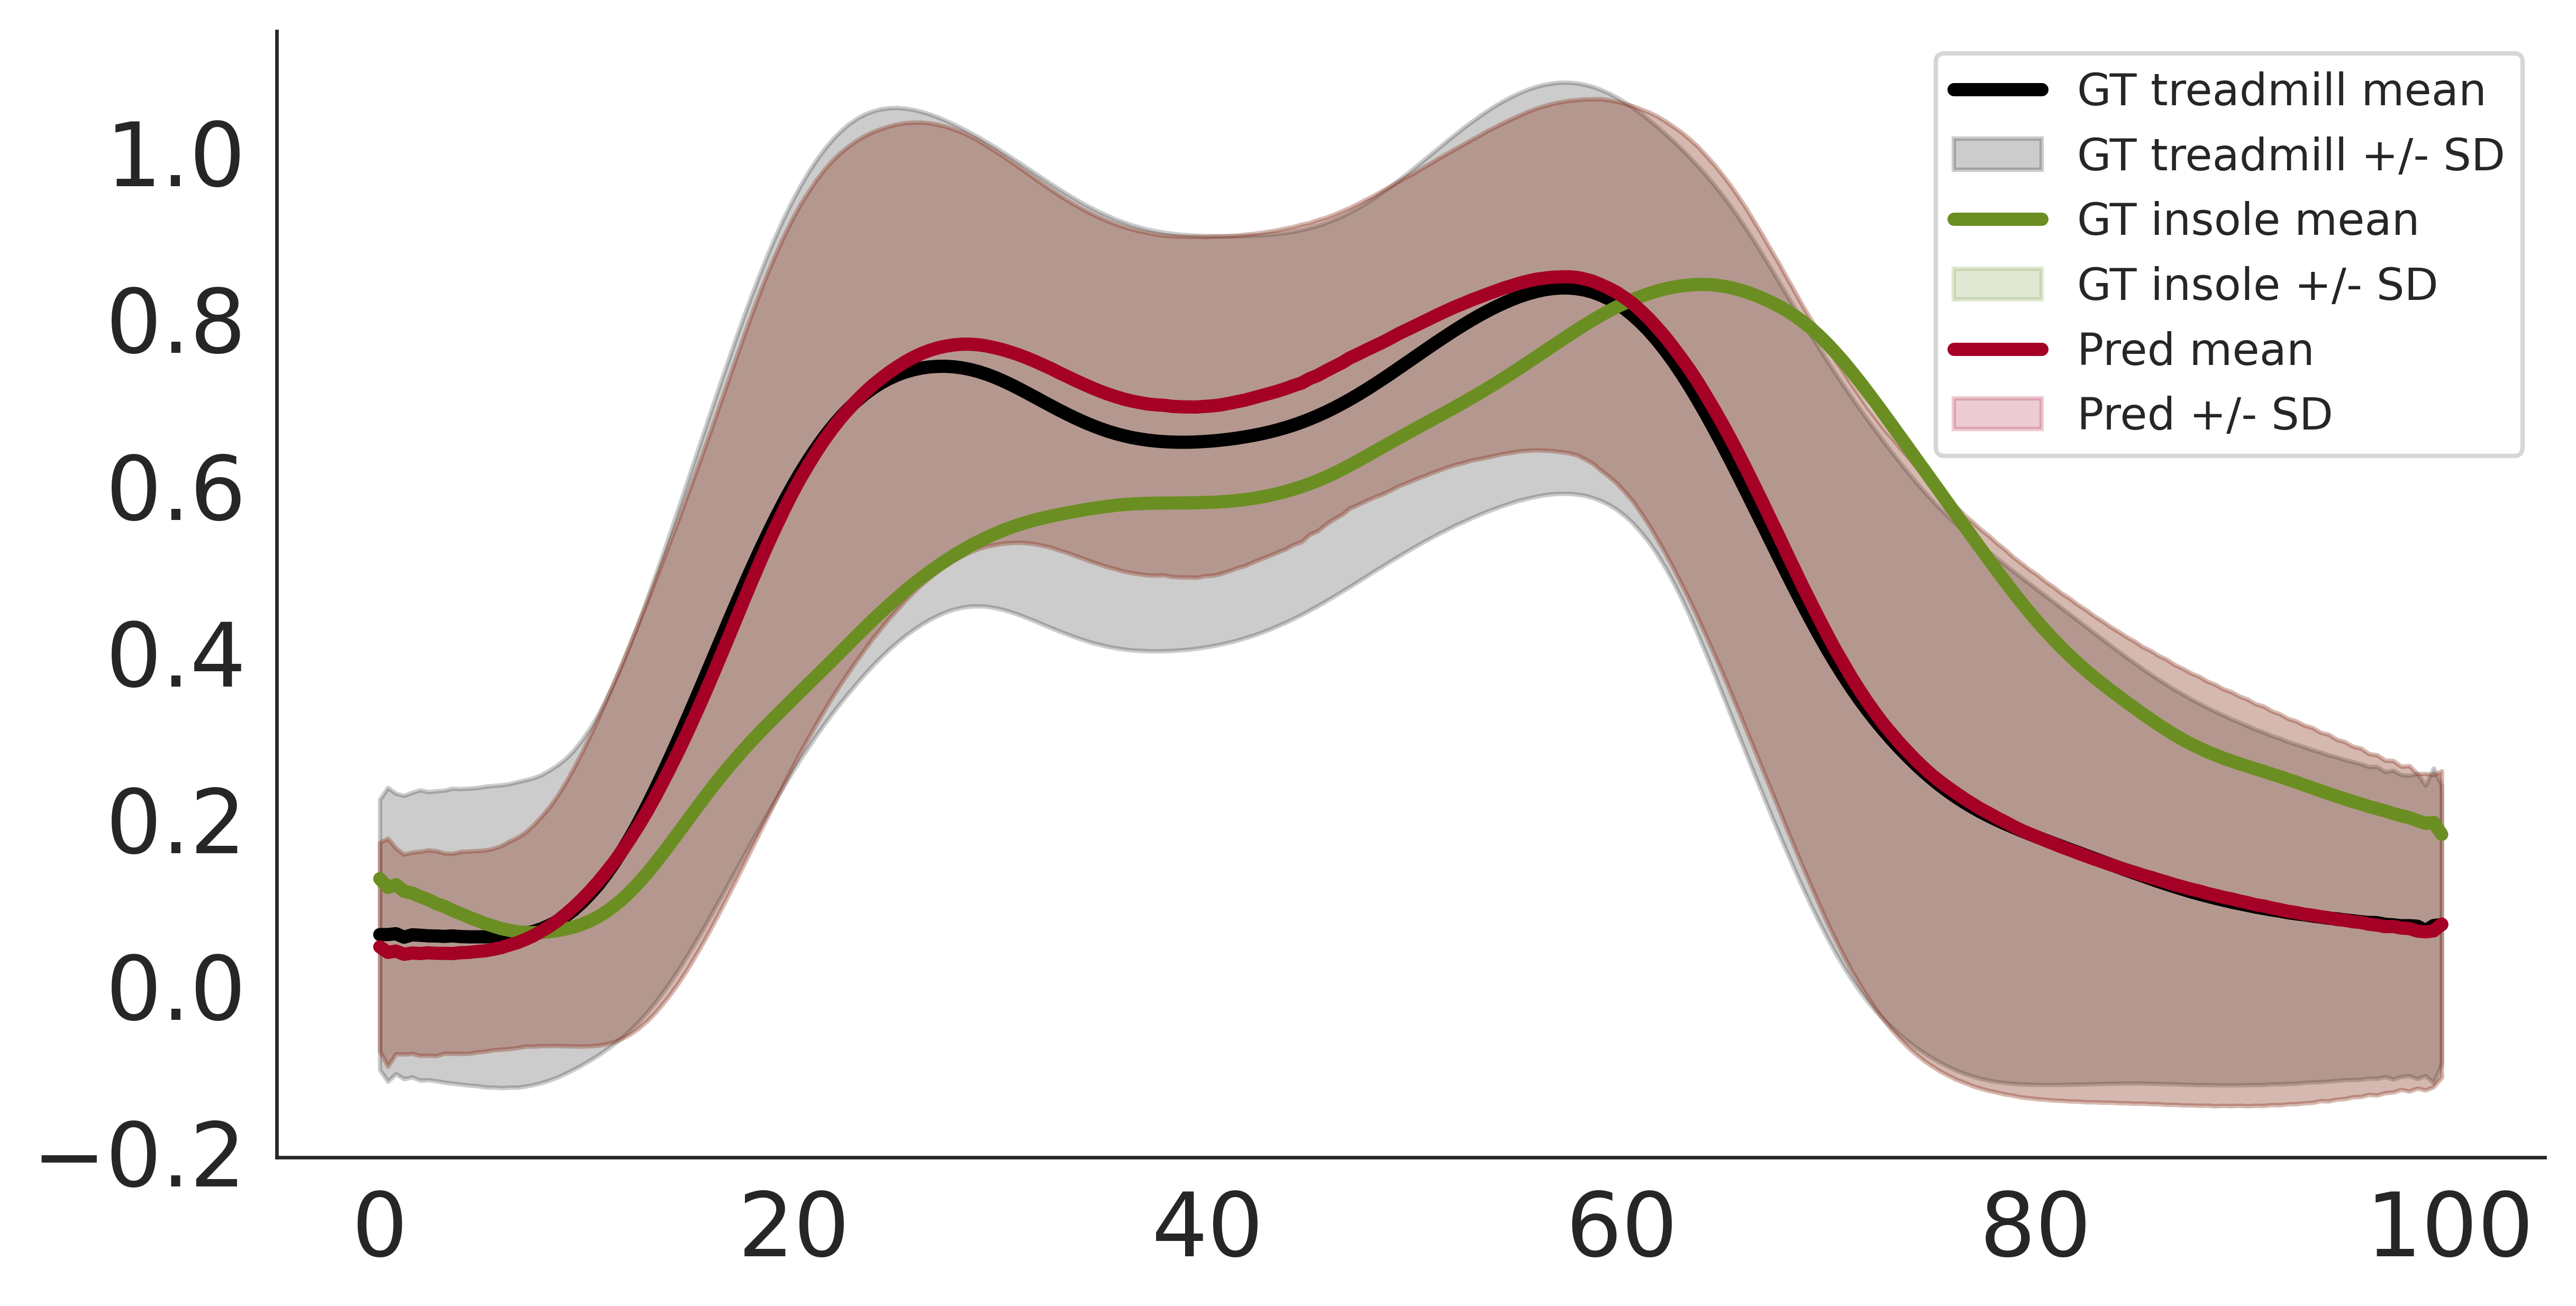

In [31]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_10_LL_WK
PD_data_current_FindPeaks = Y_Pred_Fx_10_LL_WK
GT_data_current_FindPeaks_insole = Y_Test_Fy_10_LL_WK_insole
GT_data_current = Y_Test_Fy_10_LL_WK
GT_data_current_insole = Y_Test_Fy_10_LL_WK_insole
PD_data_current = Y_Pred_Fy_10_LL_WK
data_shape = GT_data_current.shape
GT_data_current_Templates = []
GT_data_current_insole_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    GT_data_current_insole_temp = GT_data_current_insole[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    GT_data_current_FindPeaks_temp_insole = GT_data_current_FindPeaks_insole[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_gt_insole, _ = find_peaks(GT_data_current_FindPeaks_temp_insole, height=0.85, distance=200)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
        except:
            continue
    for ii in range(0,len(peaks_gt_insole)-1):
        try:
            GT_data_current_insole_Template_Temp = GT_data_current_insole_temp[peaks_gt_insole[ii]+offset:peaks_gt_insole[ii+1]+offset]
            GT_data_current_insole_Template_Temp = signal.resample(GT_data_current_insole_Template_Temp, 256)
            GT_data_current_insole_Templates.append(GT_data_current_insole_Template_Temp)
        except:
            continue
    for ii in range(0,len(peaks_pd)-1):
        try:
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
#
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
#
GT_data_current_insole_Templates = np.array(GT_data_current_insole_Templates)
print(GT_data_current_insole_Templates.shape)
mean_gt_insole = np.mean(GT_data_current_insole_Templates, axis=0)
std_gt_insole = np.std(GT_data_current_insole_Templates, axis=0)
t_gt_insole = np.arange(0, len(mean_gt_insole)) / 256 * 100
#
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
#
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=600, layout='constrained', facecolor='white')
# fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black', label='GT treadmill mean')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2, label='GT treadmill +/- SD')
ax.plot(t_gt_insole, mean_gt_insole, linewidth=3, color='olivedrab', label='GT insole mean')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='olivedrab', alpha=0.2, label='GT insole +/- SD')
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026', label='Pred mean')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2, label='Pred +/- SD')
# ax.set_xlabel("Gait Cycle (%)")
# ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
# plt.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

(790, 256)
(746, 256)
0.71927253283237


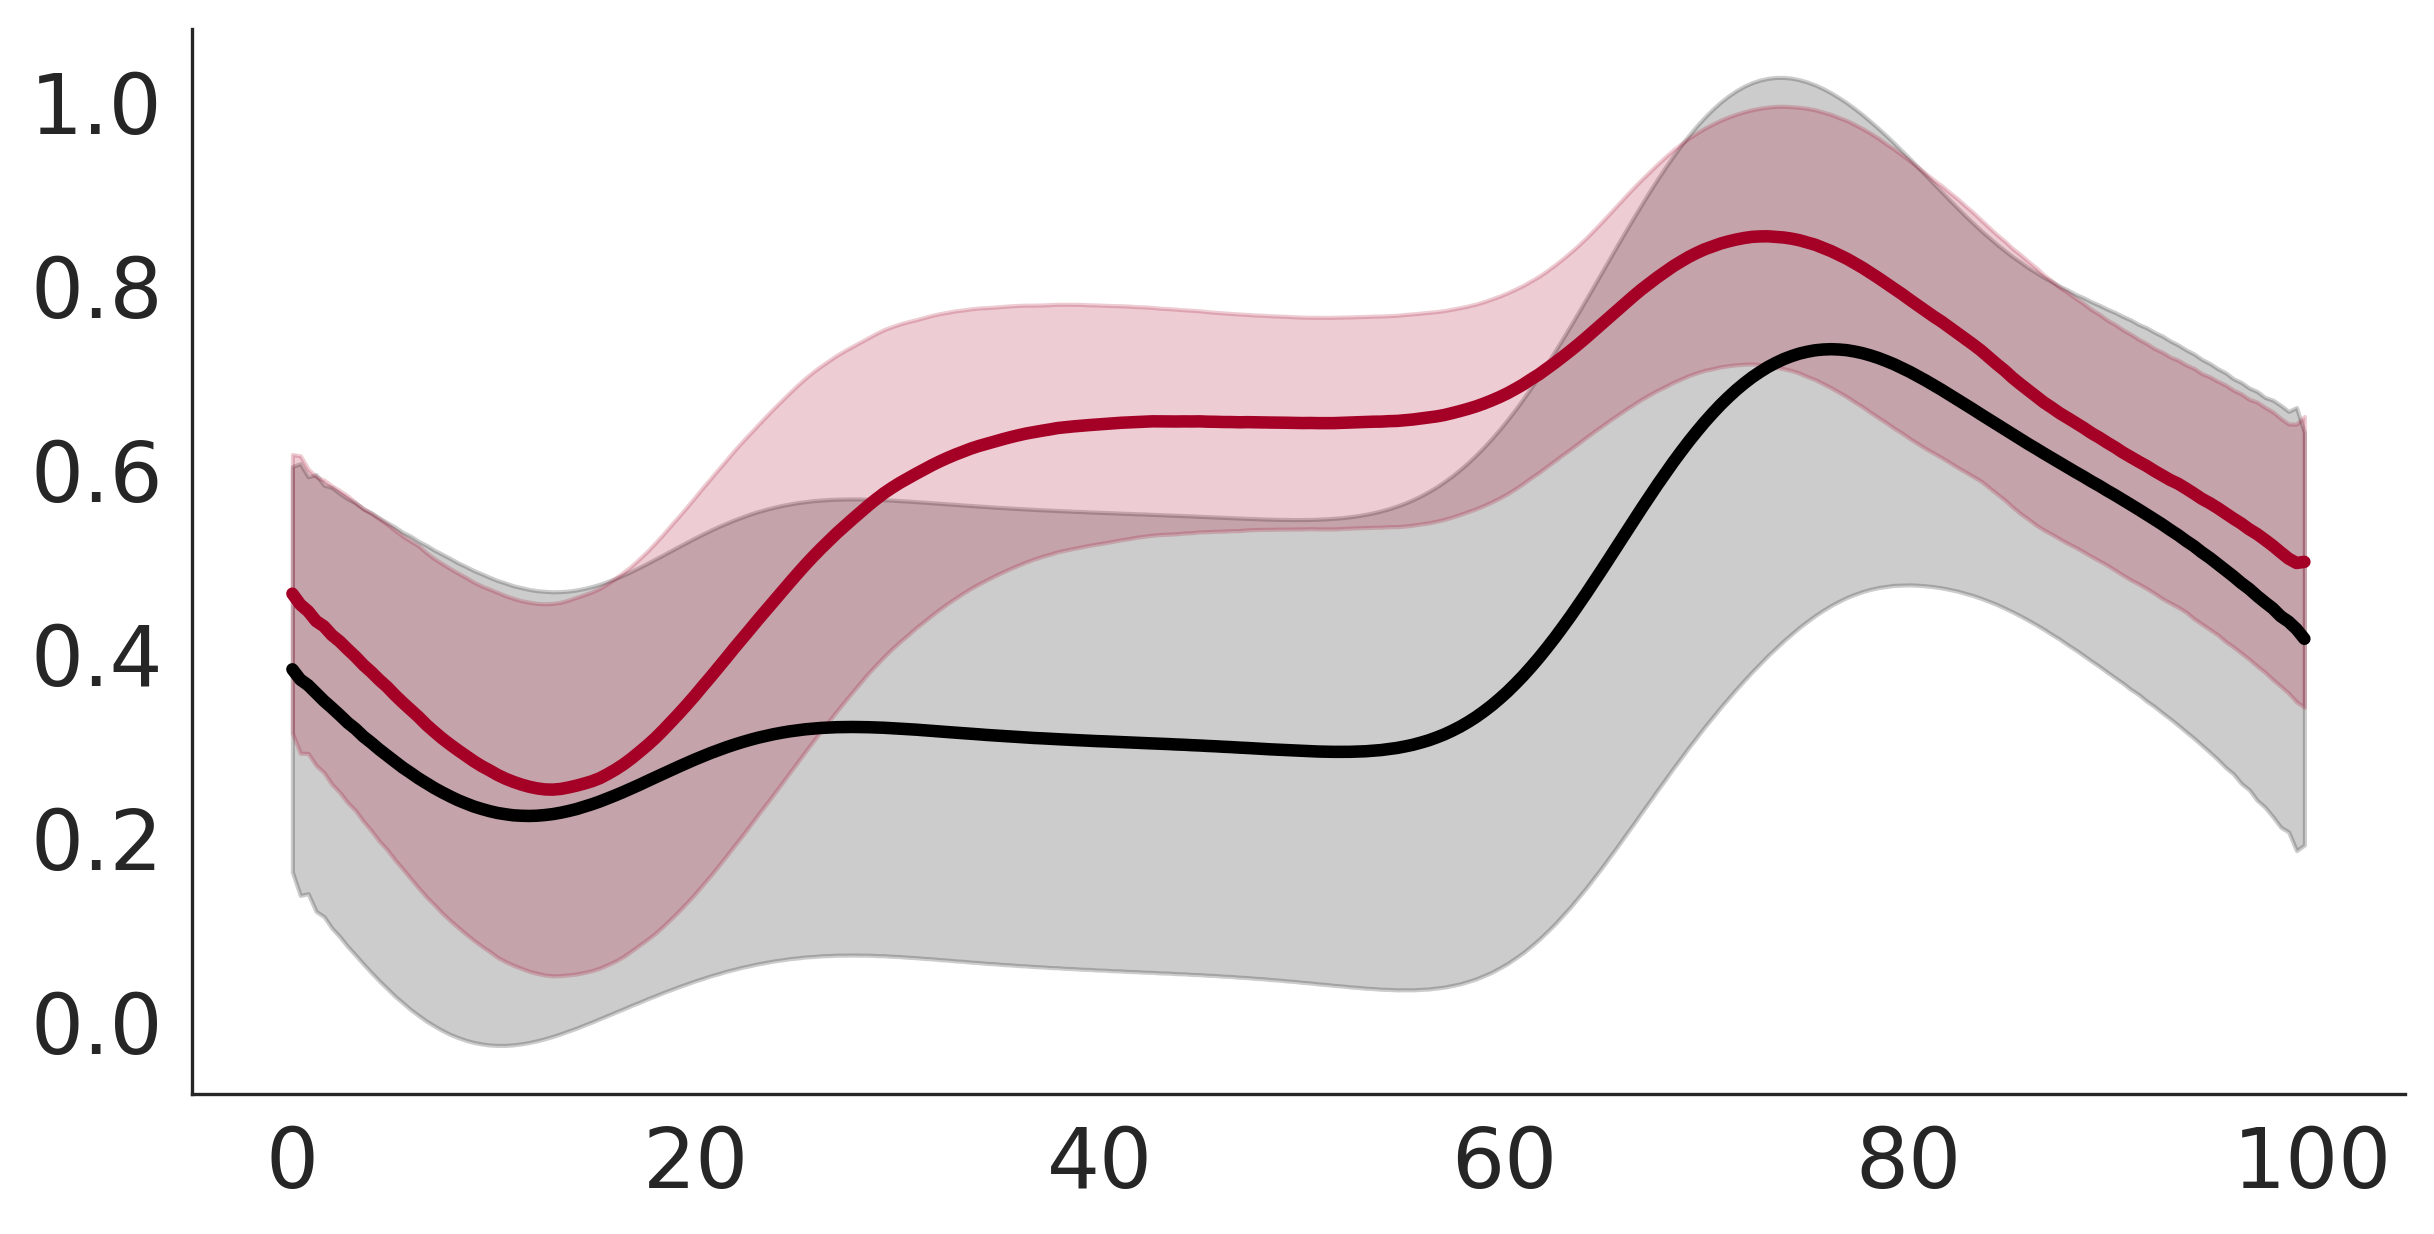

In [22]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_10_LL_WK
PD_data_current_FindPeaks = Y_Pred_Fx_10_LL_WK
GT_data_current = Y_Test_Mz_10_RL_WK
PD_data_current = Y_Pred_Mz_10_RL_WK
data_shape = GT_data_current.shape
GT_data_current_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2)
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2)
# ax.set_xlabel("Gait Cycle (%)")
# ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
# plt.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

(789, 256)
(789, 256)
0.9766444324606586


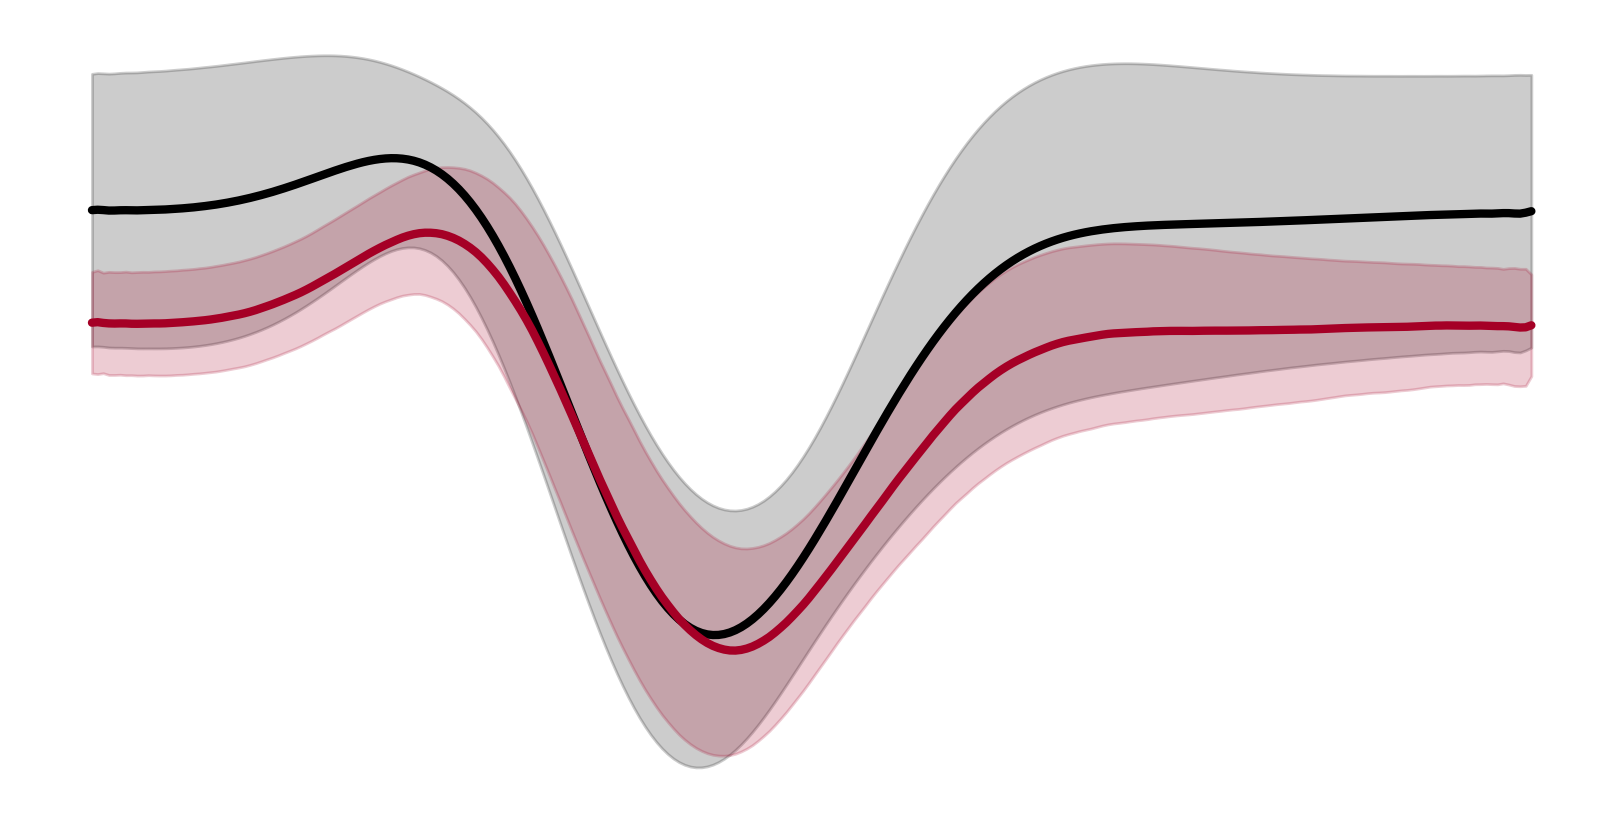

In [168]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_04_LL_RN
PD_data_current_FindPeaks = Y_Pred_Fx_04_LL_RN
GT_data_current = Y_Test_Mz_04_LL_RN
PD_data_current = Y_Pred_Mz_04_LL_RN
data_shape = GT_data_current.shape
GT_data_current_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=200, layout='constrained', facecolor='white')
# fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2)
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2)
# ax.set_xlabel("Gait Cycle (%)")
# ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
plt.axis('off')
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

(789, 256)
(789, 256)
0.8899912397946228


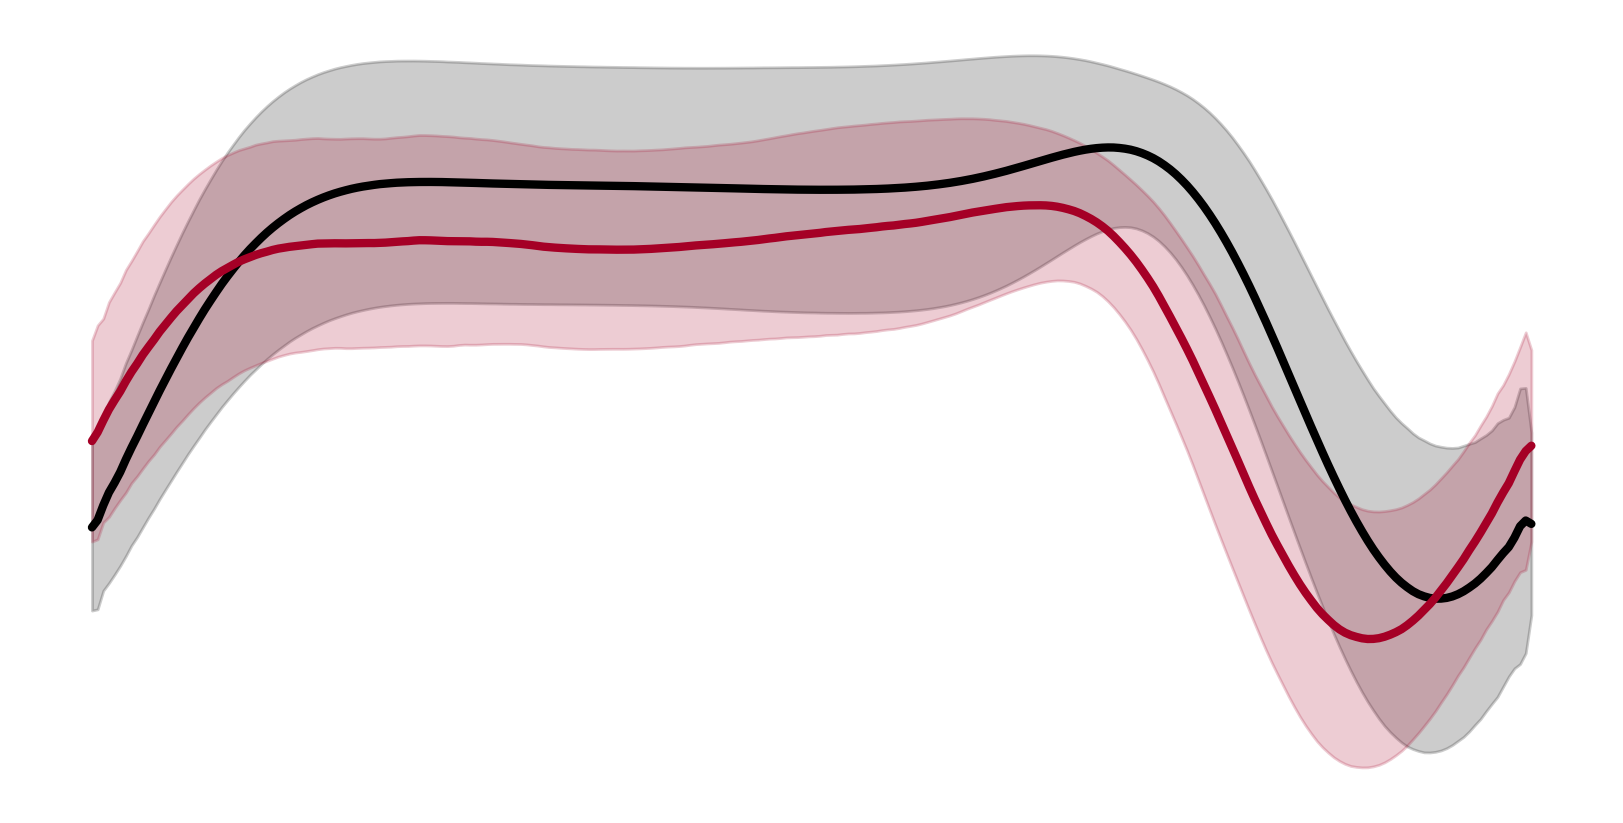

In [170]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_04_LL_RN
PD_data_current_FindPeaks = Y_Pred_Fx_04_LL_RN
GT_data_current = Y_Test_Mz_04_RL_RN
PD_data_current = Y_Pred_Mz_04_RL_RN
data_shape = GT_data_current.shape
GT_data_current_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=200, layout='constrained', facecolor='white')
# fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2)
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2)
# ax.set_xlabel("Gait Cycle (%)")
# ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
plt.axis('off')
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

## Speed-wise plots

### Fx

In [121]:
# Speed 0.9 kph
print('Speed 0.9 kph')
# LL
Indices_LL_09 = np.where(speed_labels_LL == 0.9)[0]
Y_Test_Fx_LL_09 = np.take(Y_Test_Fx_LL, Indices_LL_09, axis=0)
Y_Pred_Fx_LL_09 = np.take(Y_Pred_Fx_LL, Indices_LL_09, axis=0)
print(Y_Test_Fx_LL_09.shape)
print(Y_Pred_Fx_LL_09.shape)
# RL
Indices_RL_09 = np.where(speed_labels_RL == 0.9)[0]
Y_Test_Fx_RL_09 = np.take(Y_Test_Fx_RL, Indices_RL_09, axis=0)
Y_Pred_Fx_RL_09 = np.take(Y_Pred_Fx_RL, Indices_RL_09, axis=0)
print(Y_Test_Fx_RL_09.shape)
print(Y_Pred_Fx_RL_09.shape)
# Speed 1.8 kph
print('Speed 1.8 kph')
# LL
Indices_LL_18 = np.where(speed_labels_LL == 1.8)[0]
Y_Test_Fx_LL_18 = np.take(Y_Test_Fx_LL, Indices_LL_18, axis=0)
Y_Pred_Fx_LL_18 = np.take(Y_Pred_Fx_LL, Indices_LL_18, axis=0)
print(Y_Test_Fx_LL_18.shape)
print(Y_Pred_Fx_LL_18.shape)
# RL
Indices_RL_18 = np.where(speed_labels_RL == 1.8)[0]
Y_Test_Fx_RL_18 = np.take(Y_Test_Fx_RL, Indices_RL_18, axis=0)
Y_Pred_Fx_RL_18 = np.take(Y_Pred_Fx_RL, Indices_RL_18, axis=0)
print(Y_Test_Fx_RL_18.shape)
print(Y_Pred_Fx_RL_18.shape)
# Speed 2.7 kph
print('Speed 2.7 kph')
# LL
Indices_LL_27 = np.where(speed_labels_LL == 2.7)[0]
Y_Test_Fx_LL_27 = np.take(Y_Test_Fx_LL, Indices_LL_27, axis=0)
Y_Pred_Fx_LL_27 = np.take(Y_Pred_Fx_LL, Indices_LL_27, axis=0)
print(Y_Test_Fx_LL_27.shape)
print(Y_Pred_Fx_LL_27.shape)
# RL
Indices_RL_27 = np.where(speed_labels_RL == 2.7)[0]
Y_Test_Fx_RL_27 = np.take(Y_Test_Fx_RL, Indices_RL_27, axis=0)
Y_Pred_Fx_RL_27 = np.take(Y_Pred_Fx_RL, Indices_RL_27, axis=0)
print(Y_Test_Fx_RL_27.shape)
print(Y_Pred_Fx_RL_27.shape)
# Speed 3.6 kph
print('Speed 3.6 kph')
# LL
Indices_LL_36 = np.where(speed_labels_LL == 3.6)[0]
Y_Test_Fx_LL_36 = np.take(Y_Test_Fx_LL, Indices_LL_36, axis=0)
Y_Pred_Fx_LL_36 = np.take(Y_Pred_Fx_LL, Indices_LL_36, axis=0)
print(Y_Test_Fx_LL_36.shape)
print(Y_Pred_Fx_LL_36.shape)
# RL
Indices_RL_36 = np.where(speed_labels_RL == 3.6)[0]
Y_Test_Fx_RL_36 = np.take(Y_Test_Fx_RL, Indices_RL_36, axis=0)
Y_Pred_Fx_RL_36 = np.take(Y_Pred_Fx_RL, Indices_RL_36, axis=0)
print(Y_Test_Fx_RL_36.shape)
print(Y_Pred_Fx_RL_36.shape)
# Speed 4.5 kph
print('Speed 4.5 kph')
# LL
Indices_LL_45 = np.where(speed_labels_LL == 4.5)[0]
Y_Test_Fx_LL_45 = np.take(Y_Test_Fx_LL, Indices_LL_45, axis=0)
Y_Pred_Fx_LL_45 = np.take(Y_Pred_Fx_LL, Indices_LL_45, axis=0)
print(Y_Test_Fx_LL_45.shape)
print(Y_Pred_Fx_LL_45.shape)
# RL
Indices_RL_45 = np.where(speed_labels_RL == 4.5)[0]
Y_Test_Fx_RL_45 = np.take(Y_Test_Fx_RL, Indices_RL_45, axis=0)
Y_Pred_Fx_RL_45 = np.take(Y_Pred_Fx_RL, Indices_RL_45, axis=0)
print(Y_Test_Fx_RL_45.shape)
print(Y_Pred_Fx_RL_45.shape)
# Speed 5.4 kph
print('Speed 5.4 kph')
# LL
Indices_LL_54 = np.where(speed_labels_LL == 5.4)[0]
Y_Test_Fx_LL_54 = np.take(Y_Test_Fx_LL, Indices_LL_54, axis=0)
Y_Pred_Fx_LL_54 = np.take(Y_Pred_Fx_LL, Indices_LL_54, axis=0)
print(Y_Test_Fx_LL_54.shape)
print(Y_Pred_Fx_LL_54.shape)
# RL
Indices_RL_54 = np.where(speed_labels_RL == 5.4)[0]
Y_Test_Fx_RL_54 = np.take(Y_Test_Fx_RL, Indices_RL_54, axis=0)
Y_Pred_Fx_RL_54 = np.take(Y_Pred_Fx_RL, Indices_RL_54, axis=0)
print(Y_Test_Fx_RL_54.shape)
print(Y_Pred_Fx_RL_54.shape)
# Speed 6.3 kph
print('Speed 6.3 kph')
# LL
Indices_LL_63 = np.where(speed_labels_LL == 6.3)[0]
Y_Test_Fx_LL_63 = np.take(Y_Test_Fx_LL, Indices_LL_63, axis=0)
Y_Pred_Fx_LL_63 = np.take(Y_Pred_Fx_LL, Indices_LL_63, axis=0)
print(Y_Test_Fx_LL_63.shape)
print(Y_Pred_Fx_LL_63.shape)
# RL
Indices_RL_63 = np.where(speed_labels_RL == 6.3)[0]
Y_Test_Fx_RL_63 = np.take(Y_Test_Fx_RL, Indices_RL_63, axis=0)
Y_Pred_Fx_RL_63 = np.take(Y_Pred_Fx_RL, Indices_RL_63, axis=0)
print(Y_Test_Fx_RL_63.shape)
print(Y_Pred_Fx_RL_63.shape)
# Speed 8.1 kph
print('Speed 8.1 kph')
# LL
Indices_LL_81 = np.where(speed_labels_LL == 8.1)[0]
Y_Test_Fx_LL_81 = np.take(Y_Test_Fx_LL, Indices_LL_81, axis=0)
Y_Pred_Fx_LL_81 = np.take(Y_Pred_Fx_LL, Indices_LL_81, axis=0)
print(Y_Test_Fx_LL_81.shape)
print(Y_Pred_Fx_LL_81.shape)
# RL
Indices_RL_81 = np.where(speed_labels_RL == 8.1)[0]
Y_Test_Fx_RL_81 = np.take(Y_Test_Fx_RL, Indices_RL_81, axis=0)
Y_Pred_Fx_RL_81 = np.take(Y_Pred_Fx_RL, Indices_RL_81, axis=0)
print(Y_Test_Fx_RL_81.shape)
print(Y_Pred_Fx_RL_81.shape)
# Speed 9.9 kph
print('Speed 9.9 kph')
# LL
Indices_LL_99 = np.where(speed_labels_LL == 9.9)[0]
Y_Test_Fx_LL_99 = np.take(Y_Test_Fx_LL, Indices_LL_99, axis=0)
Y_Pred_Fx_LL_99 = np.take(Y_Pred_Fx_LL, Indices_LL_99, axis=0)
print(Y_Test_Fx_LL_99.shape)
print(Y_Pred_Fx_LL_99.shape)
# RL
Indices_RL_99 = np.where(speed_labels_RL == 9.9)[0]
Y_Test_Fx_RL_99 = np.take(Y_Test_Fx_RL, Indices_RL_99, axis=0)
Y_Pred_Fx_RL_99 = np.take(Y_Pred_Fx_RL, Indices_RL_99, axis=0)
print(Y_Test_Fx_RL_99.shape)
print(Y_Pred_Fx_RL_99.shape)

Speed 0.9 kph
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
Speed 1.8 kph
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
Speed 2.7 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 3.6 kph
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
Speed 4.5 kph
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
Speed 5.4 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
Speed 6.3 kph
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
Speed 8.1 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 9.9 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)


### Fy

In [122]:
# Speed 0.9 kph
print('Speed 0.9 kph')
# LL
Indices_LL_09 = np.where(speed_labels_LL == 0.9)[0]
Y_Test_Fy_LL_09 = np.take(Y_Test_Fy_LL, Indices_LL_09, axis=0)
Y_Pred_Fy_LL_09 = np.take(Y_Pred_Fy_LL, Indices_LL_09, axis=0)
print(Y_Test_Fy_LL_09.shape)
print(Y_Pred_Fy_LL_09.shape)
# RL
Indices_RL_09 = np.where(speed_labels_RL == 0.9)[0]
Y_Test_Fy_RL_09 = np.take(Y_Test_Fy_RL, Indices_RL_09, axis=0)
Y_Pred_Fy_RL_09 = np.take(Y_Pred_Fy_RL, Indices_RL_09, axis=0)
print(Y_Test_Fy_RL_09.shape)
print(Y_Pred_Fy_RL_09.shape)
# Speed 1.8 kph
print('Speed 1.8 kph')
# LL
Indices_LL_18 = np.where(speed_labels_LL == 1.8)[0]
Y_Test_Fy_LL_18 = np.take(Y_Test_Fy_LL, Indices_LL_18, axis=0)
Y_Pred_Fy_LL_18 = np.take(Y_Pred_Fy_LL, Indices_LL_18, axis=0)
print(Y_Test_Fy_LL_18.shape)
print(Y_Pred_Fy_LL_18.shape)
# RL
Indices_RL_18 = np.where(speed_labels_RL == 1.8)[0]
Y_Test_Fy_RL_18 = np.take(Y_Test_Fy_RL, Indices_RL_18, axis=0)
Y_Pred_Fy_RL_18 = np.take(Y_Pred_Fy_RL, Indices_RL_18, axis=0)
print(Y_Test_Fy_RL_18.shape)
print(Y_Pred_Fy_RL_18.shape)
# Speed 2.7 kph
print('Speed 2.7 kph')
# LL
Indices_LL_27 = np.where(speed_labels_LL == 2.7)[0]
Y_Test_Fy_LL_27 = np.take(Y_Test_Fy_LL, Indices_LL_27, axis=0)
Y_Pred_Fy_LL_27 = np.take(Y_Pred_Fy_LL, Indices_LL_27, axis=0)
print(Y_Test_Fy_LL_27.shape)
print(Y_Pred_Fy_LL_27.shape)
# RL
Indices_RL_27 = np.where(speed_labels_RL == 2.7)[0]
Y_Test_Fy_RL_27 = np.take(Y_Test_Fy_RL, Indices_RL_27, axis=0)
Y_Pred_Fy_RL_27 = np.take(Y_Pred_Fy_RL, Indices_RL_27, axis=0)
print(Y_Test_Fy_RL_27.shape)
print(Y_Pred_Fy_RL_27.shape)
# Speed 3.6 kph
print('Speed 3.6 kph')
# LL
Indices_LL_36 = np.where(speed_labels_LL == 3.6)[0]
Y_Test_Fy_LL_36 = np.take(Y_Test_Fy_LL, Indices_LL_36, axis=0)
Y_Pred_Fy_LL_36 = np.take(Y_Pred_Fy_LL, Indices_LL_36, axis=0)
print(Y_Test_Fy_LL_36.shape)
print(Y_Pred_Fy_LL_36.shape)
# RL
Indices_RL_36 = np.where(speed_labels_RL == 3.6)[0]
Y_Test_Fy_RL_36 = np.take(Y_Test_Fy_RL, Indices_RL_36, axis=0)
Y_Pred_Fy_RL_36 = np.take(Y_Pred_Fy_RL, Indices_RL_36, axis=0)
print(Y_Test_Fy_RL_36.shape)
print(Y_Pred_Fy_RL_36.shape)
# Speed 4.5 kph
print('Speed 4.5 kph')
# LL
Indices_LL_45 = np.where(speed_labels_LL == 4.5)[0]
Y_Test_Fy_LL_45 = np.take(Y_Test_Fy_LL, Indices_LL_45, axis=0)
Y_Pred_Fy_LL_45 = np.take(Y_Pred_Fy_LL, Indices_LL_45, axis=0)
print(Y_Test_Fy_LL_45.shape)
print(Y_Pred_Fy_LL_45.shape)
# RL
Indices_RL_45 = np.where(speed_labels_RL == 4.5)[0]
Y_Test_Fy_RL_45 = np.take(Y_Test_Fy_RL, Indices_RL_45, axis=0)
Y_Pred_Fy_RL_45 = np.take(Y_Pred_Fy_RL, Indices_RL_45, axis=0)
print(Y_Test_Fy_RL_45.shape)
print(Y_Pred_Fy_RL_45.shape)
# Speed 5.4 kph
print('Speed 5.4 kph')
# LL
Indices_LL_54 = np.where(speed_labels_LL == 5.4)[0]
Y_Test_Fy_LL_54 = np.take(Y_Test_Fy_LL, Indices_LL_54, axis=0)
Y_Pred_Fy_LL_54 = np.take(Y_Pred_Fy_LL, Indices_LL_54, axis=0)
print(Y_Test_Fy_LL_54.shape)
print(Y_Pred_Fy_LL_54.shape)
# RL
Indices_RL_54 = np.where(speed_labels_RL == 5.4)[0]
Y_Test_Fy_RL_54 = np.take(Y_Test_Fy_RL, Indices_RL_54, axis=0)
Y_Pred_Fy_RL_54 = np.take(Y_Pred_Fy_RL, Indices_RL_54, axis=0)
print(Y_Test_Fy_RL_54.shape)
print(Y_Pred_Fy_RL_54.shape)
# Speed 6.3 kph
print('Speed 6.3 kph')
# LL
Indices_LL_63 = np.where(speed_labels_LL == 6.3)[0]
Y_Test_Fy_LL_63 = np.take(Y_Test_Fy_LL, Indices_LL_63, axis=0)
Y_Pred_Fy_LL_63 = np.take(Y_Pred_Fy_LL, Indices_LL_63, axis=0)
print(Y_Test_Fy_LL_63.shape)
print(Y_Pred_Fy_LL_63.shape)
# RL
Indices_RL_63 = np.where(speed_labels_RL == 6.3)[0]
Y_Test_Fy_RL_63 = np.take(Y_Test_Fy_RL, Indices_RL_63, axis=0)
Y_Pred_Fy_RL_63 = np.take(Y_Pred_Fy_RL, Indices_RL_63, axis=0)
print(Y_Test_Fy_RL_63.shape)
print(Y_Pred_Fy_RL_63.shape)
# Speed 8.1 kph
print('Speed 8.1 kph')
# LL
Indices_LL_81 = np.where(speed_labels_LL == 8.1)[0]
Y_Test_Fy_LL_81 = np.take(Y_Test_Fy_LL, Indices_LL_81, axis=0)
Y_Pred_Fy_LL_81 = np.take(Y_Pred_Fy_LL, Indices_LL_81, axis=0)
print(Y_Test_Fy_LL_81.shape)
print(Y_Pred_Fy_LL_81.shape)
# RL
Indices_RL_81 = np.where(speed_labels_RL == 8.1)[0]
Y_Test_Fy_RL_81 = np.take(Y_Test_Fy_RL, Indices_RL_81, axis=0)
Y_Pred_Fy_RL_81 = np.take(Y_Pred_Fy_RL, Indices_RL_81, axis=0)
print(Y_Test_Fy_RL_81.shape)
print(Y_Pred_Fy_RL_81.shape)
# Speed 9.9 kph
print('Speed 9.9 kph')
# LL
Indices_LL_99 = np.where(speed_labels_LL == 9.9)[0]
Y_Test_Fy_LL_99 = np.take(Y_Test_Fy_LL, Indices_LL_99, axis=0)
Y_Pred_Fy_LL_99 = np.take(Y_Pred_Fy_LL, Indices_LL_99, axis=0)
print(Y_Test_Fy_LL_99.shape)
print(Y_Pred_Fy_LL_99.shape)
# RL
Indices_RL_99 = np.where(speed_labels_RL == 9.9)[0]
Y_Test_Fy_RL_99 = np.take(Y_Test_Fy_RL, Indices_RL_99, axis=0)
Y_Pred_Fy_RL_99 = np.take(Y_Pred_Fy_RL, Indices_RL_99, axis=0)
print(Y_Test_Fy_RL_99.shape)
print(Y_Pred_Fy_RL_99.shape)

Speed 0.9 kph
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
Speed 1.8 kph
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
Speed 2.7 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 3.6 kph
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
Speed 4.5 kph
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
Speed 5.4 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
Speed 6.3 kph
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
Speed 8.1 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 9.9 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)


### Fz

In [123]:
# Speed 0.9 kph
print('Speed 0.9 kph')
# LL
Indices_LL_09 = np.where(speed_labels_LL == 0.9)[0]
Y_Test_Fz_LL_09 = np.take(Y_Test_Fz_LL, Indices_LL_09, axis=0)
Y_Pred_Fz_LL_09 = np.take(Y_Pred_Fz_LL, Indices_LL_09, axis=0)
print(Y_Test_Fz_LL_09.shape)
print(Y_Pred_Fz_LL_09.shape)
# RL
Indices_RL_09 = np.where(speed_labels_RL == 0.9)[0]
Y_Test_Fz_RL_09 = np.take(Y_Test_Fz_RL, Indices_RL_09, axis=0)
Y_Pred_Fz_RL_09 = np.take(Y_Pred_Fz_RL, Indices_RL_09, axis=0)
print(Y_Test_Fz_RL_09.shape)
print(Y_Pred_Fz_RL_09.shape)
# Speed 1.8 kph
print('Speed 1.8 kph')
# LL
Indices_LL_18 = np.where(speed_labels_LL == 1.8)[0]
Y_Test_Fz_LL_18 = np.take(Y_Test_Fz_LL, Indices_LL_18, axis=0)
Y_Pred_Fz_LL_18 = np.take(Y_Pred_Fz_LL, Indices_LL_18, axis=0)
print(Y_Test_Fz_LL_18.shape)
print(Y_Pred_Fz_LL_18.shape)
# RL
Indices_RL_18 = np.where(speed_labels_RL == 1.8)[0]
Y_Test_Fz_RL_18 = np.take(Y_Test_Fz_RL, Indices_RL_18, axis=0)
Y_Pred_Fz_RL_18 = np.take(Y_Pred_Fz_RL, Indices_RL_18, axis=0)
print(Y_Test_Fz_RL_18.shape)
print(Y_Pred_Fz_RL_18.shape)
# Speed 2.7 kph
print('Speed 2.7 kph')
# LL
Indices_LL_27 = np.where(speed_labels_LL == 2.7)[0]
Y_Test_Fz_LL_27 = np.take(Y_Test_Fz_LL, Indices_LL_27, axis=0)
Y_Pred_Fz_LL_27 = np.take(Y_Pred_Fz_LL, Indices_LL_27, axis=0)
print(Y_Test_Fz_LL_27.shape)
print(Y_Pred_Fz_LL_27.shape)
# RL
Indices_RL_27 = np.where(speed_labels_RL == 2.7)[0]
Y_Test_Fz_RL_27 = np.take(Y_Test_Fz_RL, Indices_RL_27, axis=0)
Y_Pred_Fz_RL_27 = np.take(Y_Pred_Fz_RL, Indices_RL_27, axis=0)
print(Y_Test_Fz_RL_27.shape)
print(Y_Pred_Fz_RL_27.shape)
# Speed 3.6 kph
print('Speed 3.6 kph')
# LL
Indices_LL_36 = np.where(speed_labels_LL == 3.6)[0]
Y_Test_Fz_LL_36 = np.take(Y_Test_Fz_LL, Indices_LL_36, axis=0)
Y_Pred_Fz_LL_36 = np.take(Y_Pred_Fz_LL, Indices_LL_36, axis=0)
print(Y_Test_Fz_LL_36.shape)
print(Y_Pred_Fz_LL_36.shape)
# RL
Indices_RL_36 = np.where(speed_labels_RL == 3.6)[0]
Y_Test_Fz_RL_36 = np.take(Y_Test_Fz_RL, Indices_RL_36, axis=0)
Y_Pred_Fz_RL_36 = np.take(Y_Pred_Fz_RL, Indices_RL_36, axis=0)
print(Y_Test_Fz_RL_36.shape)
print(Y_Pred_Fz_RL_36.shape)
# Speed 4.5 kph
print('Speed 4.5 kph')
# LL
Indices_LL_45 = np.where(speed_labels_LL == 4.5)[0]
Y_Test_Fz_LL_45 = np.take(Y_Test_Fz_LL, Indices_LL_45, axis=0)
Y_Pred_Fz_LL_45 = np.take(Y_Pred_Fz_LL, Indices_LL_45, axis=0)
print(Y_Test_Fz_LL_45.shape)
print(Y_Pred_Fz_LL_45.shape)
# RL
Indices_RL_45 = np.where(speed_labels_RL == 4.5)[0]
Y_Test_Fz_RL_45 = np.take(Y_Test_Fz_RL, Indices_RL_45, axis=0)
Y_Pred_Fz_RL_45 = np.take(Y_Pred_Fz_RL, Indices_RL_45, axis=0)
print(Y_Test_Fz_RL_45.shape)
print(Y_Pred_Fz_RL_45.shape)
# Speed 5.4 kph
print('Speed 5.4 kph')
# LL
Indices_LL_54 = np.where(speed_labels_LL == 5.4)[0]
Y_Test_Fz_LL_54 = np.take(Y_Test_Fz_LL, Indices_LL_54, axis=0)
Y_Pred_Fz_LL_54 = np.take(Y_Pred_Fz_LL, Indices_LL_54, axis=0)
print(Y_Test_Fz_LL_54.shape)
print(Y_Pred_Fz_LL_54.shape)
# RL
Indices_RL_54 = np.where(speed_labels_RL == 5.4)[0]
Y_Test_Fz_RL_54 = np.take(Y_Test_Fz_RL, Indices_RL_54, axis=0)
Y_Pred_Fz_RL_54 = np.take(Y_Pred_Fz_RL, Indices_RL_54, axis=0)
print(Y_Test_Fz_RL_54.shape)
print(Y_Pred_Fz_RL_54.shape)
# Speed 6.3 kph
print('Speed 6.3 kph')
# LL
Indices_LL_63 = np.where(speed_labels_LL == 6.3)[0]
Y_Test_Fz_LL_63 = np.take(Y_Test_Fz_LL, Indices_LL_63, axis=0)
Y_Pred_Fz_LL_63 = np.take(Y_Pred_Fz_LL, Indices_LL_63, axis=0)
print(Y_Test_Fz_LL_63.shape)
print(Y_Pred_Fz_LL_63.shape)
# RL
Indices_RL_63 = np.where(speed_labels_RL == 6.3)[0]
Y_Test_Fz_RL_63 = np.take(Y_Test_Fz_RL, Indices_RL_63, axis=0)
Y_Pred_Fz_RL_63 = np.take(Y_Pred_Fz_RL, Indices_RL_63, axis=0)
print(Y_Test_Fz_RL_63.shape)
print(Y_Pred_Fz_RL_63.shape)
# Speed 8.1 kph
print('Speed 8.1 kph')
# LL
Indices_LL_81 = np.where(speed_labels_LL == 8.1)[0]
Y_Test_Fz_LL_81 = np.take(Y_Test_Fz_LL, Indices_LL_81, axis=0)
Y_Pred_Fz_LL_81 = np.take(Y_Pred_Fz_LL, Indices_LL_81, axis=0)
print(Y_Test_Fz_LL_81.shape)
print(Y_Pred_Fz_LL_81.shape)
# RL
Indices_RL_81 = np.where(speed_labels_RL == 8.1)[0]
Y_Test_Fz_RL_81 = np.take(Y_Test_Fz_RL, Indices_RL_81, axis=0)
Y_Pred_Fz_RL_81 = np.take(Y_Pred_Fz_RL, Indices_RL_81, axis=0)
print(Y_Test_Fz_RL_81.shape)
print(Y_Pred_Fz_RL_81.shape)
# Speed 9.9 kph
print('Speed 9.9 kph')
# LL
Indices_LL_99 = np.where(speed_labels_LL == 9.9)[0]
Y_Test_Fz_LL_99 = np.take(Y_Test_Fz_LL, Indices_LL_99, axis=0)
Y_Pred_Fz_LL_99 = np.take(Y_Pred_Fz_LL, Indices_LL_99, axis=0)
print(Y_Test_Fz_LL_99.shape)
print(Y_Pred_Fz_LL_99.shape)
# RL
Indices_RL_99 = np.where(speed_labels_RL == 9.9)[0]
Y_Test_Fz_RL_99 = np.take(Y_Test_Fz_RL, Indices_RL_99, axis=0)
Y_Pred_Fz_RL_99 = np.take(Y_Pred_Fz_RL, Indices_RL_99, axis=0)
print(Y_Test_Fz_RL_99.shape)
print(Y_Pred_Fz_RL_99.shape)

Speed 0.9 kph
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
Speed 1.8 kph
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
Speed 2.7 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 3.6 kph
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
Speed 4.5 kph
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
Speed 5.4 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
Speed 6.3 kph
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
Speed 8.1 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 9.9 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)


### Mx

In [124]:
# Speed 0.9 kph
print('Speed 0.9 kph')
# LL
Indices_LL_09 = np.where(speed_labels_LL == 0.9)[0]
Y_Test_Mx_LL_09 = np.take(Y_Test_Mx_LL, Indices_LL_09, axis=0)
Y_Pred_Mx_LL_09 = np.take(Y_Pred_Mx_LL, Indices_LL_09, axis=0)
print(Y_Test_Mx_LL_09.shape)
print(Y_Pred_Mx_LL_09.shape)
# RL
Indices_RL_09 = np.where(speed_labels_RL == 0.9)[0]
Y_Test_Mx_RL_09 = np.take(Y_Test_Mx_RL, Indices_RL_09, axis=0)
Y_Pred_Mx_RL_09 = np.take(Y_Pred_Mx_RL, Indices_RL_09, axis=0)
print(Y_Test_Mx_RL_09.shape)
print(Y_Pred_Mx_RL_09.shape)
# Speed 1.8 kph
print('Speed 1.8 kph')
# LL
Indices_LL_18 = np.where(speed_labels_LL == 1.8)[0]
Y_Test_Mx_LL_18 = np.take(Y_Test_Mx_LL, Indices_LL_18, axis=0)
Y_Pred_Mx_LL_18 = np.take(Y_Pred_Mx_LL, Indices_LL_18, axis=0)
print(Y_Test_Mx_LL_18.shape)
print(Y_Pred_Mx_LL_18.shape)
# RL
Indices_RL_18 = np.where(speed_labels_RL == 1.8)[0]
Y_Test_Mx_RL_18 = np.take(Y_Test_Mx_RL, Indices_RL_18, axis=0)
Y_Pred_Mx_RL_18 = np.take(Y_Pred_Mx_RL, Indices_RL_18, axis=0)
print(Y_Test_Mx_RL_18.shape)
print(Y_Pred_Mx_RL_18.shape)
# Speed 2.7 kph
print('Speed 2.7 kph')
# LL
Indices_LL_27 = np.where(speed_labels_LL == 2.7)[0]
Y_Test_Mx_LL_27 = np.take(Y_Test_Mx_LL, Indices_LL_27, axis=0)
Y_Pred_Mx_LL_27 = np.take(Y_Pred_Mx_LL, Indices_LL_27, axis=0)
print(Y_Test_Mx_LL_27.shape)
print(Y_Pred_Mx_LL_27.shape)
# RL
Indices_RL_27 = np.where(speed_labels_RL == 2.7)[0]
Y_Test_Mx_RL_27 = np.take(Y_Test_Mx_RL, Indices_RL_27, axis=0)
Y_Pred_Mx_RL_27 = np.take(Y_Pred_Mx_RL, Indices_RL_27, axis=0)
print(Y_Test_Mx_RL_27.shape)
print(Y_Pred_Mx_RL_27.shape)
# Speed 3.6 kph
print('Speed 3.6 kph')
# LL
Indices_LL_36 = np.where(speed_labels_LL == 3.6)[0]
Y_Test_Mx_LL_36 = np.take(Y_Test_Mx_LL, Indices_LL_36, axis=0)
Y_Pred_Mx_LL_36 = np.take(Y_Pred_Mx_LL, Indices_LL_36, axis=0)
print(Y_Test_Mx_LL_36.shape)
print(Y_Pred_Mx_LL_36.shape)
# RL
Indices_RL_36 = np.where(speed_labels_RL == 3.6)[0]
Y_Test_Mx_RL_36 = np.take(Y_Test_Mx_RL, Indices_RL_36, axis=0)
Y_Pred_Mx_RL_36 = np.take(Y_Pred_Mx_RL, Indices_RL_36, axis=0)
print(Y_Test_Mx_RL_36.shape)
print(Y_Pred_Mx_RL_36.shape)
# Speed 4.5 kph
print('Speed 4.5 kph')
# LL
Indices_LL_45 = np.where(speed_labels_LL == 4.5)[0]
Y_Test_Mx_LL_45 = np.take(Y_Test_Mx_LL, Indices_LL_45, axis=0)
Y_Pred_Mx_LL_45 = np.take(Y_Pred_Mx_LL, Indices_LL_45, axis=0)
print(Y_Test_Mx_LL_45.shape)
print(Y_Pred_Mx_LL_45.shape)
# RL
Indices_RL_45 = np.where(speed_labels_RL == 4.5)[0]
Y_Test_Mx_RL_45 = np.take(Y_Test_Mx_RL, Indices_RL_45, axis=0)
Y_Pred_Mx_RL_45 = np.take(Y_Pred_Mx_RL, Indices_RL_45, axis=0)
print(Y_Test_Mx_RL_45.shape)
print(Y_Pred_Mx_RL_45.shape)
# Speed 5.4 kph
print('Speed 5.4 kph')
# LL
Indices_LL_54 = np.where(speed_labels_LL == 5.4)[0]
Y_Test_Mx_LL_54 = np.take(Y_Test_Mx_LL, Indices_LL_54, axis=0)
Y_Pred_Mx_LL_54 = np.take(Y_Pred_Mx_LL, Indices_LL_54, axis=0)
print(Y_Test_Mx_LL_54.shape)
print(Y_Pred_Mx_LL_54.shape)
# RL
Indices_RL_54 = np.where(speed_labels_RL == 5.4)[0]
Y_Test_Mx_RL_54 = np.take(Y_Test_Mx_RL, Indices_RL_54, axis=0)
Y_Pred_Mx_RL_54 = np.take(Y_Pred_Mx_RL, Indices_RL_54, axis=0)
print(Y_Test_Mx_RL_54.shape)
print(Y_Pred_Mx_RL_54.shape)
# Speed 6.3 kph
print('Speed 6.3 kph')
# LL
Indices_LL_63 = np.where(speed_labels_LL == 6.3)[0]
Y_Test_Mx_LL_63 = np.take(Y_Test_Mx_LL, Indices_LL_63, axis=0)
Y_Pred_Mx_LL_63 = np.take(Y_Pred_Mx_LL, Indices_LL_63, axis=0)
print(Y_Test_Mx_LL_63.shape)
print(Y_Pred_Mx_LL_63.shape)
# RL
Indices_RL_63 = np.where(speed_labels_RL == 6.3)[0]
Y_Test_Mx_RL_63 = np.take(Y_Test_Mx_RL, Indices_RL_63, axis=0)
Y_Pred_Mx_RL_63 = np.take(Y_Pred_Mx_RL, Indices_RL_63, axis=0)
print(Y_Test_Mx_RL_63.shape)
print(Y_Pred_Mx_RL_63.shape)
# Speed 8.1 kph
print('Speed 8.1 kph')
# LL
Indices_LL_81 = np.where(speed_labels_LL == 8.1)[0]
Y_Test_Mx_LL_81 = np.take(Y_Test_Mx_LL, Indices_LL_81, axis=0)
Y_Pred_Mx_LL_81 = np.take(Y_Pred_Mx_LL, Indices_LL_81, axis=0)
print(Y_Test_Mx_LL_81.shape)
print(Y_Pred_Mx_LL_81.shape)
# RL
Indices_RL_81 = np.where(speed_labels_RL == 8.1)[0]
Y_Test_Mx_RL_81 = np.take(Y_Test_Mx_RL, Indices_RL_81, axis=0)
Y_Pred_Mx_RL_81 = np.take(Y_Pred_Mx_RL, Indices_RL_81, axis=0)
print(Y_Test_Mx_RL_81.shape)
print(Y_Pred_Mx_RL_81.shape)
# Speed 9.9 kph
print('Speed 9.9 kph')
# LL
Indices_LL_99 = np.where(speed_labels_LL == 9.9)[0]
Y_Test_Mx_LL_99 = np.take(Y_Test_Mx_LL, Indices_LL_99, axis=0)
Y_Pred_Mx_LL_99 = np.take(Y_Pred_Mx_LL, Indices_LL_99, axis=0)
print(Y_Test_Mx_LL_99.shape)
print(Y_Pred_Mx_LL_99.shape)
# RL
Indices_RL_99 = np.where(speed_labels_RL == 9.9)[0]
Y_Test_Mx_RL_99 = np.take(Y_Test_Mx_RL, Indices_RL_99, axis=0)
Y_Pred_Mx_RL_99 = np.take(Y_Pred_Mx_RL, Indices_RL_99, axis=0)
print(Y_Test_Mx_RL_99.shape)
print(Y_Pred_Mx_RL_99.shape)

Speed 0.9 kph
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
Speed 1.8 kph
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
Speed 2.7 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 3.6 kph
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
Speed 4.5 kph
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
Speed 5.4 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
Speed 6.3 kph
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
Speed 8.1 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 9.9 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)


### My

In [125]:
# Speed 0.9 kph
print('Speed 0.9 kph')
# LL
Indices_LL_09 = np.where(speed_labels_LL == 0.9)[0]
Y_Test_My_LL_09 = np.take(Y_Test_My_LL, Indices_LL_09, axis=0)
Y_Pred_My_LL_09 = np.take(Y_Pred_My_LL, Indices_LL_09, axis=0)
print(Y_Test_My_LL_09.shape)
print(Y_Pred_My_LL_09.shape)
# RL
Indices_RL_09 = np.where(speed_labels_RL == 0.9)[0]
Y_Test_My_RL_09 = np.take(Y_Test_My_RL, Indices_RL_09, axis=0)
Y_Pred_My_RL_09 = np.take(Y_Pred_My_RL, Indices_RL_09, axis=0)
print(Y_Test_My_RL_09.shape)
print(Y_Pred_My_RL_09.shape)
# Speed 1.8 kph
print('Speed 1.8 kph')
# LL
Indices_LL_18 = np.where(speed_labels_LL == 1.8)[0]
Y_Test_My_LL_18 = np.take(Y_Test_My_LL, Indices_LL_18, axis=0)
Y_Pred_My_LL_18 = np.take(Y_Pred_My_LL, Indices_LL_18, axis=0)
print(Y_Test_My_LL_18.shape)
print(Y_Pred_My_LL_18.shape)
# RL
Indices_RL_18 = np.where(speed_labels_RL == 1.8)[0]
Y_Test_My_RL_18 = np.take(Y_Test_My_RL, Indices_RL_18, axis=0)
Y_Pred_My_RL_18 = np.take(Y_Pred_My_RL, Indices_RL_18, axis=0)
print(Y_Test_My_RL_18.shape)
print(Y_Pred_My_RL_18.shape)
# Speed 2.7 kph
print('Speed 2.7 kph')
# LL
Indices_LL_27 = np.where(speed_labels_LL == 2.7)[0]
Y_Test_My_LL_27 = np.take(Y_Test_My_LL, Indices_LL_27, axis=0)
Y_Pred_My_LL_27 = np.take(Y_Pred_My_LL, Indices_LL_27, axis=0)
print(Y_Test_My_LL_27.shape)
print(Y_Pred_My_LL_27.shape)
# RL
Indices_RL_27 = np.where(speed_labels_RL == 2.7)[0]
Y_Test_My_RL_27 = np.take(Y_Test_My_RL, Indices_RL_27, axis=0)
Y_Pred_My_RL_27 = np.take(Y_Pred_My_RL, Indices_RL_27, axis=0)
print(Y_Test_My_RL_27.shape)
print(Y_Pred_My_RL_27.shape)
# Speed 3.6 kph
print('Speed 3.6 kph')
# LL
Indices_LL_36 = np.where(speed_labels_LL == 3.6)[0]
Y_Test_My_LL_36 = np.take(Y_Test_My_LL, Indices_LL_36, axis=0)
Y_Pred_My_LL_36 = np.take(Y_Pred_My_LL, Indices_LL_36, axis=0)
print(Y_Test_My_LL_36.shape)
print(Y_Pred_My_LL_36.shape)
# RL
Indices_RL_36 = np.where(speed_labels_RL == 3.6)[0]
Y_Test_My_RL_36 = np.take(Y_Test_My_RL, Indices_RL_36, axis=0)
Y_Pred_My_RL_36 = np.take(Y_Pred_My_RL, Indices_RL_36, axis=0)
print(Y_Test_My_RL_36.shape)
print(Y_Pred_My_RL_36.shape)
# Speed 4.5 kph
print('Speed 4.5 kph')
# LL
Indices_LL_45 = np.where(speed_labels_LL == 4.5)[0]
Y_Test_My_LL_45 = np.take(Y_Test_My_LL, Indices_LL_45, axis=0)
Y_Pred_My_LL_45 = np.take(Y_Pred_My_LL, Indices_LL_45, axis=0)
print(Y_Test_My_LL_45.shape)
print(Y_Pred_My_LL_45.shape)
# RL
Indices_RL_45 = np.where(speed_labels_RL == 4.5)[0]
Y_Test_My_RL_45 = np.take(Y_Test_My_RL, Indices_RL_45, axis=0)
Y_Pred_My_RL_45 = np.take(Y_Pred_My_RL, Indices_RL_45, axis=0)
print(Y_Test_My_RL_45.shape)
print(Y_Pred_My_RL_45.shape)
# Speed 5.4 kph
print('Speed 5.4 kph')
# LL
Indices_LL_54 = np.where(speed_labels_LL == 5.4)[0]
Y_Test_My_LL_54 = np.take(Y_Test_My_LL, Indices_LL_54, axis=0)
Y_Pred_My_LL_54 = np.take(Y_Pred_My_LL, Indices_LL_54, axis=0)
print(Y_Test_My_LL_54.shape)
print(Y_Pred_My_LL_54.shape)
# RL
Indices_RL_54 = np.where(speed_labels_RL == 5.4)[0]
Y_Test_My_RL_54 = np.take(Y_Test_My_RL, Indices_RL_54, axis=0)
Y_Pred_My_RL_54 = np.take(Y_Pred_My_RL, Indices_RL_54, axis=0)
print(Y_Test_My_RL_54.shape)
print(Y_Pred_My_RL_54.shape)
# Speed 6.3 kph
print('Speed 6.3 kph')
# LL
Indices_LL_63 = np.where(speed_labels_LL == 6.3)[0]
Y_Test_My_LL_63 = np.take(Y_Test_My_LL, Indices_LL_63, axis=0)
Y_Pred_My_LL_63 = np.take(Y_Pred_My_LL, Indices_LL_63, axis=0)
print(Y_Test_My_LL_63.shape)
print(Y_Pred_My_LL_63.shape)
# RL
Indices_RL_63 = np.where(speed_labels_RL == 6.3)[0]
Y_Test_My_RL_63 = np.take(Y_Test_My_RL, Indices_RL_63, axis=0)
Y_Pred_My_RL_63 = np.take(Y_Pred_My_RL, Indices_RL_63, axis=0)
print(Y_Test_My_RL_63.shape)
print(Y_Pred_My_RL_63.shape)
# Speed 8.1 kph
print('Speed 8.1 kph')
# LL
Indices_LL_81 = np.where(speed_labels_LL == 8.1)[0]
Y_Test_My_LL_81 = np.take(Y_Test_My_LL, Indices_LL_81, axis=0)
Y_Pred_My_LL_81 = np.take(Y_Pred_My_LL, Indices_LL_81, axis=0)
print(Y_Test_My_LL_81.shape)
print(Y_Pred_My_LL_81.shape)
# RL
Indices_RL_81 = np.where(speed_labels_RL == 8.1)[0]
Y_Test_My_RL_81 = np.take(Y_Test_My_RL, Indices_RL_81, axis=0)
Y_Pred_My_RL_81 = np.take(Y_Pred_My_RL, Indices_RL_81, axis=0)
print(Y_Test_My_RL_81.shape)
print(Y_Pred_My_RL_81.shape)
# Speed 9.9 kph
print('Speed 9.9 kph')
# LL
Indices_LL_99 = np.where(speed_labels_LL == 9.9)[0]
Y_Test_My_LL_99 = np.take(Y_Test_My_LL, Indices_LL_99, axis=0)
Y_Pred_My_LL_99 = np.take(Y_Pred_My_LL, Indices_LL_99, axis=0)
print(Y_Test_My_LL_99.shape)
print(Y_Pred_My_LL_99.shape)
# RL
Indices_RL_99 = np.where(speed_labels_RL == 9.9)[0]
Y_Test_My_RL_99 = np.take(Y_Test_My_RL, Indices_RL_99, axis=0)
Y_Pred_My_RL_99 = np.take(Y_Pred_My_RL, Indices_RL_99, axis=0)
print(Y_Test_My_RL_99.shape)
print(Y_Pred_My_RL_99.shape)

Speed 0.9 kph
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
Speed 1.8 kph
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
Speed 2.7 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 3.6 kph
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
Speed 4.5 kph
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
Speed 5.4 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
Speed 6.3 kph
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
Speed 8.1 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 9.9 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)


### Mz

In [126]:
# Speed 0.9 kph
print('Speed 0.9 kph')
# LL
Indices_LL_09 = np.where(speed_labels_LL == 0.9)[0]
Y_Test_Mz_LL_09 = np.take(Y_Test_Mz_LL, Indices_LL_09, axis=0)
Y_Pred_Mz_LL_09 = np.take(Y_Pred_Mz_LL, Indices_LL_09, axis=0)
print(Y_Test_Mz_LL_09.shape)
print(Y_Pred_Mz_LL_09.shape)
# RL
Indices_RL_09 = np.where(speed_labels_RL == 0.9)[0]
Y_Test_Mz_RL_09 = np.take(Y_Test_Mz_RL, Indices_RL_09, axis=0)
Y_Pred_Mz_RL_09 = np.take(Y_Pred_Mz_RL, Indices_RL_09, axis=0)
print(Y_Test_Mz_RL_09.shape)
print(Y_Pred_Mz_RL_09.shape)
# Speed 1.8 kph
print('Speed 1.8 kph')
# LL
Indices_LL_18 = np.where(speed_labels_LL == 1.8)[0]
Y_Test_Mz_LL_18 = np.take(Y_Test_Mz_LL, Indices_LL_18, axis=0)
Y_Pred_Mz_LL_18 = np.take(Y_Pred_Mz_LL, Indices_LL_18, axis=0)
print(Y_Test_Mz_LL_18.shape)
print(Y_Pred_Mz_LL_18.shape)
# RL
Indices_RL_18 = np.where(speed_labels_RL == 1.8)[0]
Y_Test_Mz_RL_18 = np.take(Y_Test_Mz_RL, Indices_RL_18, axis=0)
Y_Pred_Mz_RL_18 = np.take(Y_Pred_Mz_RL, Indices_RL_18, axis=0)
print(Y_Test_Mz_RL_18.shape)
print(Y_Pred_Mz_RL_18.shape)
# Speed 2.7 kph
print('Speed 2.7 kph')
# LL
Indices_LL_27 = np.where(speed_labels_LL == 2.7)[0]
Y_Test_Mz_LL_27 = np.take(Y_Test_Mz_LL, Indices_LL_27, axis=0)
Y_Pred_Mz_LL_27 = np.take(Y_Pred_Mz_LL, Indices_LL_27, axis=0)
print(Y_Test_Mz_LL_27.shape)
print(Y_Pred_Mz_LL_27.shape)
# RL
Indices_RL_27 = np.where(speed_labels_RL == 2.7)[0]
Y_Test_Mz_RL_27 = np.take(Y_Test_Mz_RL, Indices_RL_27, axis=0)
Y_Pred_Mz_RL_27 = np.take(Y_Pred_Mz_RL, Indices_RL_27, axis=0)
print(Y_Test_Mz_RL_27.shape)
print(Y_Pred_Mz_RL_27.shape)
# Speed 3.6 kph
print('Speed 3.6 kph')
# LL
Indices_LL_36 = np.where(speed_labels_LL == 3.6)[0]
Y_Test_Mz_LL_36 = np.take(Y_Test_Mz_LL, Indices_LL_36, axis=0)
Y_Pred_Mz_LL_36 = np.take(Y_Pred_Mz_LL, Indices_LL_36, axis=0)
print(Y_Test_Mz_LL_36.shape)
print(Y_Pred_Mz_LL_36.shape)
# RL
Indices_RL_36 = np.where(speed_labels_RL == 3.6)[0]
Y_Test_Mz_RL_36 = np.take(Y_Test_Mz_RL, Indices_RL_36, axis=0)
Y_Pred_Mz_RL_36 = np.take(Y_Pred_Mz_RL, Indices_RL_36, axis=0)
print(Y_Test_Mz_RL_36.shape)
print(Y_Pred_Mz_RL_36.shape)
# Speed 4.5 kph
print('Speed 4.5 kph')
# LL
Indices_LL_45 = np.where(speed_labels_LL == 4.5)[0]
Y_Test_Mz_LL_45 = np.take(Y_Test_Mz_LL, Indices_LL_45, axis=0)
Y_Pred_Mz_LL_45 = np.take(Y_Pred_Mz_LL, Indices_LL_45, axis=0)
print(Y_Test_Mz_LL_45.shape)
print(Y_Pred_Mz_LL_45.shape)
# RL
Indices_RL_45 = np.where(speed_labels_RL == 4.5)[0]
Y_Test_Mz_RL_45 = np.take(Y_Test_Mz_RL, Indices_RL_45, axis=0)
Y_Pred_Mz_RL_45 = np.take(Y_Pred_Mz_RL, Indices_RL_45, axis=0)
print(Y_Test_Mz_RL_45.shape)
print(Y_Pred_Mz_RL_45.shape)
# Speed 5.4 kph
print('Speed 5.4 kph')
# LL
Indices_LL_54 = np.where(speed_labels_LL == 5.4)[0]
Y_Test_Mz_LL_54 = np.take(Y_Test_Mz_LL, Indices_LL_54, axis=0)
Y_Pred_Mz_LL_54 = np.take(Y_Pred_Mz_LL, Indices_LL_54, axis=0)
print(Y_Test_Mz_LL_54.shape)
print(Y_Pred_Mz_LL_54.shape)
# RL
Indices_RL_54 = np.where(speed_labels_RL == 5.4)[0]
Y_Test_Mz_RL_54 = np.take(Y_Test_Mz_RL, Indices_RL_54, axis=0)
Y_Pred_Mz_RL_54 = np.take(Y_Pred_Mz_RL, Indices_RL_54, axis=0)
print(Y_Test_Mz_RL_54.shape)
print(Y_Pred_Mz_RL_54.shape)
# Speed 6.3 kph
print('Speed 6.3 kph')
# LL
Indices_LL_63 = np.where(speed_labels_LL == 6.3)[0]
Y_Test_Mz_LL_63 = np.take(Y_Test_Mz_LL, Indices_LL_63, axis=0)
Y_Pred_Mz_LL_63 = np.take(Y_Pred_Mz_LL, Indices_LL_63, axis=0)
print(Y_Test_Mz_LL_63.shape)
print(Y_Pred_Mz_LL_63.shape)
# RL
Indices_RL_63 = np.where(speed_labels_RL == 6.3)[0]
Y_Test_Mz_RL_63 = np.take(Y_Test_Mz_RL, Indices_RL_63, axis=0)
Y_Pred_Mz_RL_63 = np.take(Y_Pred_Mz_RL, Indices_RL_63, axis=0)
print(Y_Test_Mz_RL_63.shape)
print(Y_Pred_Mz_RL_63.shape)
# Speed 8.1 kph
print('Speed 8.1 kph')
# LL
Indices_LL_81 = np.where(speed_labels_LL == 8.1)[0]
Y_Test_Mz_LL_81 = np.take(Y_Test_Mz_LL, Indices_LL_81, axis=0)
Y_Pred_Mz_LL_81 = np.take(Y_Pred_Mz_LL, Indices_LL_81, axis=0)
print(Y_Test_Mz_LL_81.shape)
print(Y_Pred_Mz_LL_81.shape)
# RL
Indices_RL_81 = np.where(speed_labels_RL == 8.1)[0]
Y_Test_Mz_RL_81 = np.take(Y_Test_Mz_RL, Indices_RL_81, axis=0)
Y_Pred_Mz_RL_81 = np.take(Y_Pred_Mz_RL, Indices_RL_81, axis=0)
print(Y_Test_Mz_RL_81.shape)
print(Y_Pred_Mz_RL_81.shape)
# Speed 9.9 kph
print('Speed 9.9 kph')
# LL
Indices_LL_99 = np.where(speed_labels_LL == 9.9)[0]
Y_Test_Mz_LL_99 = np.take(Y_Test_Mz_LL, Indices_LL_99, axis=0)
Y_Pred_Mz_LL_99 = np.take(Y_Pred_Mz_LL, Indices_LL_99, axis=0)
print(Y_Test_Mz_LL_99.shape)
print(Y_Pred_Mz_LL_99.shape)
# RL
Indices_RL_99 = np.where(speed_labels_RL == 9.9)[0]
Y_Test_Mz_RL_99 = np.take(Y_Test_Mz_RL, Indices_RL_99, axis=0)
Y_Pred_Mz_RL_99 = np.take(Y_Pred_Mz_RL, Indices_RL_99, axis=0)
print(Y_Test_Mz_RL_99.shape)
print(Y_Pred_Mz_RL_99.shape)

Speed 0.9 kph
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
(524, 1024, 1)
Speed 1.8 kph
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
(551, 1024, 1)
Speed 2.7 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 3.6 kph
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
(544, 1024, 1)
Speed 4.5 kph
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
(527, 1024, 1)
Speed 5.4 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
Speed 6.3 kph
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
(517, 1024, 1)
Speed 8.1 kph
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
(514, 1024, 1)
Speed 9.9 kph
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)
(523, 1024, 1)


### Plots

(2211, 256)
(2192, 256)
0.9654148251491498


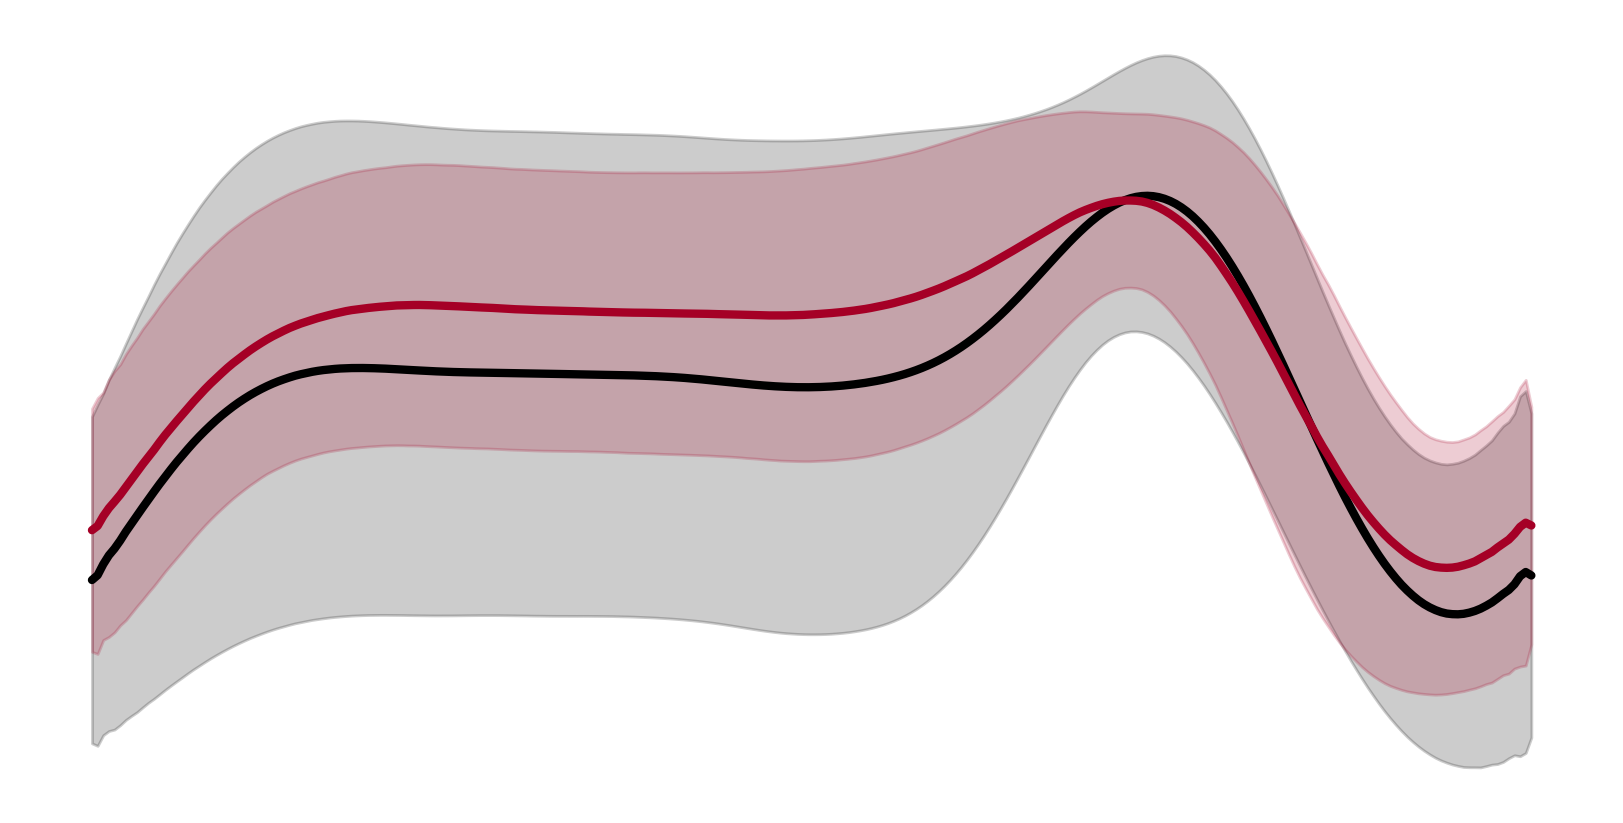

In [162]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_LL_81
PD_data_current_FindPeaks = Y_Pred_Fx_LL_81
GT_data_current = Y_Test_Mz_RL_81
PD_data_current = Y_Pred_Mz_RL_81
data_shape = GT_data_current.shape
GT_data_current_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=200, layout='constrained', facecolor='white')
# fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2)
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2)
# ax.set_xlabel("Gait Cycle (%)")
# ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
plt.axis('off')
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

(830, 256)
(789, 256)
0.9967859815502091


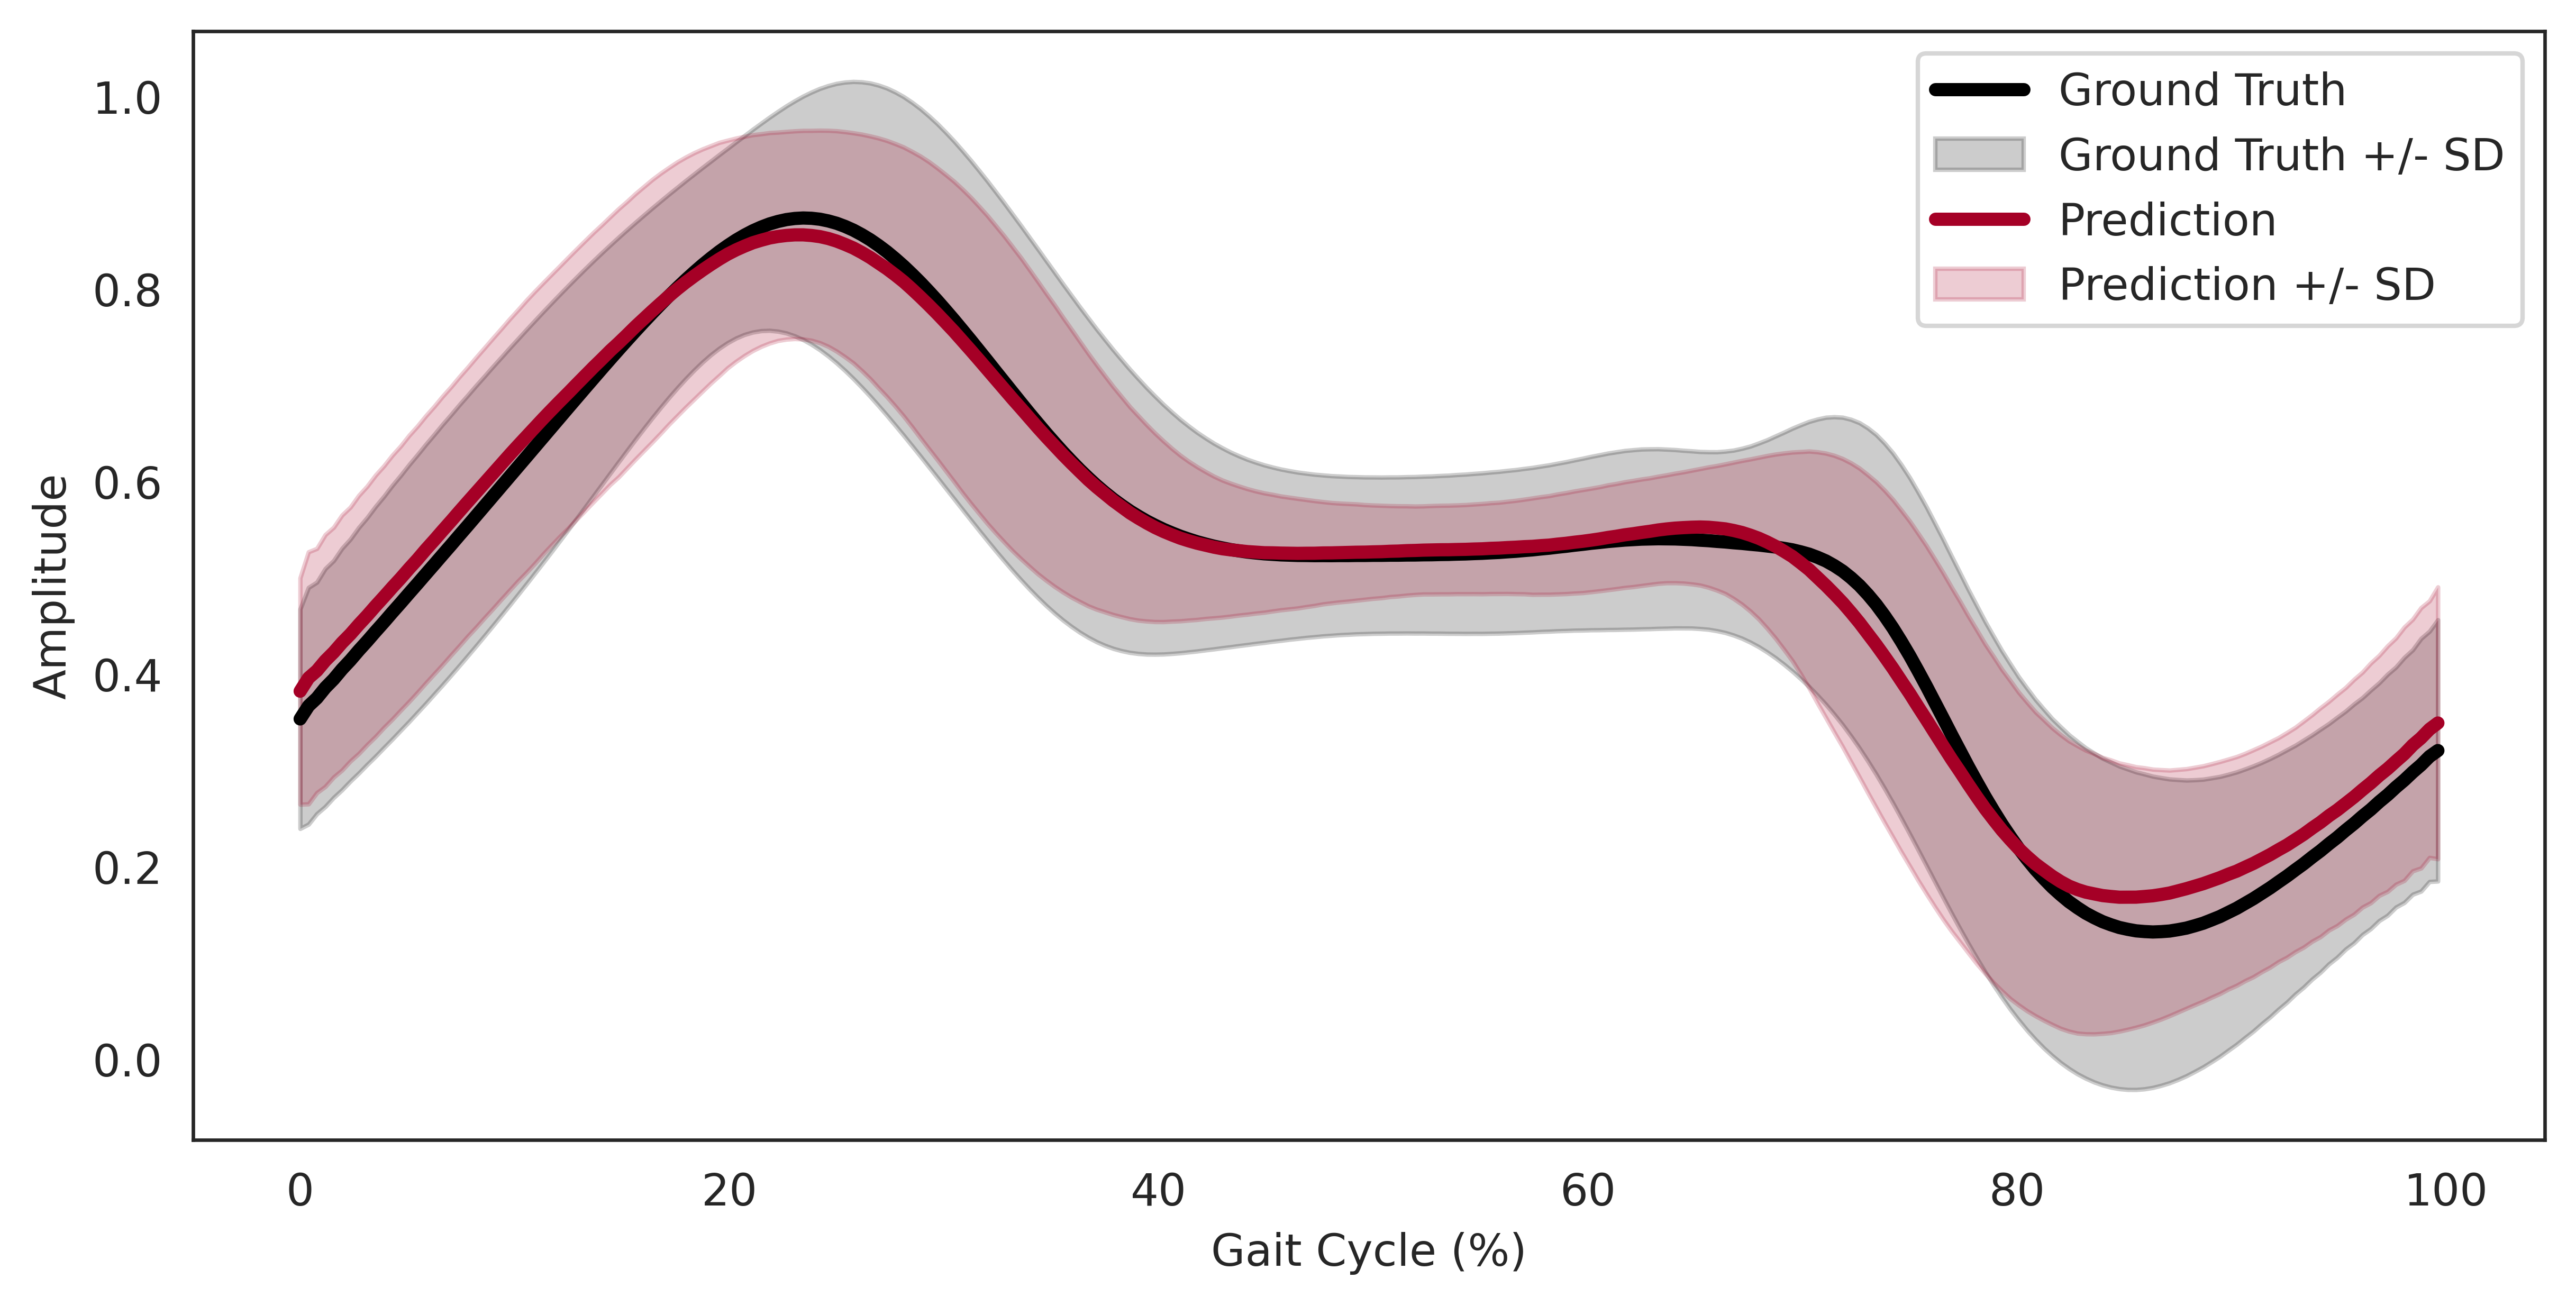

In [232]:
offset = 100
GT_data_current_FindPeaks = Y_Test_Fx_LL_18
PD_data_current_FindPeaks = Y_Pred_Fx_LL_18
GT_data_current = Y_Test_Fx_RL_18
PD_data_current = Y_Pred_Fx_RL_18
data_shape = GT_data_current.shape
GT_data_current_Templates = []
PD_data_current_Templates = []
for i in range(0,data_shape[0]):
    GT_data_current_temp = GT_data_current[i,:,0]
    PD_data_current_temp = PD_data_current[i,:,0]
    GT_data_current_FindPeaks_temp = GT_data_current_FindPeaks[i,:,0]
    PD_data_current_FindPeaks_temp = PD_data_current_FindPeaks[i,:,0]
    peaks_gt, _ = find_peaks(GT_data_current_FindPeaks_temp, height=0.75, distance=100)
    peaks_pd, _ = find_peaks(PD_data_current_FindPeaks_temp, height=0.75, distance=100)
    for ii in range(0,len(peaks_gt)-1):
        try:
            GT_data_current_Template_Temp = GT_data_current_temp[peaks_gt[ii]+offset:peaks_gt[ii+1]+offset]
            GT_data_current_Template_Temp = signal.resample(GT_data_current_Template_Temp, 256)
            GT_data_current_Templates.append(GT_data_current_Template_Temp)
            PD_data_current_Template_Temp = PD_data_current_temp[peaks_pd[ii]+offset:peaks_pd[ii+1]+offset]
            PD_data_current_Template_Temp = signal.resample(PD_data_current_Template_Temp, 256)
            PD_data_current_Templates.append(PD_data_current_Template_Temp)
        except:
            continue
GT_data_current_Templates = np.array(GT_data_current_Templates)
print(GT_data_current_Templates.shape)
mean_gt = np.mean(GT_data_current_Templates, axis=0)
std_gt = np.std(GT_data_current_Templates, axis=0)
t_gt = np.arange(0, len(mean_gt)) / 256 * 100
PD_data_current_Templates = np.array(PD_data_current_Templates)
print(PD_data_current_Templates.shape)
mean_pd = np.mean(PD_data_current_Templates, axis=0)
std_pd = np.std(PD_data_current_Templates, axis=0)
t_pd = np.arange(0, len(mean_pd)) / 256 * 100
pcorr, _ = stats.pearsonr(mean_gt, mean_pd)
print(pcorr)
# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=600, layout='constrained', facecolor='white')
#fig.patch.set_alpha(0)
ax = plt.gca()
ax.plot(t_gt, mean_gt, linewidth=3, color='black', label='Ground Truth')
ax.fill_between(t_gt, mean_gt + std_gt, mean_gt - std_gt, color='black', alpha=0.2, label='Ground Truth +/- SD')
ax.plot(t_pd, mean_pd, linewidth=3, color='#a50026', label='Prediction')
ax.fill_between(t_pd, mean_pd + std_pd, mean_pd - std_pd, color='#a50026', alpha=0.2, label='Prediction +/- SD')
ax.set_xlabel("Gait Cycle (%)")
ax.set_ylabel("Amplitude")
# plt.title(f"Fy")
# turn off the axes
# plt.axis('off')
plt.legend()
# Command used for hiding whitespaces and border. 
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
plt.show() 

# Computational Cost Analysis

Load Model

In [ ]:
SMDisAgg_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, 
                      ds=D_S, ae=A_E, ag=A_G, t=t, is_transconv=is_transconv, q=q).UNet3P()
if D_S == 0:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights= loss_weights)

In [ ]:
# Load Model and Predict
save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
SMDisAgg_Network.load_weights(save_directory)

In [ ]:
import time
# Load Test Set
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
# X_Test = X_Test[0:1,:,:]
# Predict
start_time= time.time() # set the time at which inference started
for i in range (0,39):
    Y_Pred = SMDisAgg_Network.predict(X_Test[i:i+1,:,:], verbose=0)    
stop_time = time.time()
duration = stop_time - start_time
hours = (duration//3600)/39
minutes = (duration - (hours * 3600)) // 60
seconds = duration - ((hours * 3600) + (minutes * 60))

msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
print (msg, flush=True) # print out inferenceduration time

In [ ]:
import numpy as np

trainable_params = np.sum([np.prod(v.get_shape()) for v in SMDisAgg_Network.trainable_weights])
non_trainable_params = np.sum([np.prod(v.get_shape()) for v in SMDisAgg_Network.non_trainable_weights])
total_params = trainable_params + non_trainable_params
    
print(trainable_params)
print(non_trainable_params)
print(total_params)

In [ ]:
SMDisAgg_Network.save('my_model.keras')

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass